# **Introduction**

In this section, two machine learning models will be used to classify the `obito_cancer` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 0 if the person is alive and 1 if he / she died by cancer.

Four scenarios will be created using the column `obito_cancer` as label. The first is the raw data for São Paulo and other states, as was generated in the previous section. The second scenario considers only patients with morphology with the last digit being 3, in addition, the `EC` column was removed.

The third and fourth scenarios use the years of diagnosis grouped, the last one also considering only morphologies with the final digit 3. The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 77)
(32891, 77)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the `ULTINFO` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['obito_cancer']).sort_values(ascending = False).head(20)

obito_cancer    1.000000
obito_geral     0.778975
ULTINFO         0.456566
vivo_ano3       0.403906
ULTIDIAG        0.377902
ULTICONS        0.375342
ULTITRAT        0.370999
vivo_ano1       0.334877
vivo_ano5       0.332117
QUIMIO          0.283284
CIRURGIA        0.267225
RECNENHUM       0.254474
MORFO           0.190021
RECREGIO        0.179450
ANODIAG         0.167594
RECDIST         0.163555
CATEATEND       0.155688
HORMONIO        0.142165
GLEASON         0.130975
PSA             0.129883
Name: obito_cancer, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['obito_cancer']).sort_values(ascending = False).head(20)

obito_cancer    1.000000
obito_geral     0.847824
ULTINFO         0.564266
vivo_ano3       0.399038
ULTIDIAG        0.371161
ULTICONS        0.366288
ULTITRAT        0.360228
vivo_ano5       0.314455
vivo_ano1       0.313149
CIRURGIA        0.307777
QUIMIO          0.285630
MORFO           0.176119
CATEATEND       0.161740
RECNENHUM       0.151496
ANODIAG         0.145834
HORMONIO        0.138524
GLEASON         0.137212
PSA             0.135158
RECDIST         0.122614
ESCOLARI        0.121089
Name: obito_cancer, dtype: float64

Here we have the number of examples for each category of the label, it is possible to notice that there is an imbalance. 

In [ ]:
df_SP.obito_cancer.value_counts()

0    336921
1    169116
Name: obito_cancer, dtype: int64

In [ ]:
df_fora.obito_cancer.value_counts()

0    22802
1    10089
Name: obito_cancer, dtype: int64

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (379527, 66), X_test = (126510, 66)
y_train = (379527,), y_test = (126510,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (24668, 66), X_test = (8223, 66)
y_train = (24668,), y_test = (8223,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.7751}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.7751}, criterion='entropy',
                       max_depth=10, random_state=10)

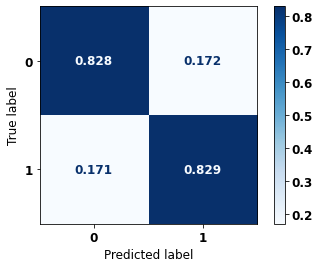


              precision    recall  f1-score   support

           0      0.906     0.828     0.865     84231
           1      0.708     0.829     0.764     42279

    accuracy                          0.828    126510
   macro avg      0.807     0.829     0.814    126510
weighted avg      0.840     0.828     0.831    126510



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 83% of accuracy.


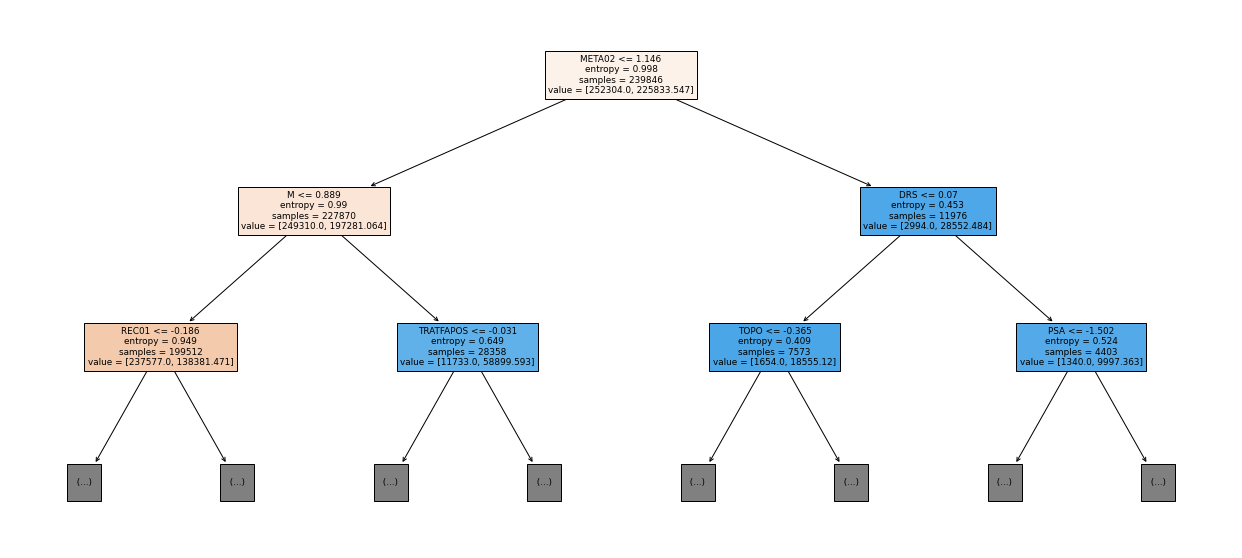

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

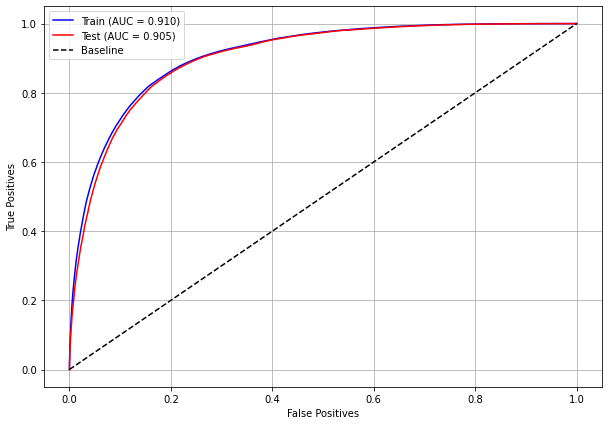

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

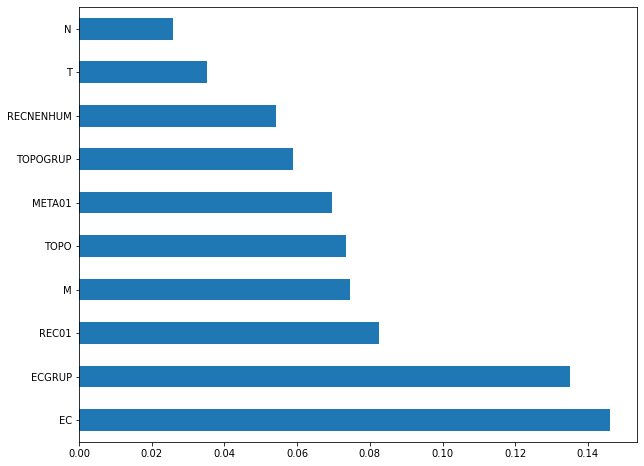

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `REC01` and `M`.

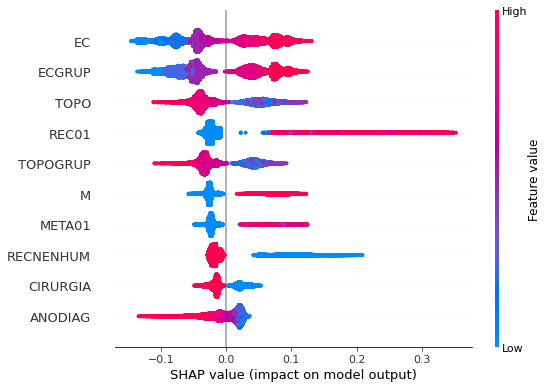

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1, 1:1.845}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.845}, criterion='entropy',
                       max_depth=8, random_state=10)

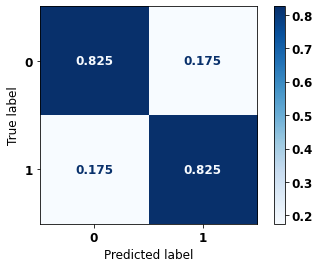


              precision    recall  f1-score   support

           0      0.914     0.825     0.867      5701
           1      0.676     0.825     0.743      2522

    accuracy                          0.825      8223
   macro avg      0.795     0.825     0.805      8223
weighted avg      0.841     0.825     0.829      8223



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm with the other states data shows a good performance of the model, because the model achieves a 82% of accuracy.


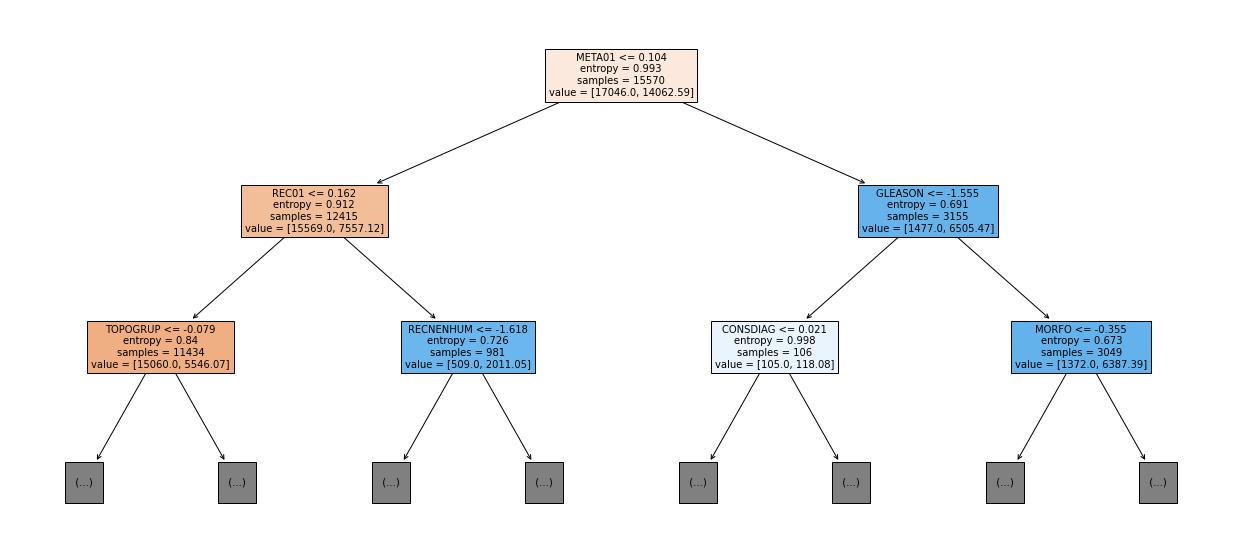

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

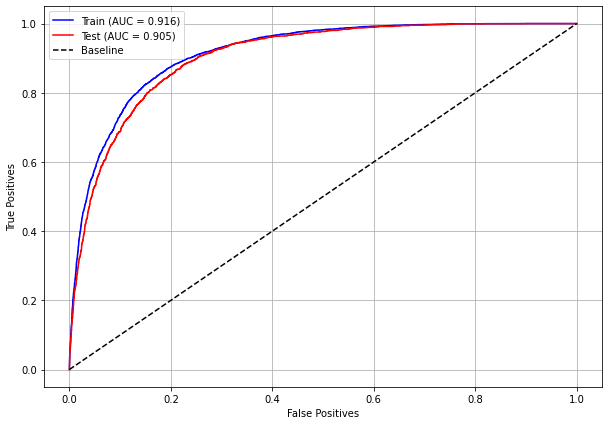

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

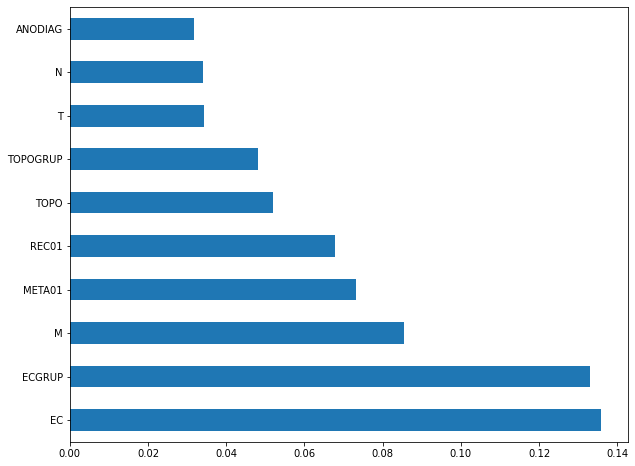

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `ECGRUP`, `M` and `META01`.

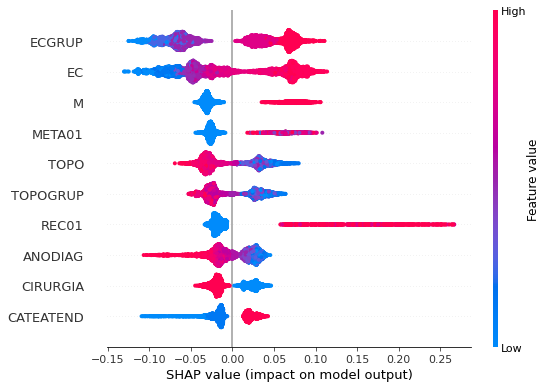

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Again larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 150, 200, 250],
           'max_depth': [5, 8, 10, 12, 15],
           'min_samples_split': [2, 5, 10, 15],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv=5, n_jobs=-1, 
                            random_state=seed)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# SP
rf_sp_opt = bestSP.best_estimator_
rf_sp_opt.set_params(class_weight={0:1, 1:1.85})

rf_sp_opt.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.85}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

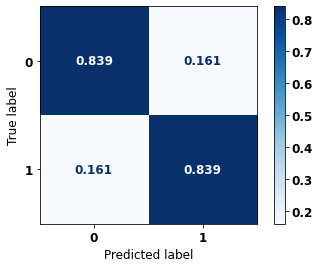


              precision    recall  f1-score   support

           0      0.912     0.839     0.874     84231
           1      0.723     0.839     0.777     42279

    accuracy                          0.839    126510
   macro avg      0.818     0.839     0.825    126510
weighted avg      0.849     0.839     0.842    126510



In [ ]:
display_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# Other states
rf_fora_opt = bestOS.best_estimator_
rf_fora_opt.set_params(class_weight={0:1, 1:2.58})

rf_fora_opt.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 2.58}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

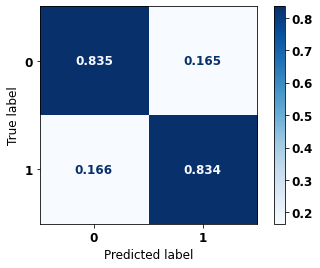


              precision    recall  f1-score   support

           0      0.919     0.835     0.875      5701
           1      0.691     0.834     0.756      2522

    accuracy                          0.835      8223
   macro avg      0.805     0.835     0.815      8223
weighted avg      0.849     0.835     0.839      8223



In [ ]:
display_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.89,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.89)

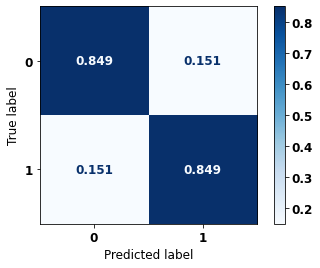


              precision    recall  f1-score   support

           0      0.918     0.849     0.882     84231
           1      0.738     0.849     0.790     42279

    accuracy                          0.849    126510
   macro avg      0.828     0.849     0.836    126510
weighted avg      0.858     0.849     0.851    126510



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, also shows a good performance of the model, with 85% of accuracy.


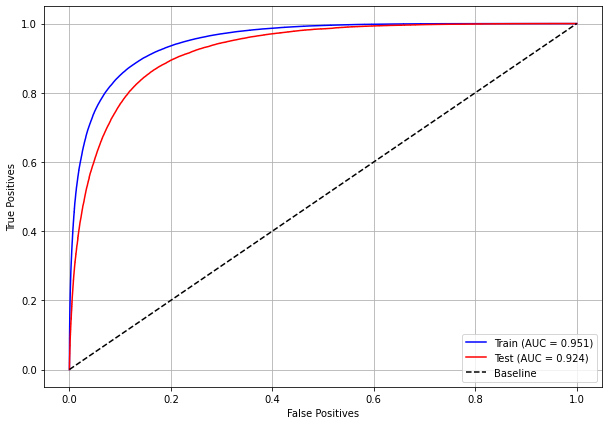

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

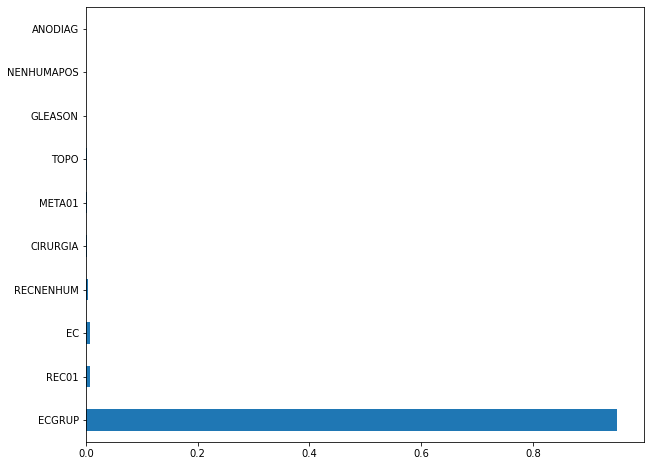

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, with a lot advantage over the others, `REC01`, `EC` and `RECNENHUM`.

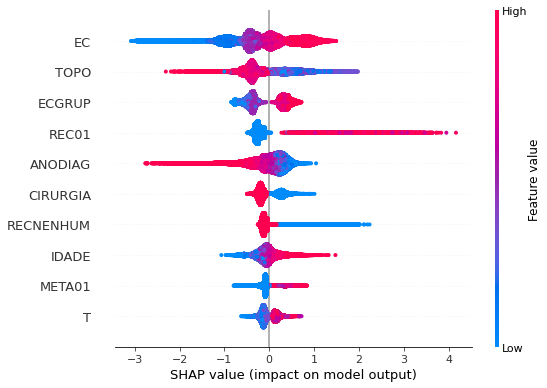

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=6, 
                             scale_pos_weight=2,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2)

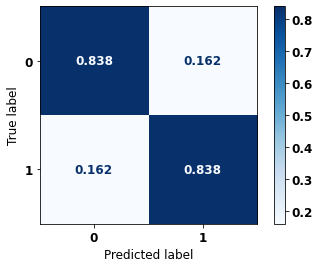


              precision    recall  f1-score   support

           0      0.921     0.838     0.878      5701
           1      0.696     0.838     0.761      2522

    accuracy                          0.838      8223
   macro avg      0.809     0.838     0.819      8223
weighted avg      0.852     0.838     0.842      8223



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm with SP data shows a good performance of the model, because the model achieves a 84% of accuracy.


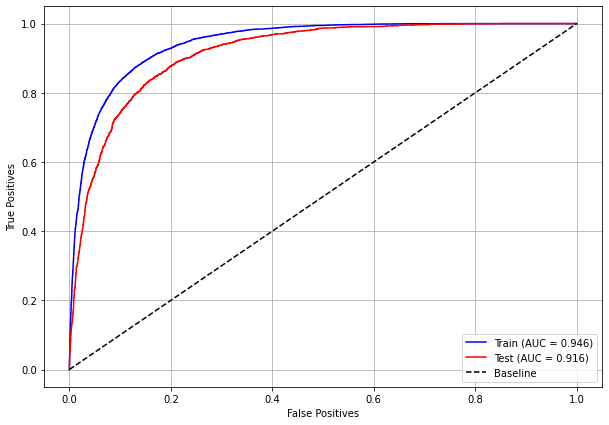

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

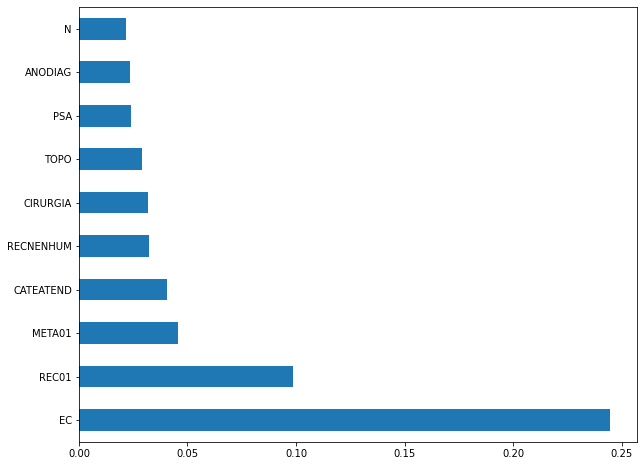

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `EC`, with a good advantage, `REC01`, `META01` and `CATEATEND`.

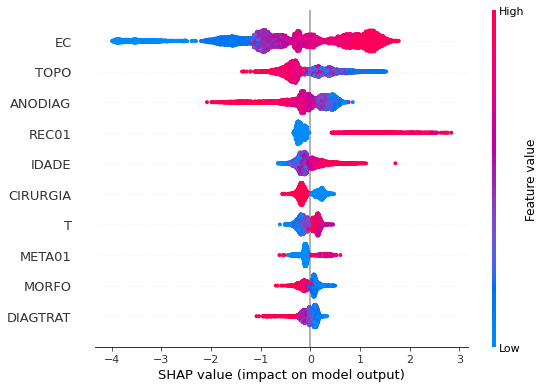

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
            'max_depth': [5, 8, 10, 12, 15],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            'n_estimators': [100, 150, 200, 250]}

xgboost = XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv=5, n_jobs=-1, 
                           random_state=seed)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# SP
xgb_sp_opt = bestSP.best_estimator_
xgb_sp_opt.set_params(scale_pos_weight=1.88)

xgb_sp_opt.fit(X_train_SP, y_train_SP)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, max_depth=10, min_child_weight=5,
              n_estimators=200, random_state=10, scale_pos_weight=1.88)

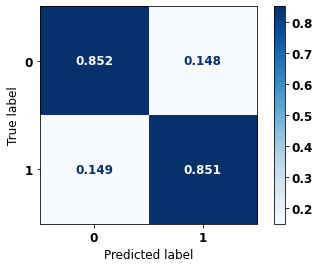


              precision    recall  f1-score   support

           0      0.919     0.852     0.884     84231
           1      0.742     0.851     0.793     42279

    accuracy                          0.851    126510
   macro avg      0.831     0.851     0.839    126510
weighted avg      0.860     0.851     0.854    126510



In [ ]:
display_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 150,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# Other states
xgb_fora_opt = bestOS.best_estimator_
xgb_fora_opt.set_params(scale_pos_weight=1.99)

xgb_fora_opt.fit(X_train_OS, y_train_OS)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=5,
              n_estimators=150, random_state=10, scale_pos_weight=1.99)

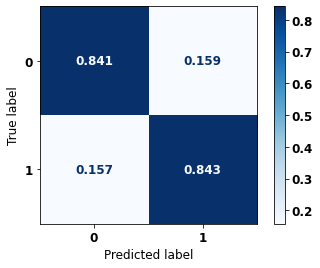


              precision    recall  f1-score   support

           0      0.923     0.841     0.880      5701
           1      0.700     0.843     0.765      2522

    accuracy                          0.841      8223
   macro avg      0.812     0.842     0.823      8223
weighted avg      0.855     0.841     0.845      8223



In [ ]:
display_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS)

# **Second approach**

Approach using only morphologies with final digit equal to 3 and without `EC` column as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (351486, 65), X_test = (117163, 65)
y_train = (351486,), y_test = (117163,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (23079, 65), X_test = (7693, 65)
y_train = (23079,), y_test = (7693,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:1, 1:1.685},
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.685}, criterion='entropy',
                       max_depth=10, random_state=10)

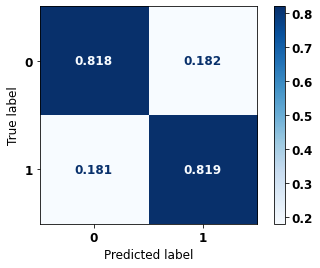


              precision    recall  f1-score   support

           0      0.890     0.818     0.853     75153
           1      0.716     0.819     0.764     42010

    accuracy                          0.818    117163
   macro avg      0.803     0.819     0.808    117163
weighted avg      0.828     0.818     0.821    117163



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, also shows a good performance of the model, with 82% of accuracy.


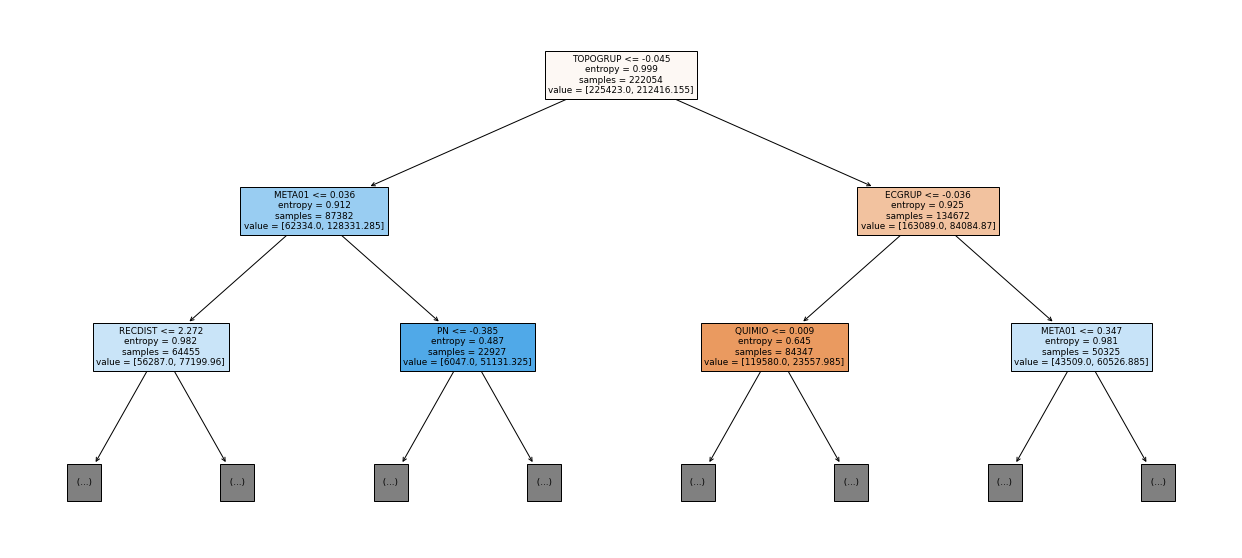

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

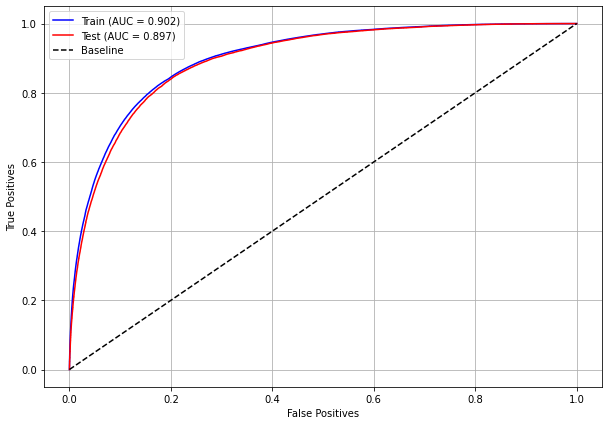

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

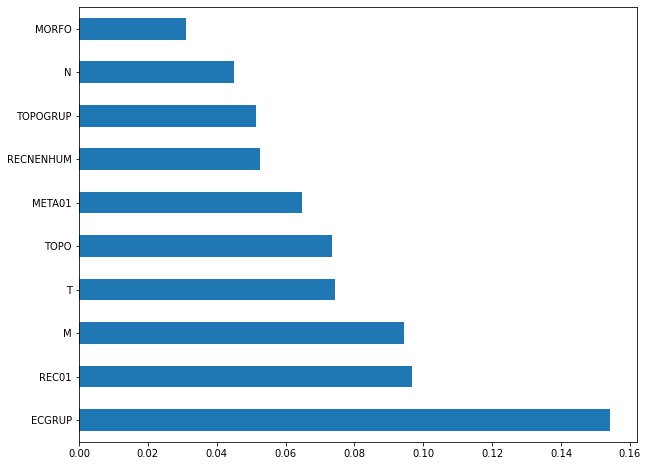

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `T`.

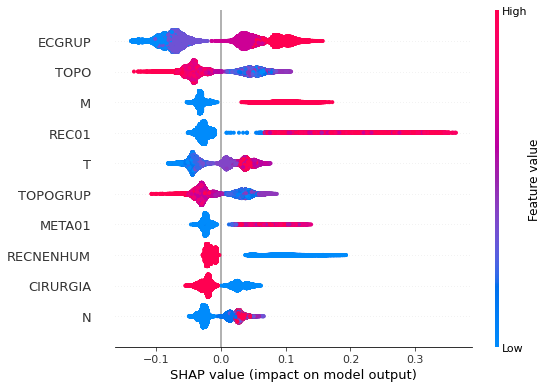

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:1, 1:1.735},
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.735}, criterion='entropy',
                       max_depth=8, random_state=10)

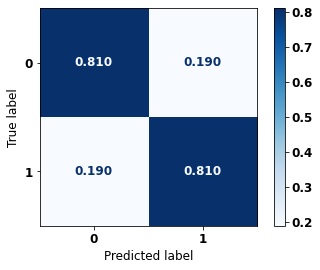


              precision    recall  f1-score   support

           0      0.898     0.810     0.852      5176
           1      0.675     0.810     0.736      2517

    accuracy                          0.810      7693
   macro avg      0.786     0.810     0.794      7693
weighted avg      0.825     0.810     0.814      7693



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm with other states data shows a good performance of the model, because the model achieves a 81% of accuracy.


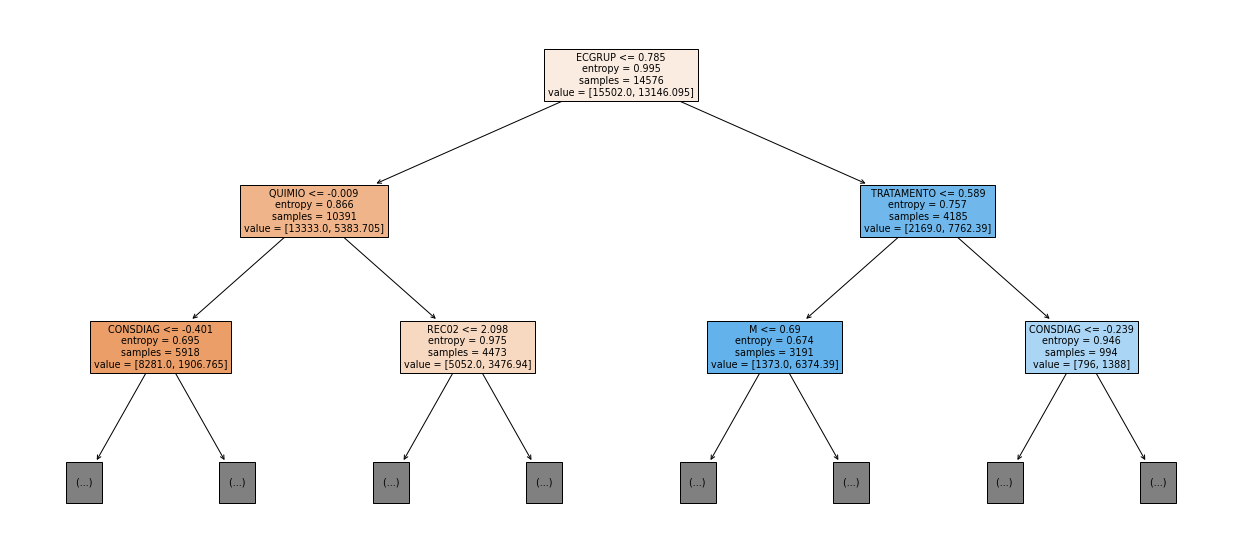

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

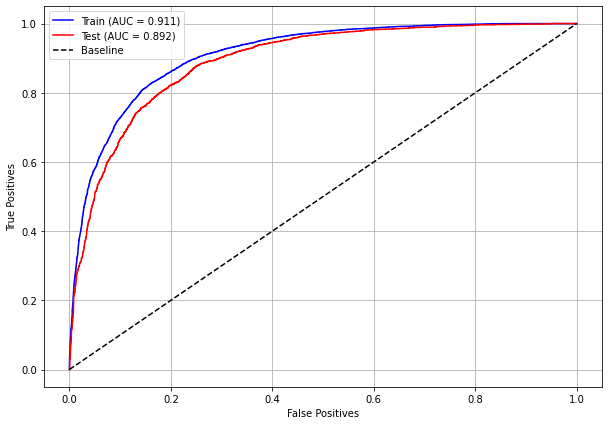

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

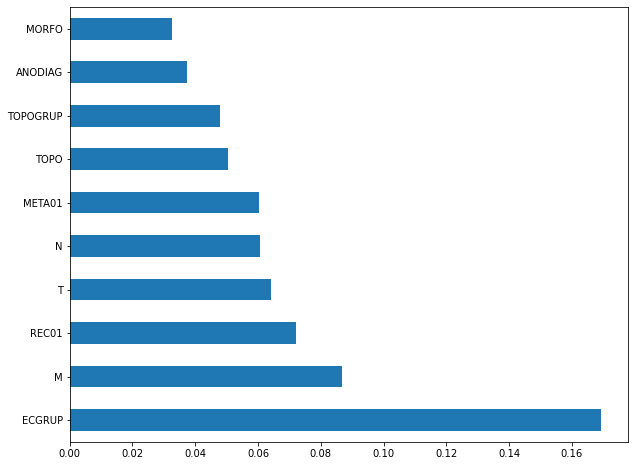

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `REC01` and `T`.

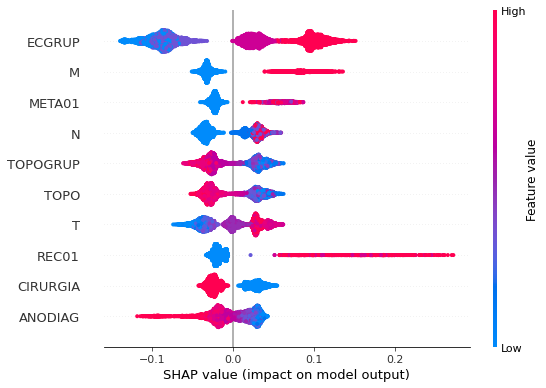

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.7,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.7)

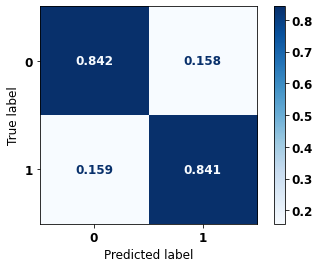


              precision    recall  f1-score   support

           0      0.904     0.842     0.872     75153
           1      0.749     0.841     0.792     42010

    accuracy                          0.842    117163
   macro avg      0.826     0.841     0.832    117163
weighted avg      0.848     0.842     0.843    117163



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, also shows a good performance of the model, with 84% of accuracy.


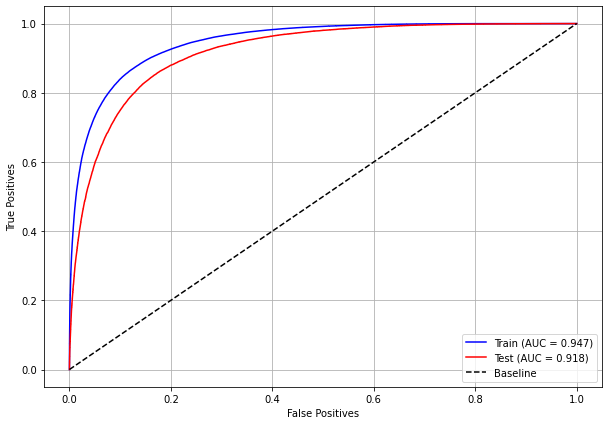

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

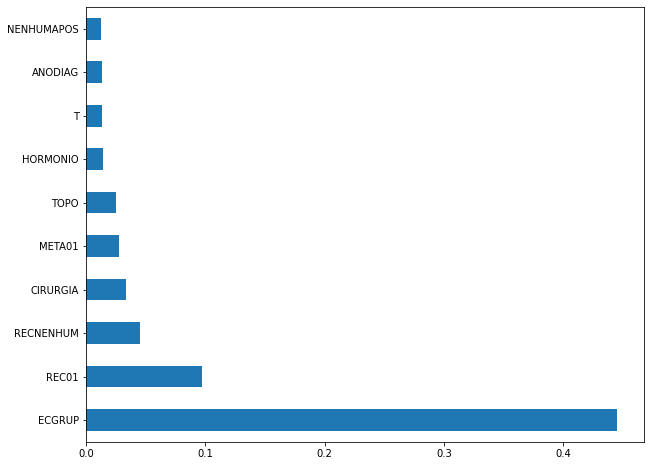

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `REC01`, `RECNENHUM` and `CIRURGIA`.

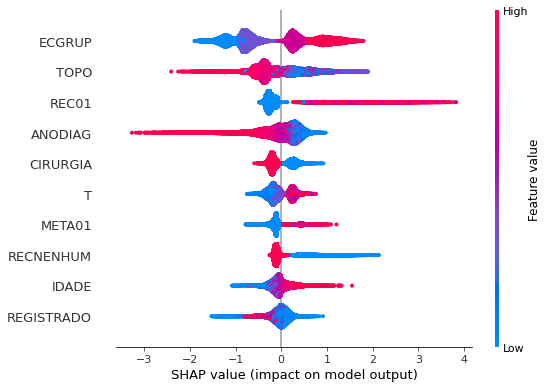

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=6, 
                             scale_pos_weight=1.87,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.87)

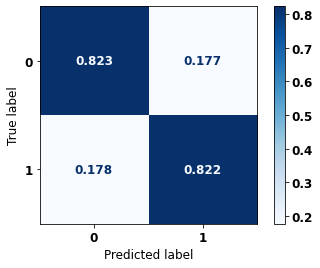


              precision    recall  f1-score   support

           0      0.905     0.823     0.862      5176
           1      0.693     0.822     0.752      2517

    accuracy                          0.823      7693
   macro avg      0.799     0.823     0.807      7693
weighted avg      0.836     0.823     0.826      7693



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm with SP data shows a good performance of the model, because the model achieves a 82% of accuracy.


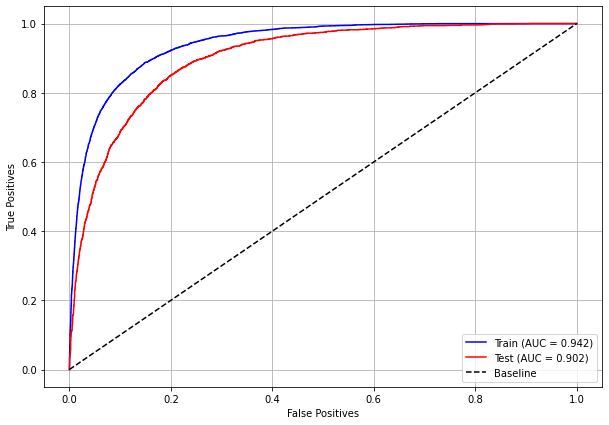

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

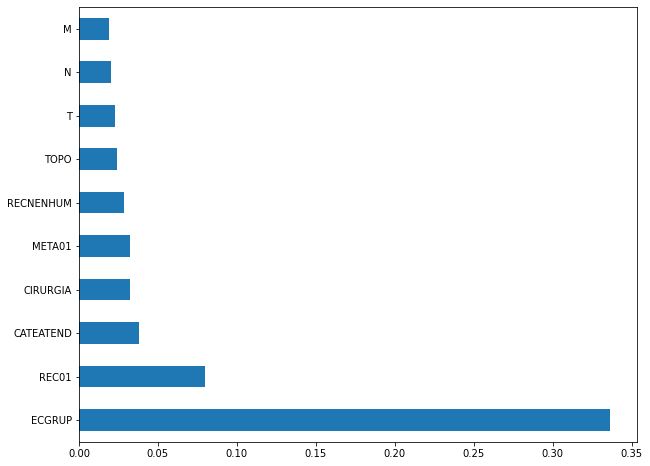

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `REC01`, `CATEATEND` and `CIRURGIA`.

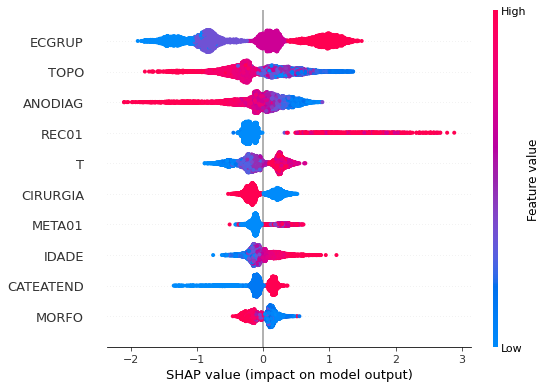

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

# **Third approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (49873, 65), X_test = (16625, 65)
y_train = (49873,), y_test = (16625,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (62658, 65), X_test = (20887, 65)
y_train = (62658,), y_test = (20887,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (83228, 65), X_test = (27743, 65)
y_train = (83228,), y_test = (27743,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (103890, 65), X_test = (34630, 65)
y_train = (103890,), y_test = (34630,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2021, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (79877, 65), X_test = (26626, 65)
y_train = (79877,), y_test = (26626,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2802, 65), X_test = (935, 65)
y_train = (2802,), y_test = (935,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3942, 65), X_test = (1315, 65)
y_train = (3942,), y_test = (1315,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4842, 65), X_test = (1614, 65)
y_train = (4842,), y_test = (1614,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6456, 65), X_test = (2153, 65)
y_train = (6456,), y_test = (2153,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2020, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6624, 65), X_test = (2208, 65)
y_train = (6624,), y_test = (2208,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models still have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.193},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.193}, criterion='entropy',
                       max_depth=10, random_state=10)

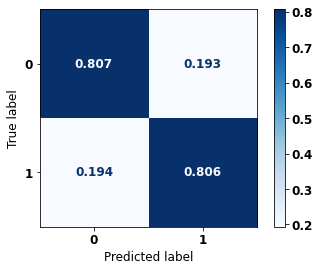


              precision    recall  f1-score   support

           0      0.837     0.807     0.821      9182
           1      0.772     0.806     0.788      7443

    accuracy                          0.806     16625
   macro avg      0.804     0.806     0.805     16625
weighted avg      0.808     0.806     0.807     16625



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 81% of accuracy.


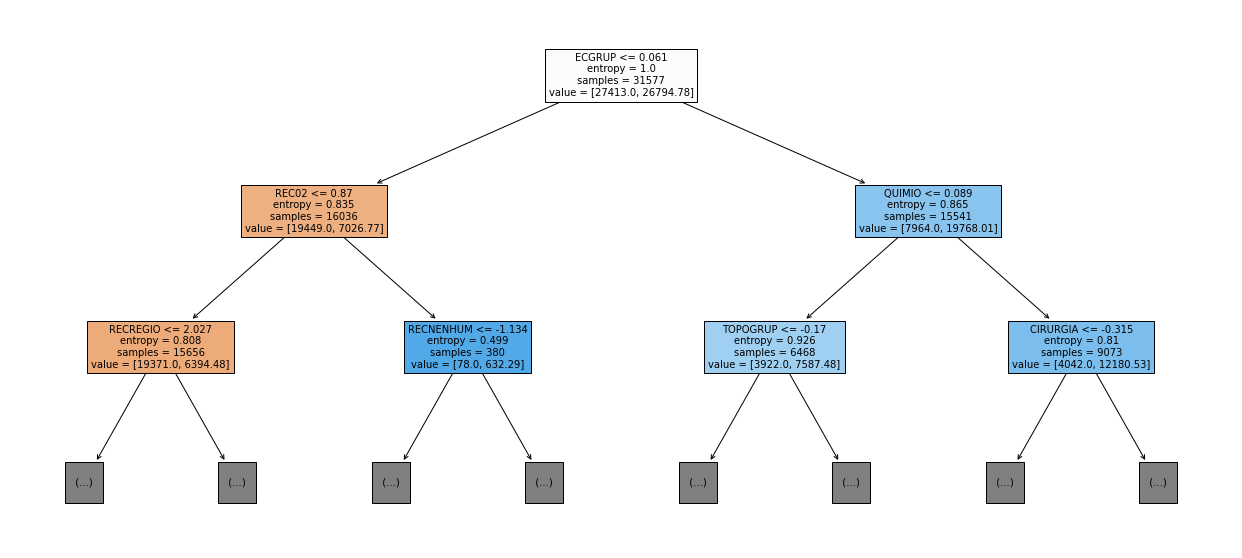

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

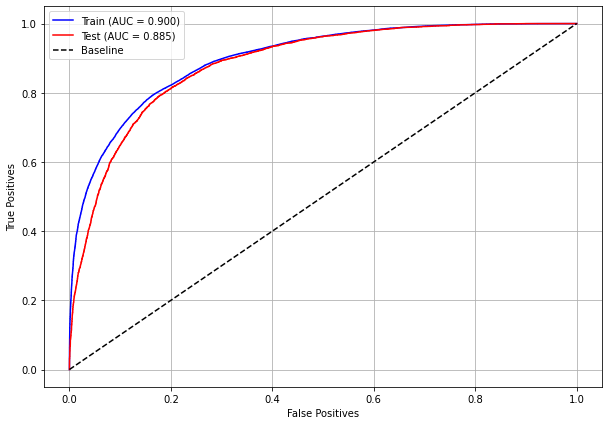

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

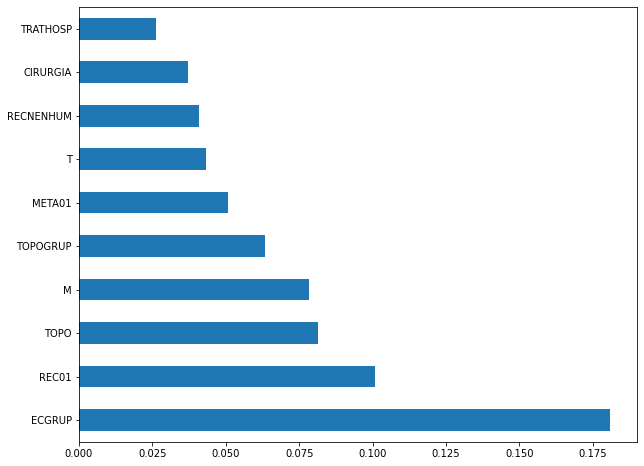

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `REC01`, `TOPO`, and `M`. 

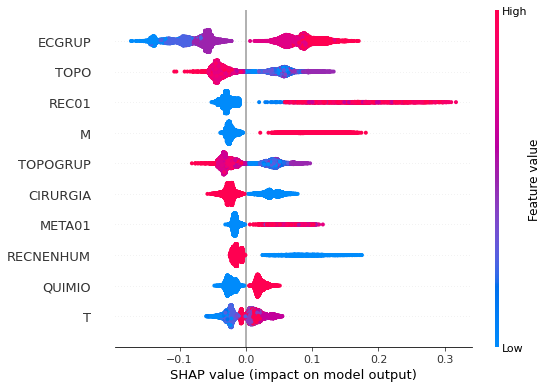

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.33},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.33}, criterion='entropy',
                       max_depth=10, random_state=10)

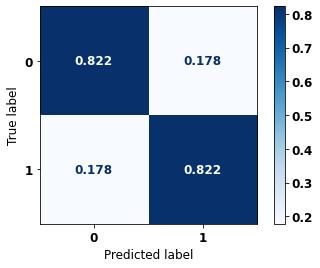


              precision    recall  f1-score   support

           0      0.870     0.822     0.845     12359
           1      0.761     0.822     0.790      8528

    accuracy                          0.822     20887
   macro avg      0.816     0.822     0.818     20887
weighted avg      0.826     0.822     0.823     20887



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 82% of accuracy.

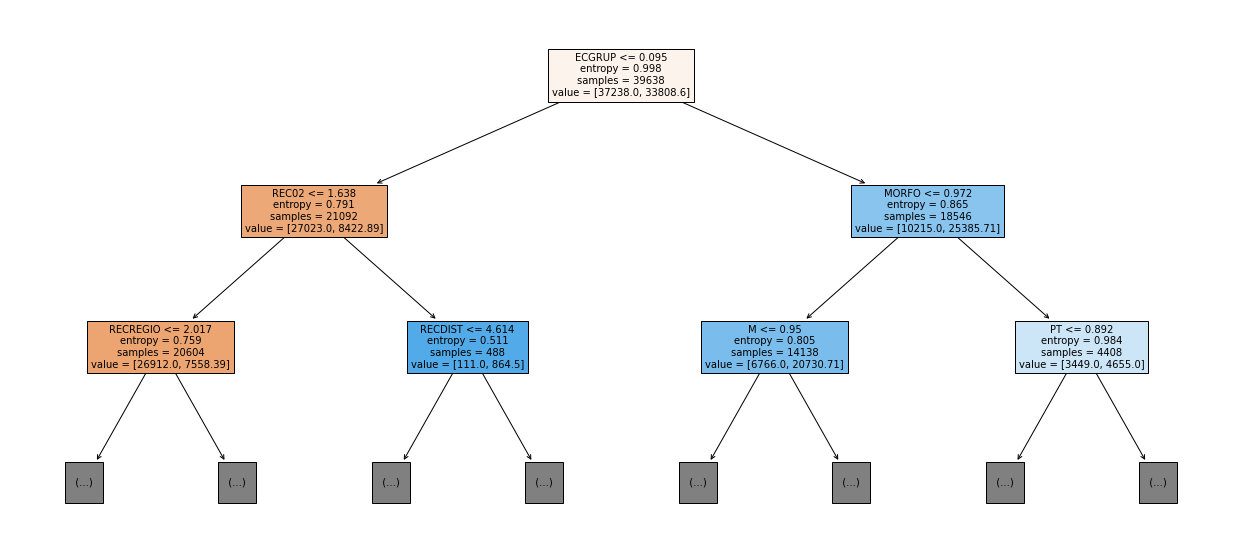

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

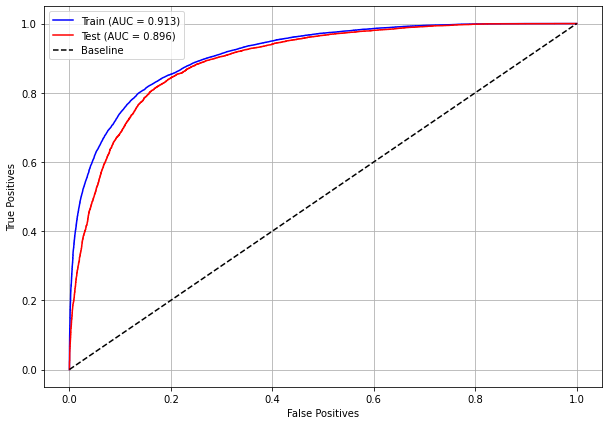

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

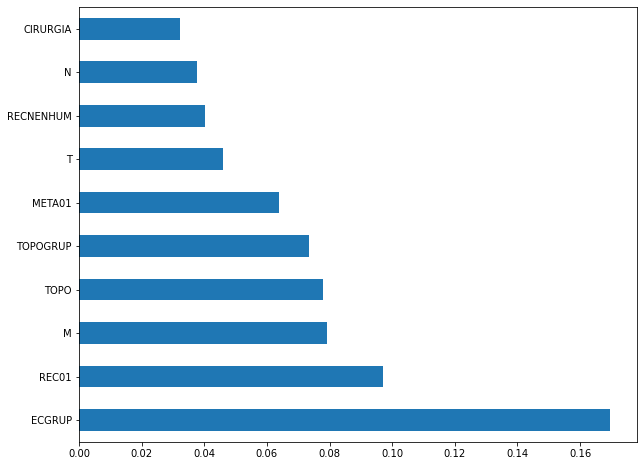

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `TOPO`.

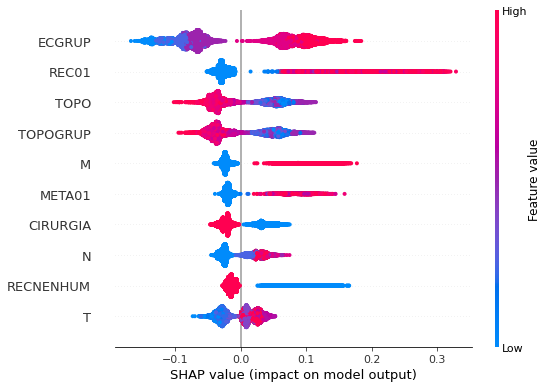

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.5995},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.5995}, criterion='entropy',
                       max_depth=10, random_state=10)

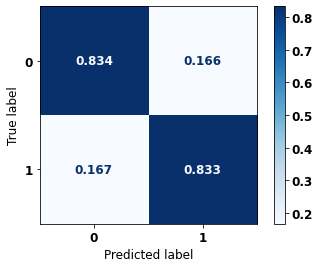


              precision    recall  f1-score   support

           0      0.896     0.834     0.864     17549
           1      0.744     0.833     0.786     10194

    accuracy                          0.833     27743
   macro avg      0.820     0.833     0.825     27743
weighted avg      0.840     0.833     0.835     27743



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

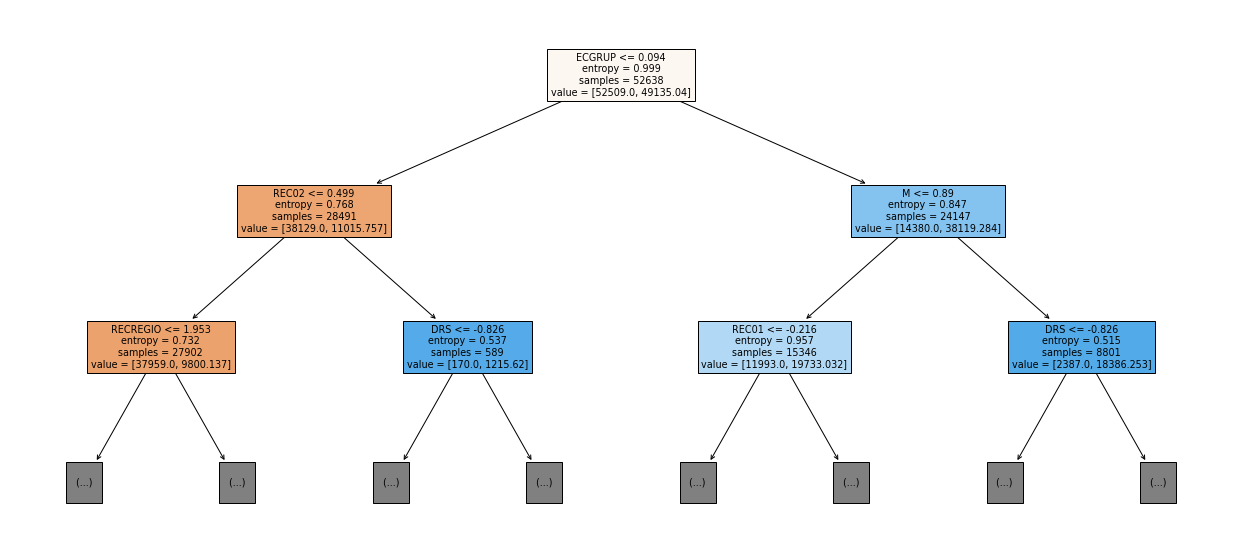

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

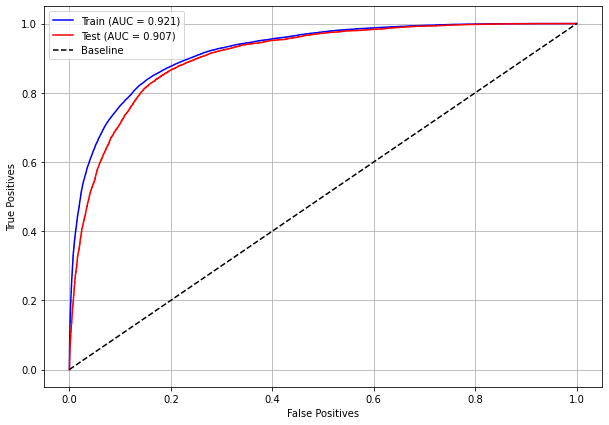

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

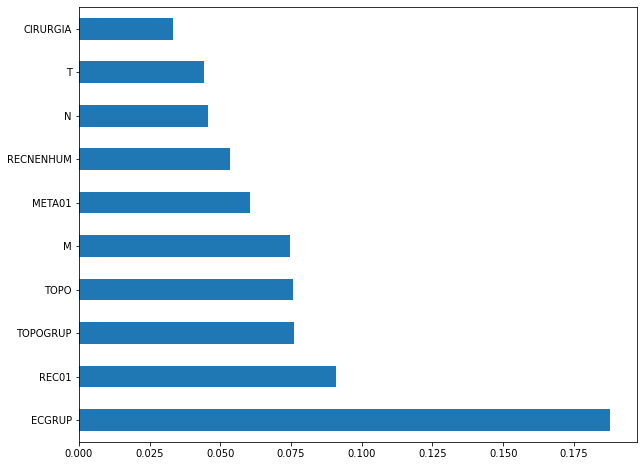

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `REC01`, `TOPOGRUP` and `TOPO`.

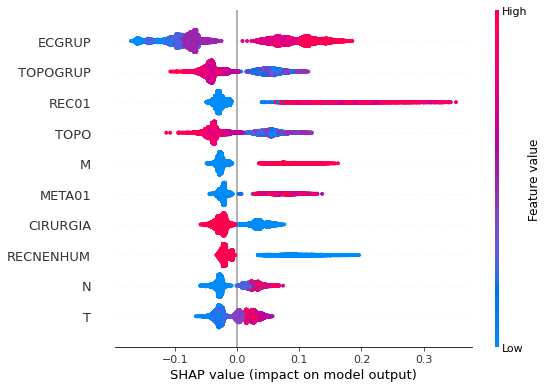

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.218},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.218}, criterion='entropy',
                       max_depth=10, random_state=10)

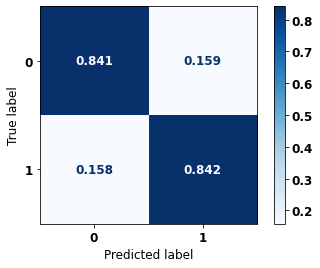


              precision    recall  f1-score   support

           0      0.926     0.841     0.882     24340
           1      0.692     0.842     0.760     10290

    accuracy                          0.842     34630
   macro avg      0.809     0.842     0.821     34630
weighted avg      0.857     0.842     0.846     34630



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 84% of accuracy.

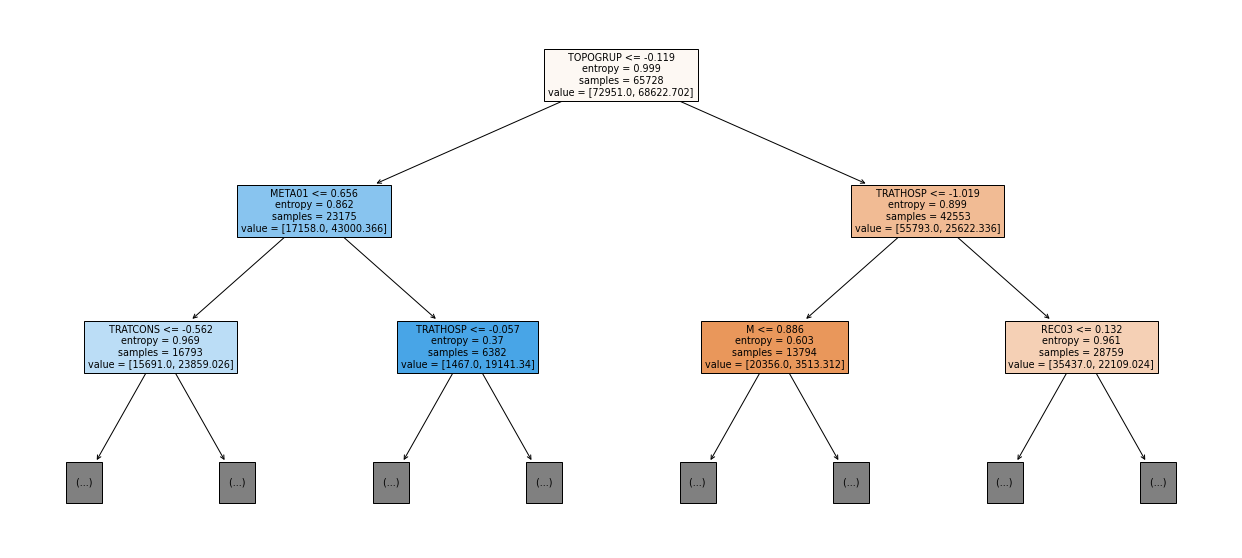

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

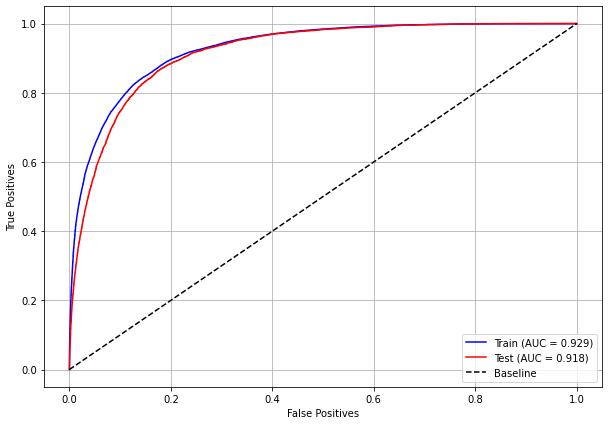

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

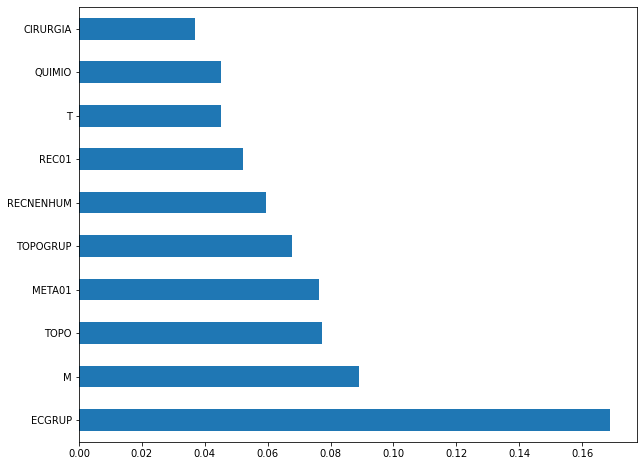

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `META01`.

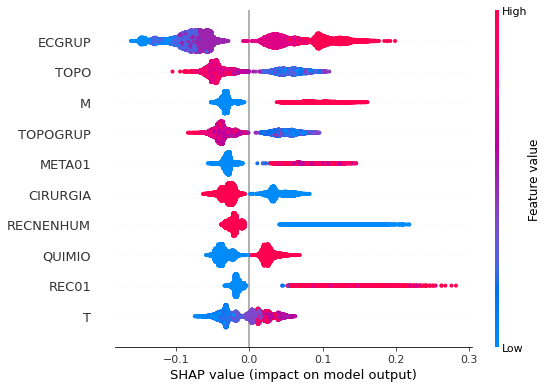

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:3.362},
                                     criterion='entropy', 
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 3.362}, criterion='entropy',
                       max_depth=10, random_state=10)

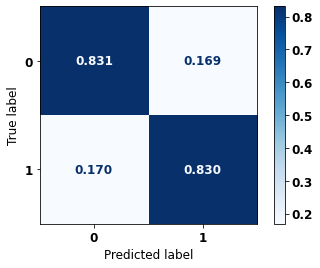


              precision    recall  f1-score   support

           0      0.946     0.831     0.885     20801
           1      0.579     0.830     0.682      5825

    accuracy                          0.831     26626
   macro avg      0.763     0.831     0.784     26626
weighted avg      0.866     0.831     0.840     26626



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 83% of accuracy.

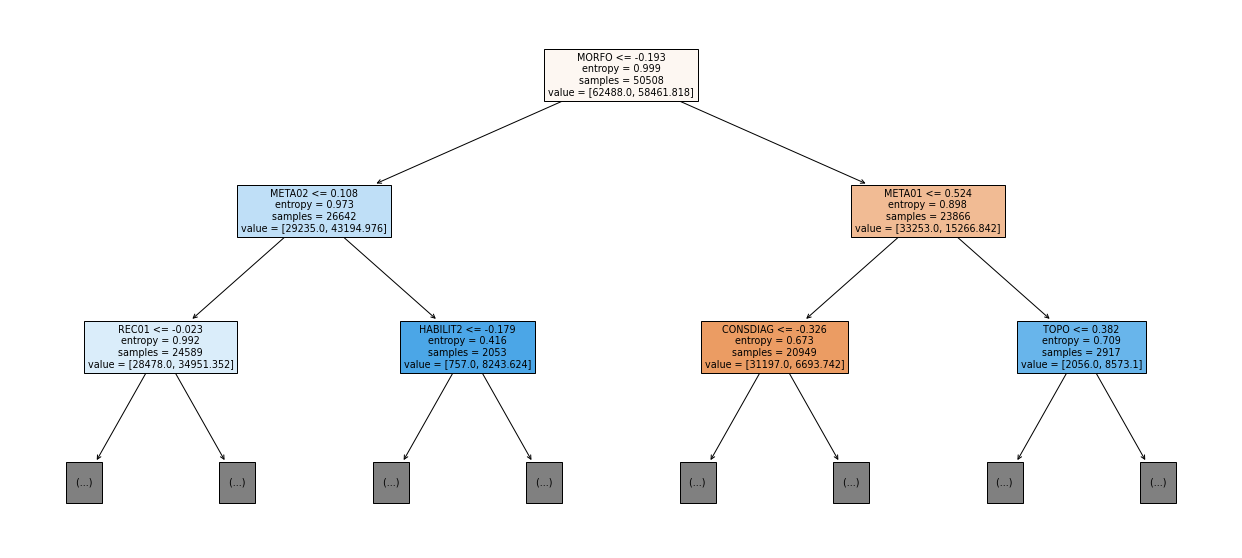

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

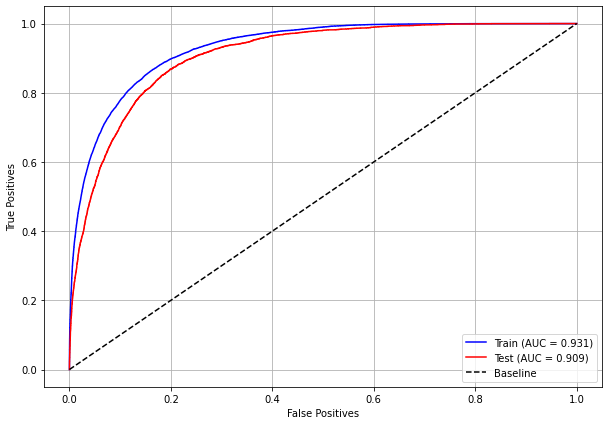

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

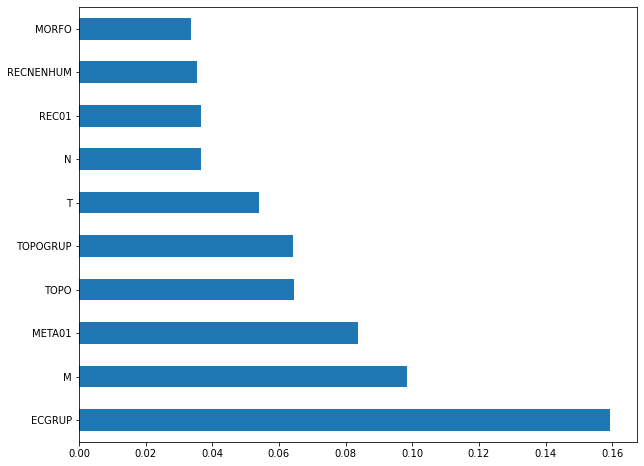

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `META01`, and `TOPO`.



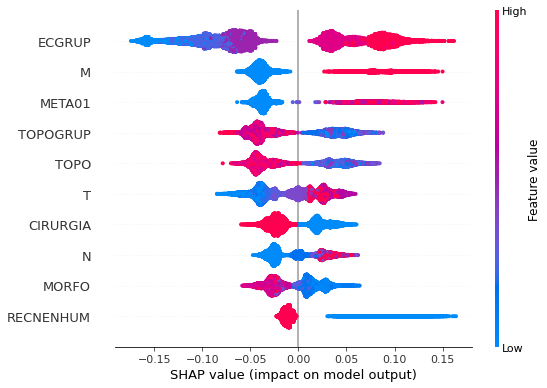

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.72},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.72}, criterion='entropy',
                       max_depth=6, random_state=10)

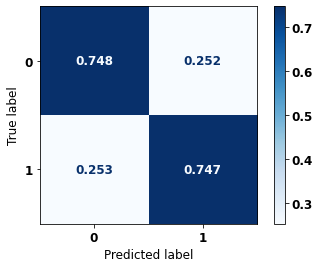


              precision    recall  f1-score   support

           0      0.817     0.748     0.781       563
           1      0.662     0.747     0.702       372

    accuracy                          0.748       935
   macro avg      0.740     0.748     0.742       935
weighted avg      0.756     0.748     0.750       935



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 75% of accuracy.

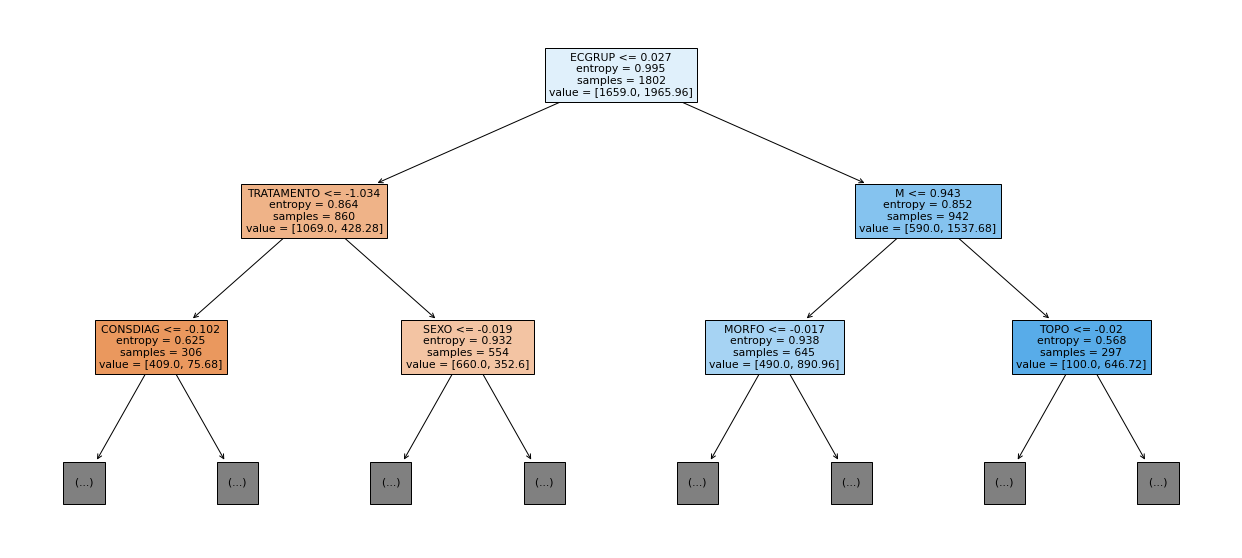

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

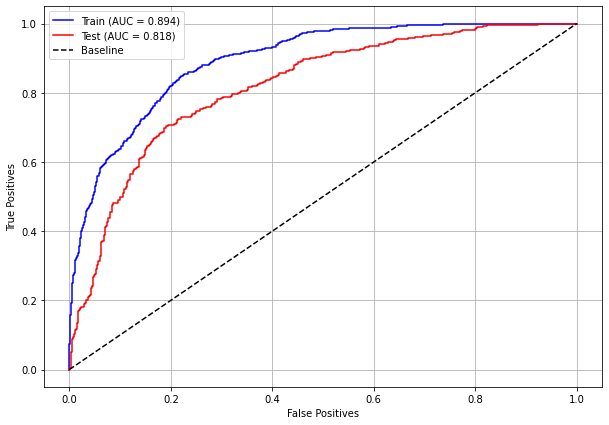

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

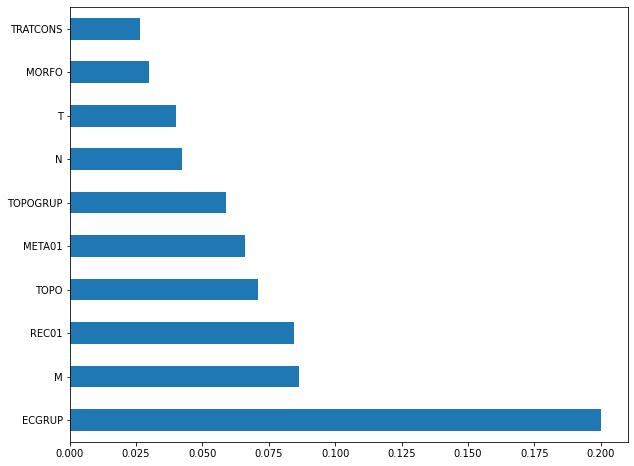

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `M`, `REC01` and `TOPO`.

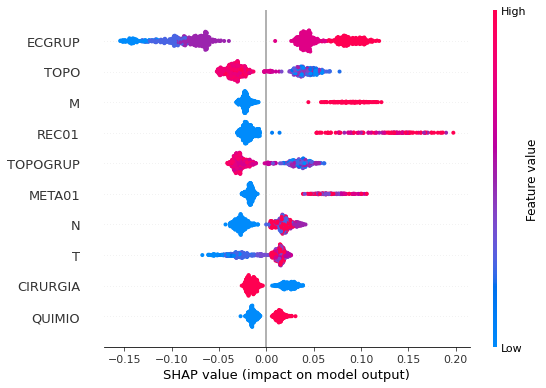

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.445},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.445}, criterion='entropy',
                       max_depth=6, random_state=10)

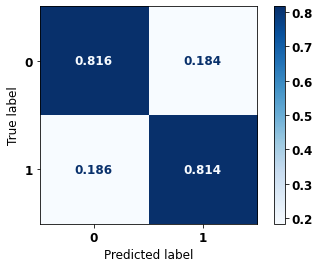


              precision    recall  f1-score   support

           0      0.874     0.816     0.844       805
           1      0.737     0.814     0.774       510

    accuracy                          0.815      1315
   macro avg      0.805     0.815     0.809      1315
weighted avg      0.821     0.815     0.817      1315



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 81% of accuracy.


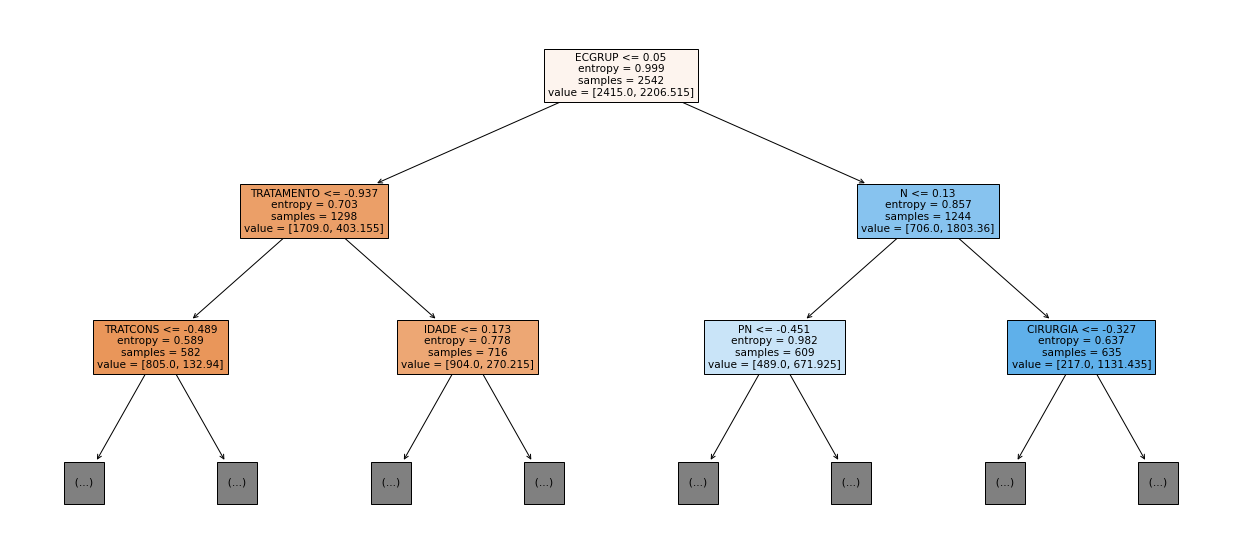

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

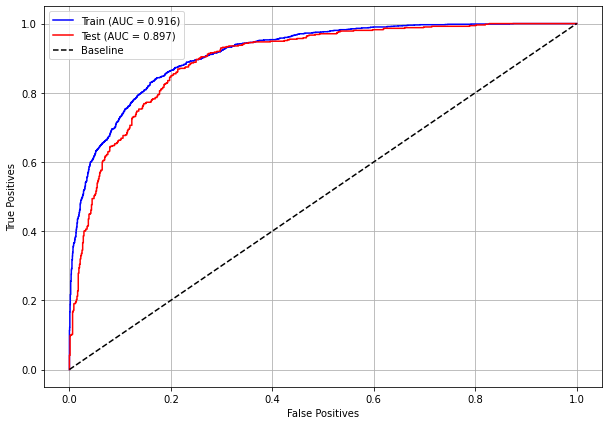

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

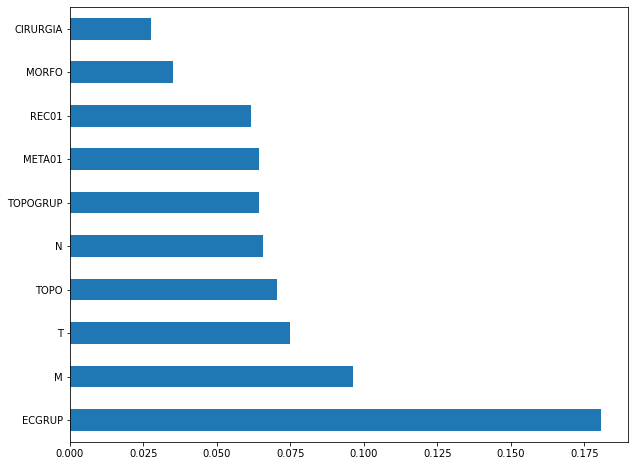

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `TOPO`.

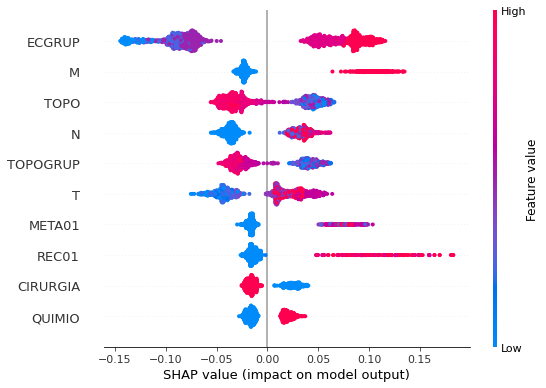

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.75},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.75}, criterion='entropy',
                       max_depth=6, random_state=10)

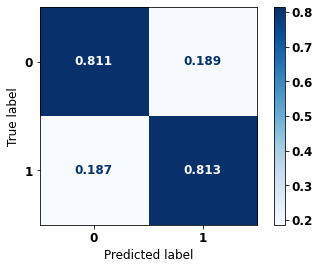


              precision    recall  f1-score   support

           0      0.893     0.811     0.850      1062
           1      0.691     0.813     0.747       552

    accuracy                          0.812      1614
   macro avg      0.792     0.812     0.799      1614
weighted avg      0.824     0.812     0.815      1614



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


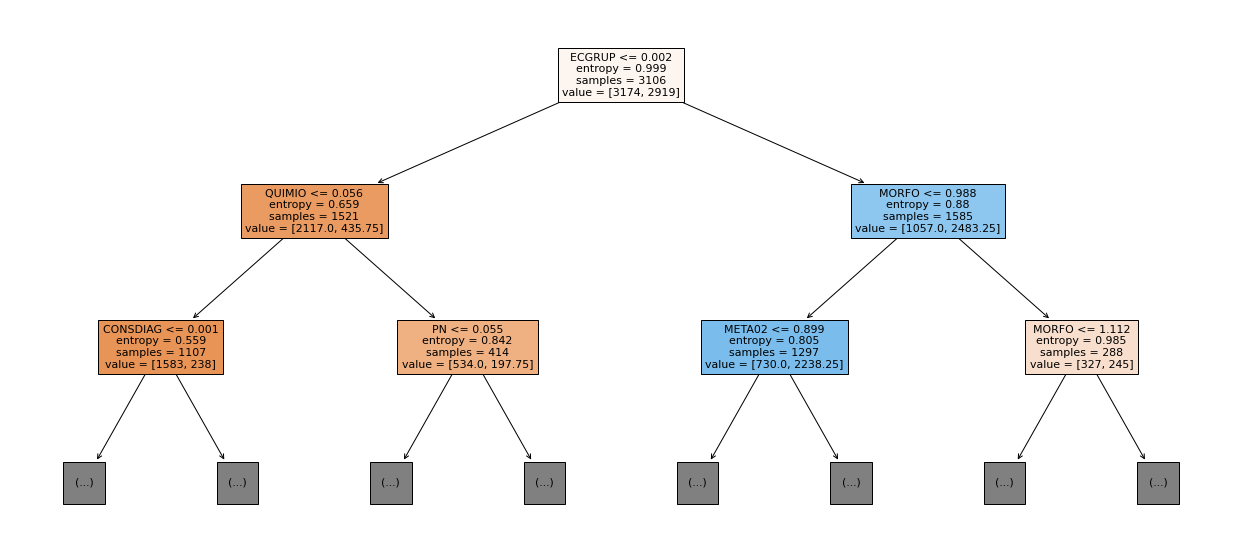

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

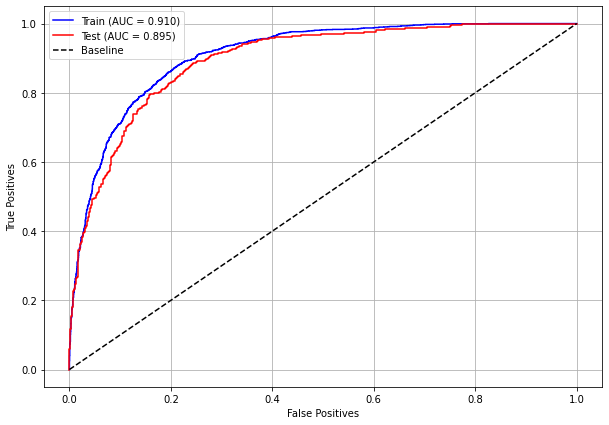

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

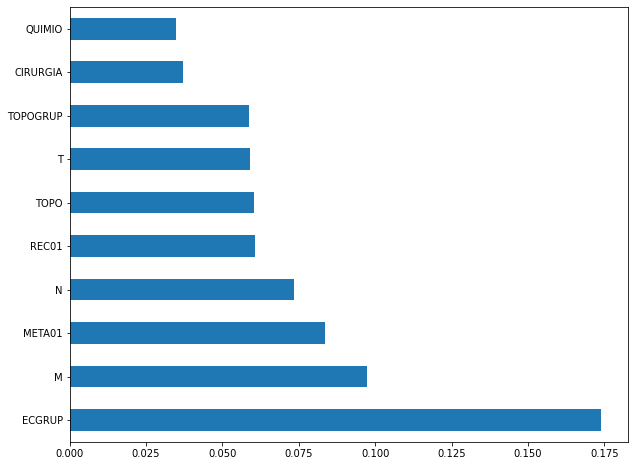

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `N`.

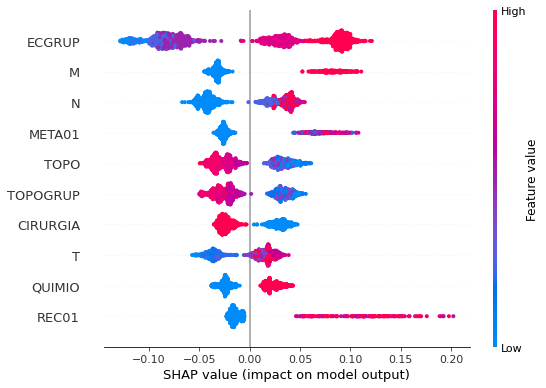

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.8},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.8}, criterion='entropy',
                       max_depth=8, random_state=10)

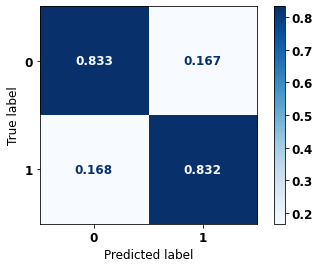


              precision    recall  f1-score   support

           0      0.929     0.833     0.879      1563
           1      0.653     0.832     0.732       590

    accuracy                          0.833      2153
   macro avg      0.791     0.833     0.805      2153
weighted avg      0.854     0.833     0.838      2153



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


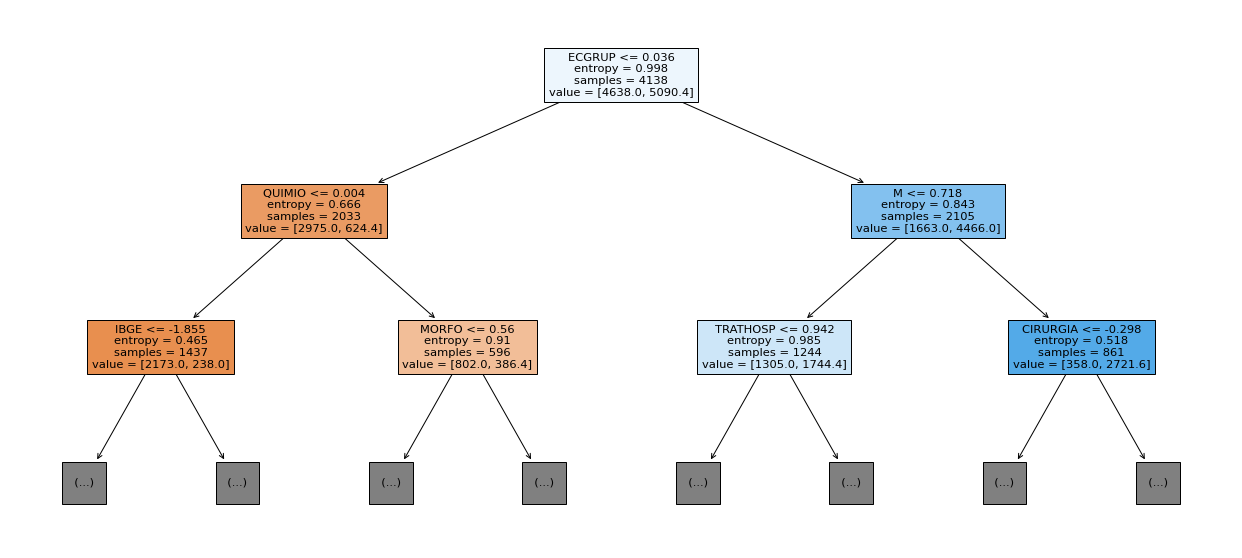

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

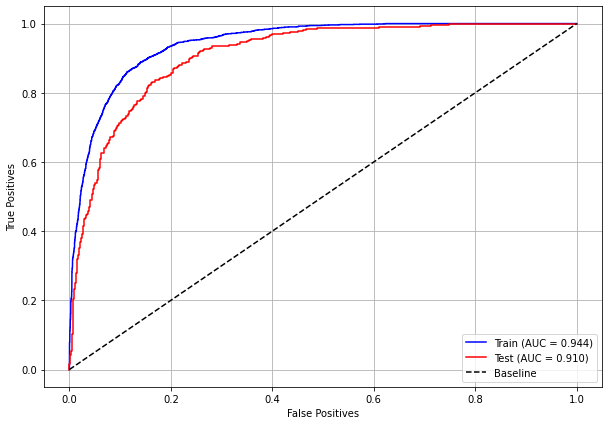

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

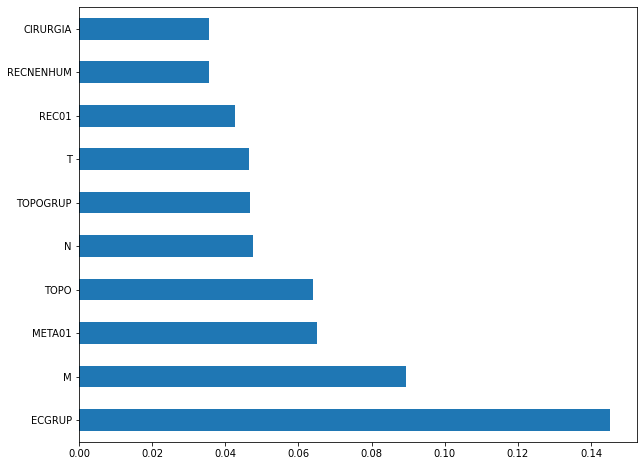

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `TOPO`.

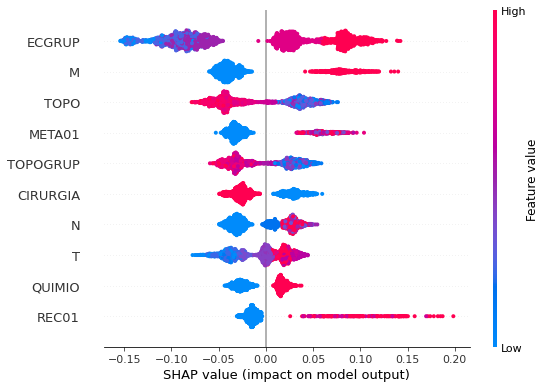

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:3.9},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 3.9}, criterion='entropy',
                       max_depth=8, random_state=10)

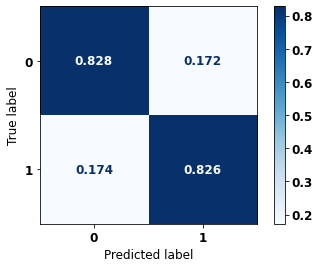


              precision    recall  f1-score   support

           0      0.942     0.828     0.881      1709
           1      0.584     0.826     0.684       499

    accuracy                          0.827      2208
   macro avg      0.763     0.827     0.783      2208
weighted avg      0.861     0.827     0.837      2208



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 83% of accuracy.


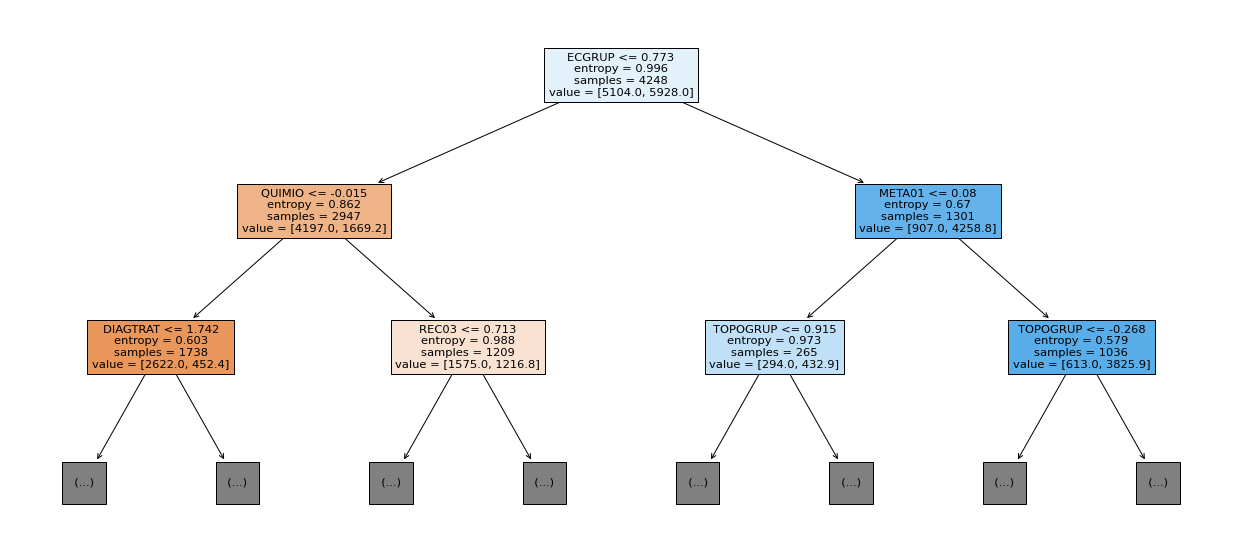

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

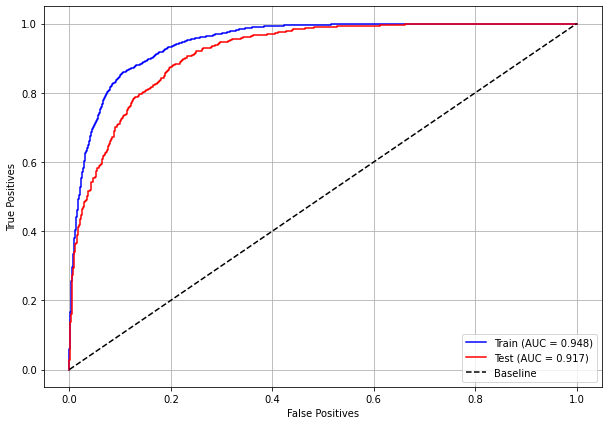

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

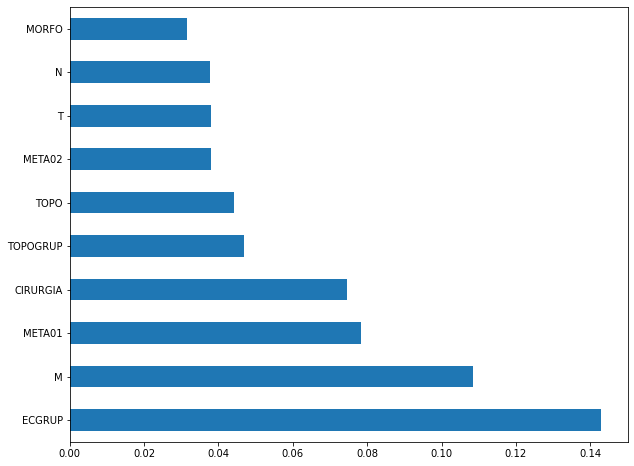

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `CIRURGIA`.

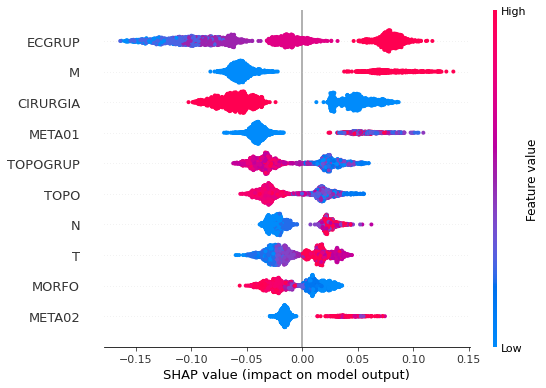

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.21)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.21)

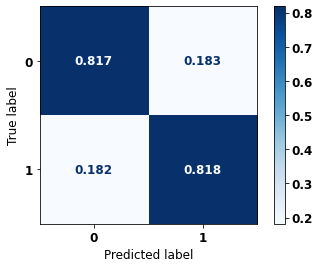


              precision    recall  f1-score   support

           0      0.847     0.817     0.832      9182
           1      0.783     0.818     0.800      7443

    accuracy                          0.817     16625
   macro avg      0.815     0.817     0.816     16625
weighted avg      0.819     0.817     0.818     16625



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 82% of accuracy.

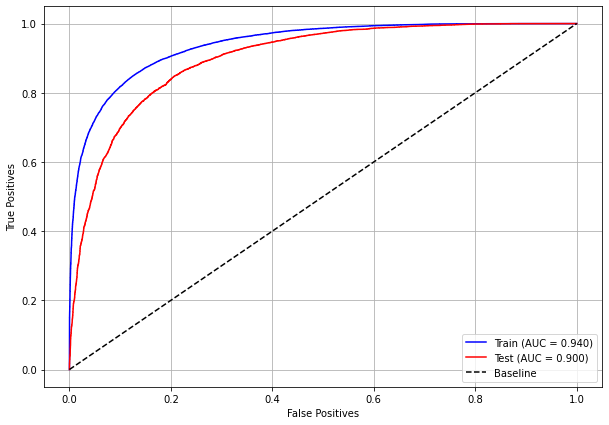

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

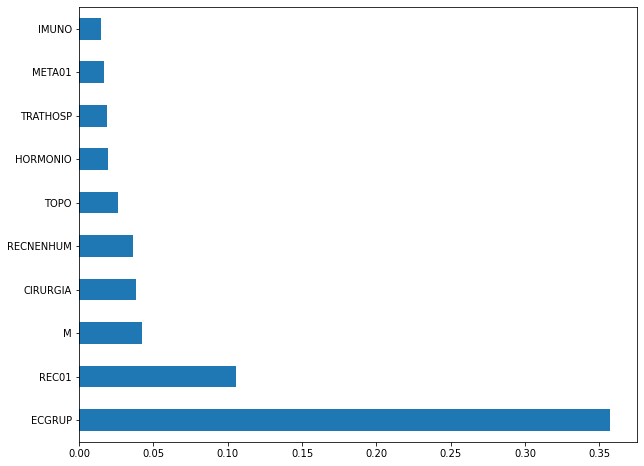

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `REC01`, `M` and `CIRURGIA`.

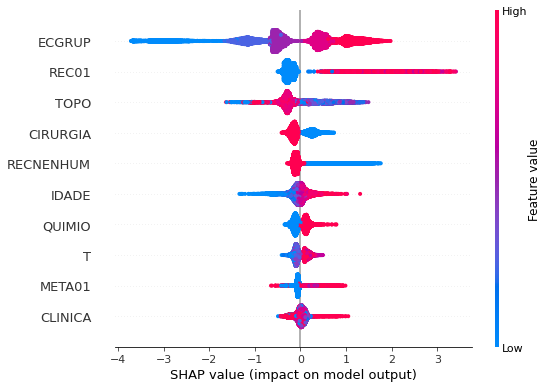

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.42)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.42)

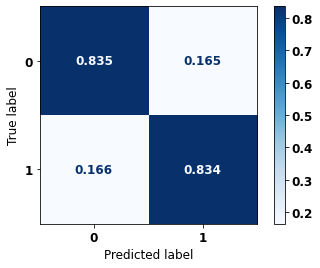


              precision    recall  f1-score   support

           0      0.880     0.835     0.857     12359
           1      0.778     0.834     0.805      8528

    accuracy                          0.835     20887
   macro avg      0.829     0.835     0.831     20887
weighted avg      0.838     0.835     0.836     20887



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 83% of accuracy.


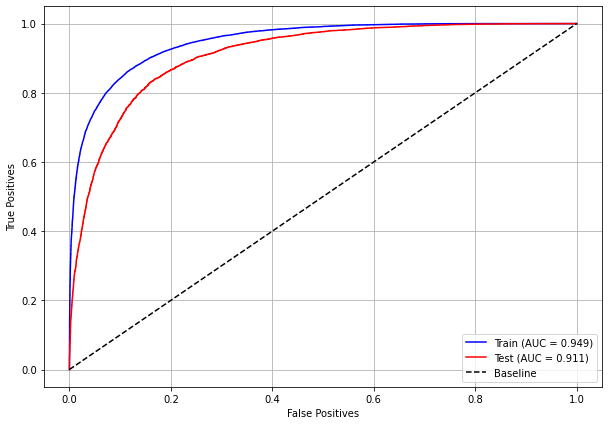

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

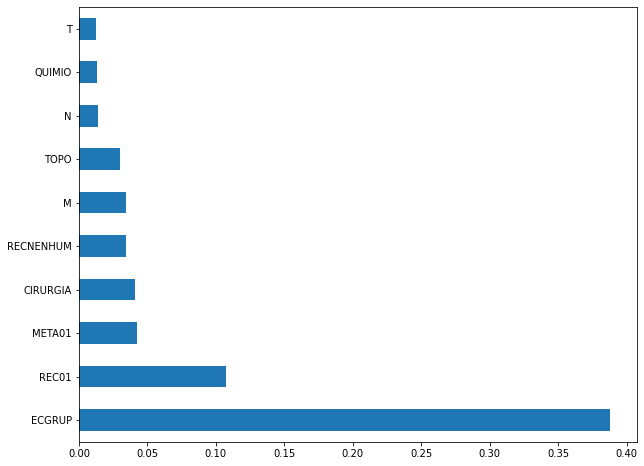

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `META01` and `CIRURGIA`. 

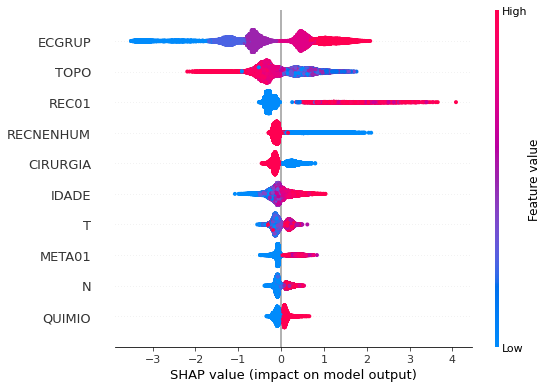

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=1.69,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.69)

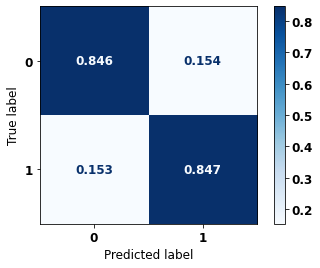


              precision    recall  f1-score   support

           0      0.905     0.846     0.875     17549
           1      0.762     0.847     0.802     10194

    accuracy                          0.846     27743
   macro avg      0.833     0.847     0.838     27743
weighted avg      0.852     0.846     0.848     27743



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 85% of accuracy.

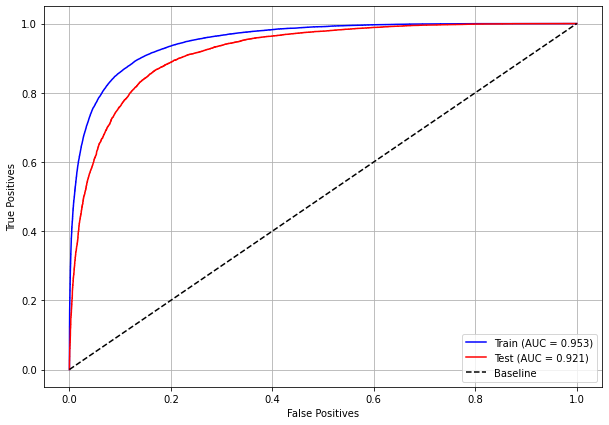

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

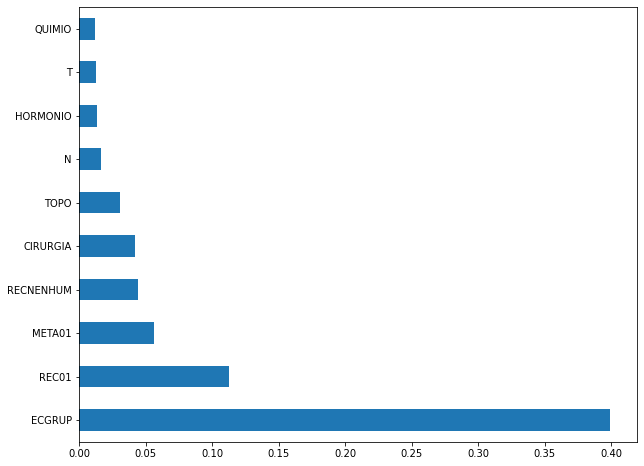

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `META01` and `RECNENHUM`. 

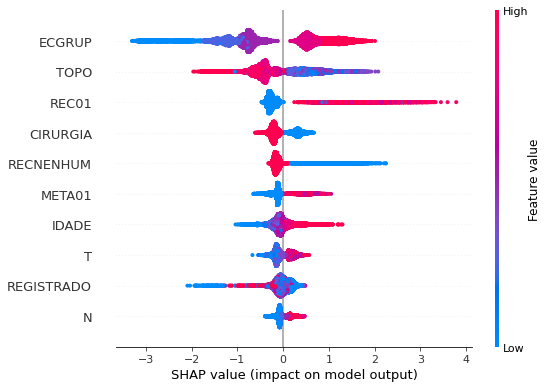

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=2.18)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=2.18)

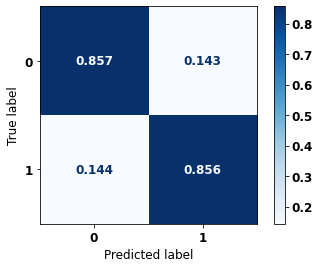


              precision    recall  f1-score   support

           0      0.934     0.857     0.893     24340
           1      0.716     0.856     0.780     10290

    accuracy                          0.856     34630
   macro avg      0.825     0.856     0.837     34630
weighted avg      0.869     0.856     0.860     34630



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 86% of accuracy.

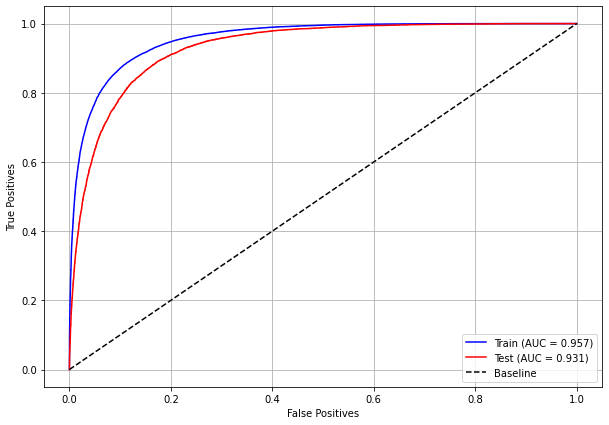

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

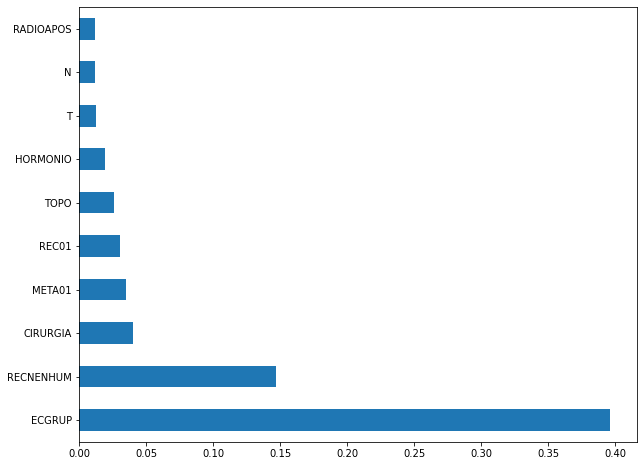

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `RECNENHUM`, `CIRURGIA` and `META01`. 

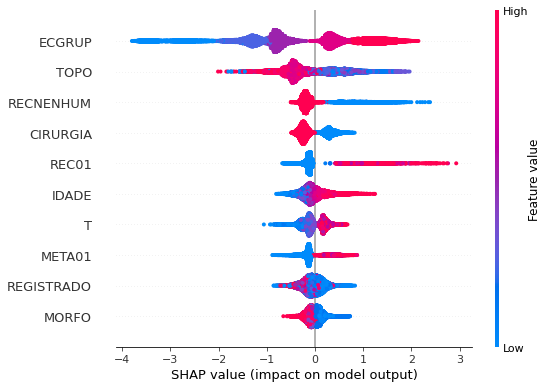

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=3.75)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=3.75)

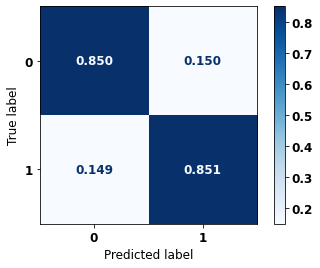


              precision    recall  f1-score   support

           0      0.953     0.850     0.899     20801
           1      0.614     0.851     0.713      5825

    accuracy                          0.850     26626
   macro avg      0.784     0.851     0.806     26626
weighted avg      0.879     0.850     0.858     26626



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.


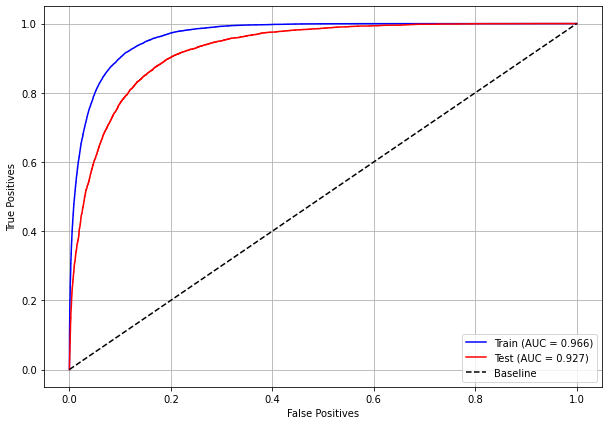

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

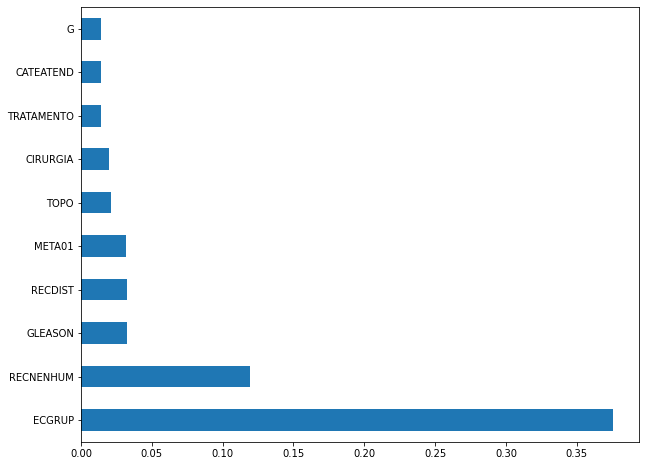

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECNENHUM`, `GLEASON` and `RECDIST`.

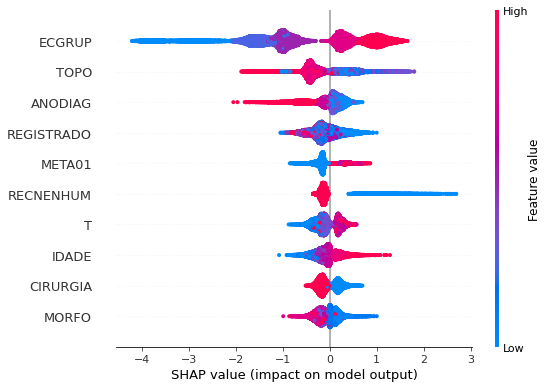

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.67,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.67)

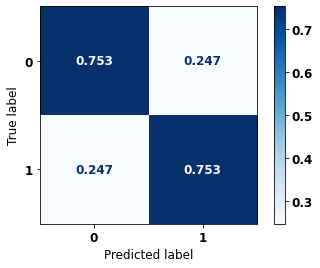


              precision    recall  f1-score   support

           0      0.822     0.753     0.786       563
           1      0.668     0.753     0.708       372

    accuracy                          0.753       935
   macro avg      0.745     0.753     0.747       935
weighted avg      0.761     0.753     0.755       935



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 75% of accuracy.

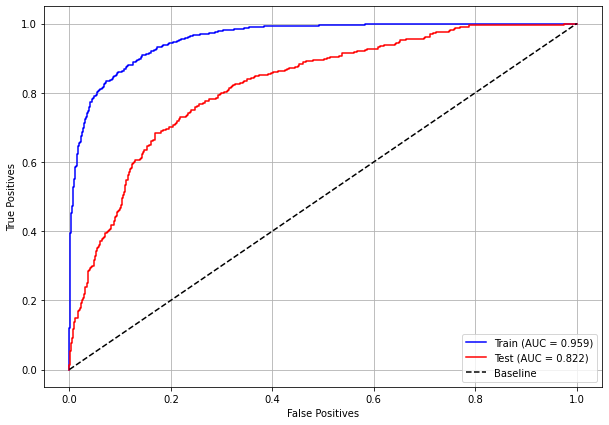

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

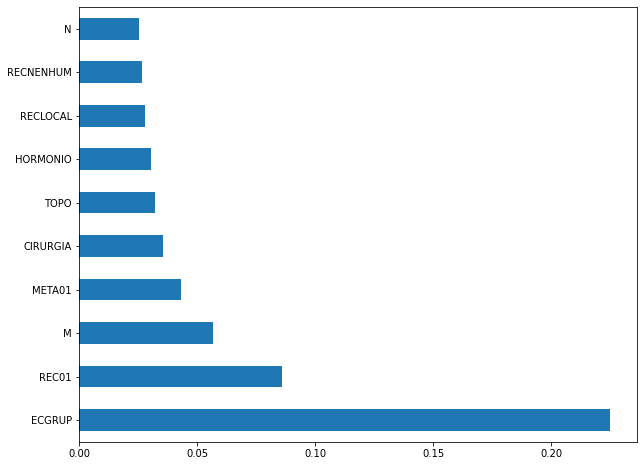

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `META01`.

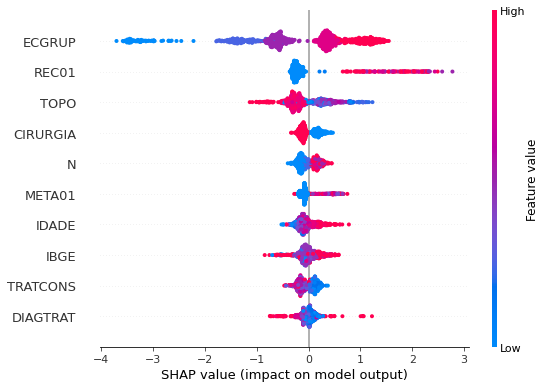

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.345,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.345)

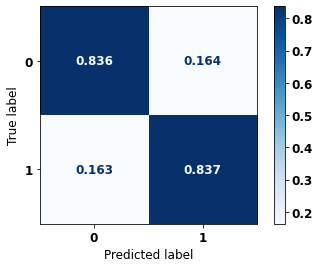


              precision    recall  f1-score   support

           0      0.890     0.836     0.862       805
           1      0.764     0.837     0.799       510

    accuracy                          0.837      1315
   macro avg      0.827     0.837     0.831      1315
weighted avg      0.841     0.837     0.838      1315



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 84% of accuracy.

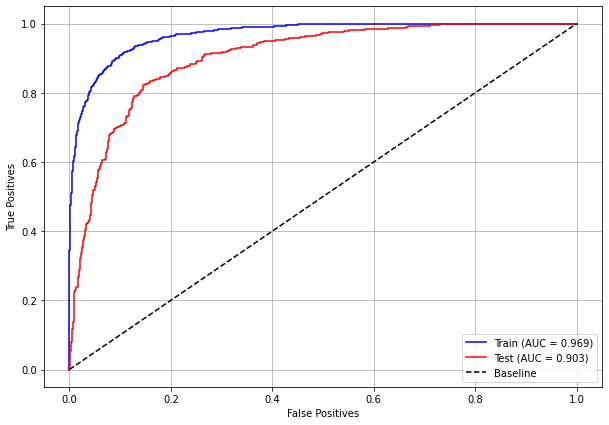

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

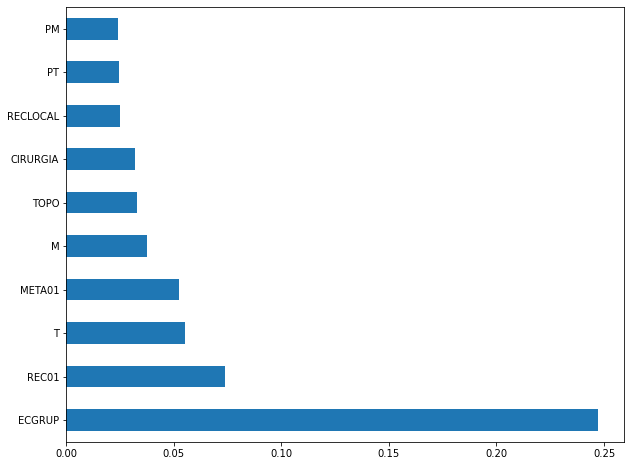

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `T` and `META01`.

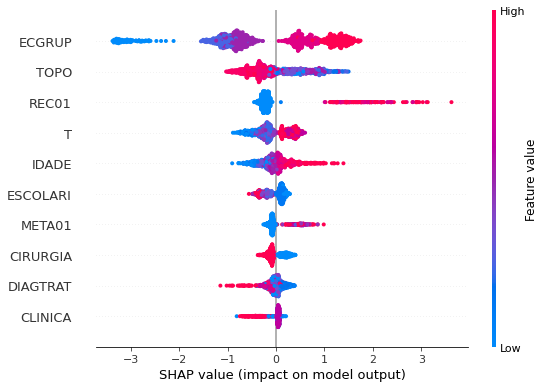

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.65,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.65)

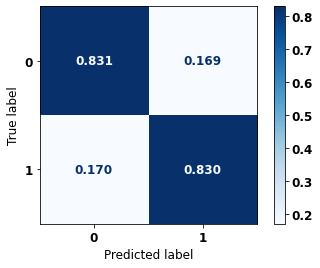


              precision    recall  f1-score   support

           0      0.904     0.831     0.866      1062
           1      0.718     0.830     0.770       552

    accuracy                          0.830      1614
   macro avg      0.811     0.830     0.818      1614
weighted avg      0.840     0.830     0.833      1614



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 83% of accuracy.

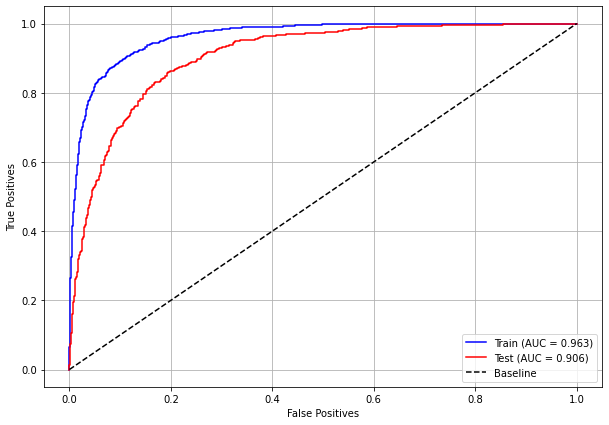

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

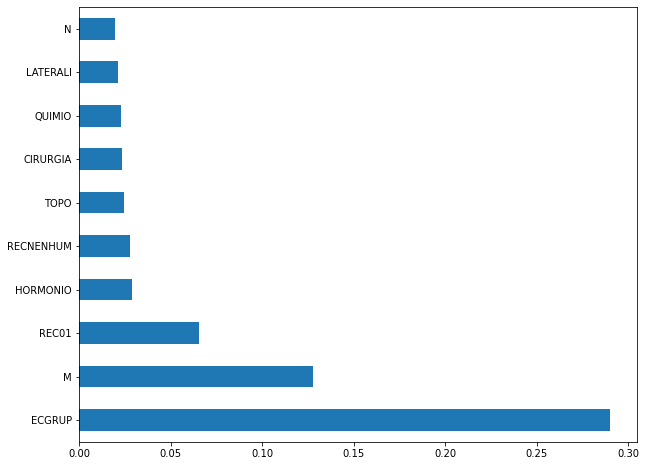

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `REC01` and `HORMONIO`.

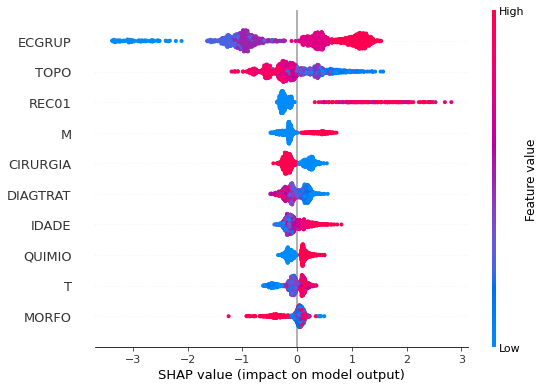

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=2.7,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=2.7)

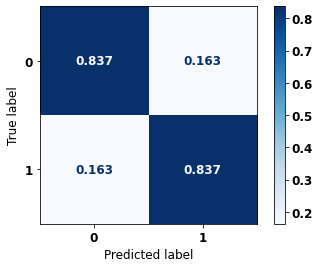


              precision    recall  f1-score   support

           0      0.932     0.837     0.882      1563
           1      0.660     0.837     0.738       590

    accuracy                          0.837      2153
   macro avg      0.796     0.837     0.810      2153
weighted avg      0.857     0.837     0.842      2153



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 84% of accuracy.

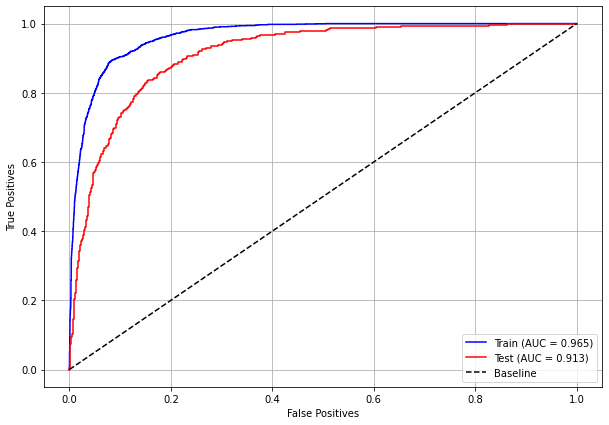

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

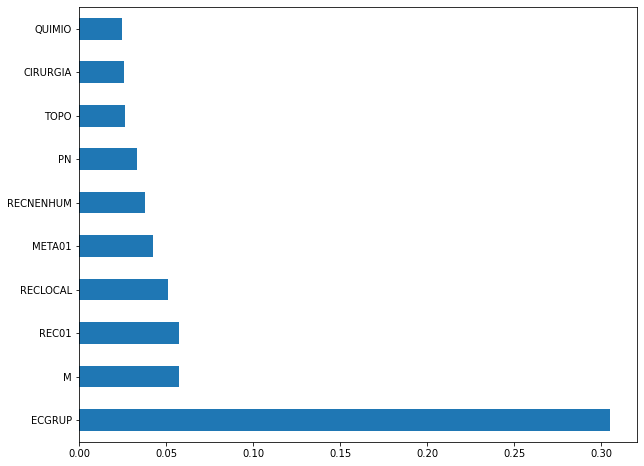

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `M`, `REC01` and `RECLOCAL`.

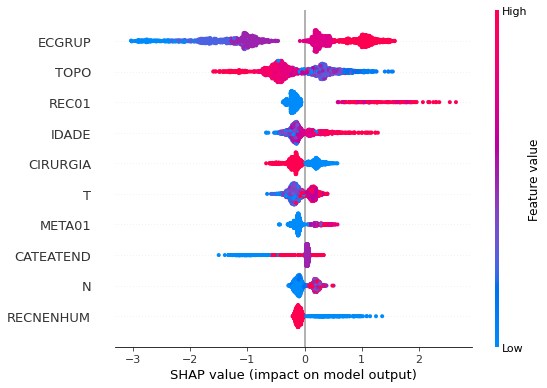

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=4.5,
                               random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=4.5)

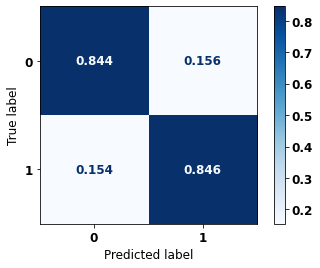


              precision    recall  f1-score   support

           0      0.949     0.844     0.893      1709
           1      0.612     0.846     0.710       499

    accuracy                          0.844      2208
   macro avg      0.781     0.845     0.802      2208
weighted avg      0.873     0.844     0.852      2208



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 84% of accuracy.

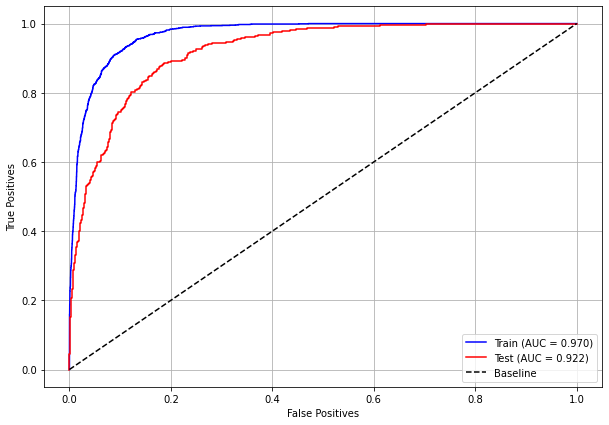

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

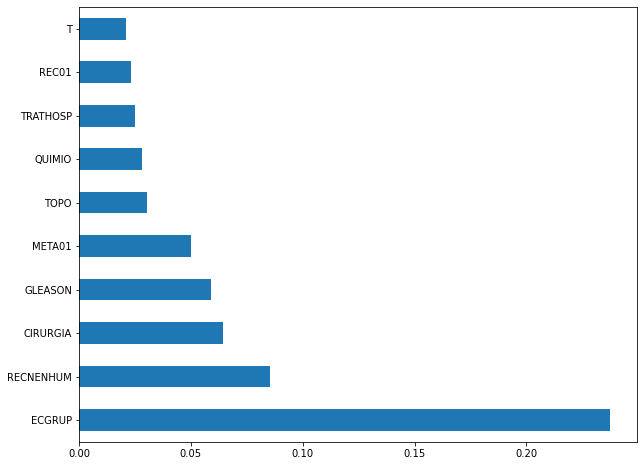

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `RECNENHUM`, `CIRURGIA` and `GLEASON`.

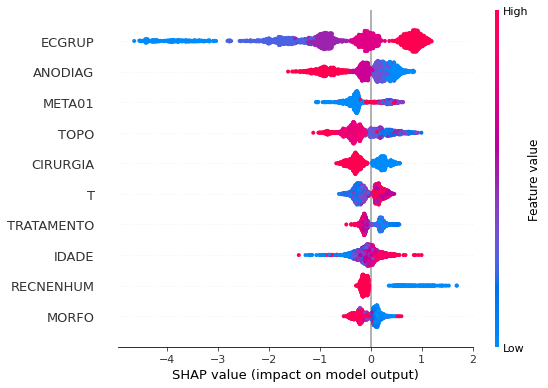

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

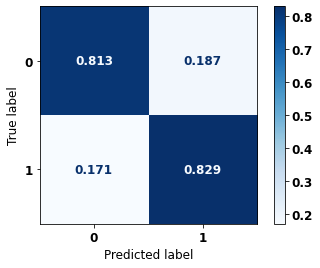


              precision    recall  f1-score   support

           0      0.873     0.813     0.842     12359
           1      0.753     0.829     0.789      8528

    accuracy                          0.819     20887
   macro avg      0.813     0.821     0.815     20887
weighted avg      0.824     0.819     0.820     20887



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

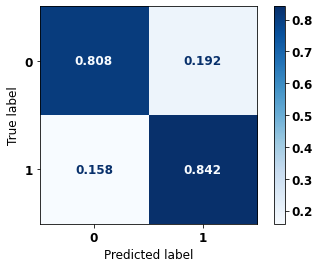


              precision    recall  f1-score   support

           0      0.898     0.808     0.851     17549
           1      0.718     0.842     0.775     10194

    accuracy                          0.821     27743
   macro avg      0.808     0.825     0.813     27743
weighted avg      0.832     0.821     0.823     27743



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

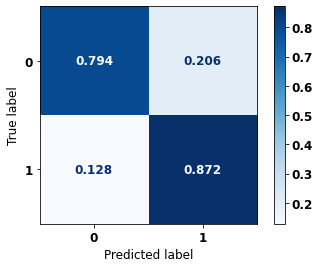


              precision    recall  f1-score   support

           0      0.936     0.794     0.859     24340
           1      0.641     0.872     0.739     10290

    accuracy                          0.817     34630
   macro avg      0.788     0.833     0.799     34630
weighted avg      0.848     0.817     0.823     34630



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

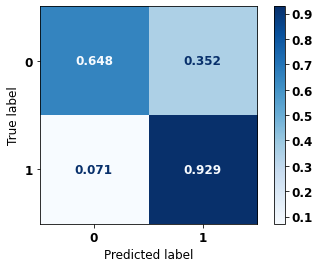


              precision    recall  f1-score   support

           0      0.970     0.648     0.777     20801
           1      0.425     0.929     0.583      5825

    accuracy                          0.709     26626
   macro avg      0.697     0.788     0.680     26626
weighted avg      0.851     0.709     0.734     26626



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

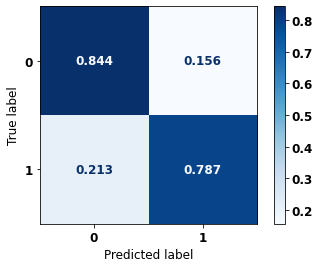


              precision    recall  f1-score   support

           0      0.852     0.844     0.848     12359
           1      0.777     0.787     0.782      8528

    accuracy                          0.821     20887
   macro avg      0.814     0.816     0.815     20887
weighted avg      0.821     0.821     0.821     20887



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

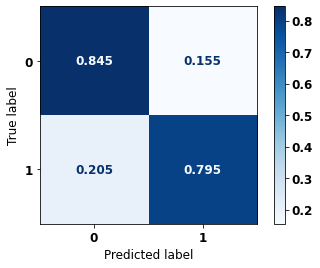


              precision    recall  f1-score   support

           0      0.876     0.845     0.860     17549
           1      0.749     0.795     0.771     10194

    accuracy                          0.827     27743
   macro avg      0.813     0.820     0.816     27743
weighted avg      0.830     0.827     0.828     27743



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

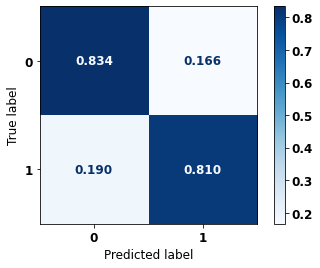


              precision    recall  f1-score   support

           0      0.912     0.834     0.871     24340
           1      0.674     0.810     0.735     10290

    accuracy                          0.827     34630
   macro avg      0.793     0.822     0.803     34630
weighted avg      0.841     0.827     0.831     34630



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

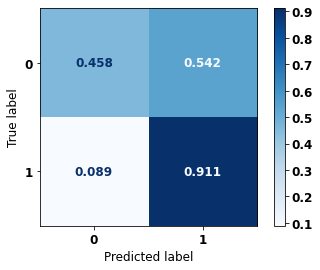


              precision    recall  f1-score   support

           0      0.948     0.458     0.618     20801
           1      0.320     0.911     0.474      5825

    accuracy                          0.558     26626
   macro avg      0.634     0.685     0.546     26626
weighted avg      0.811     0.558     0.587     26626



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

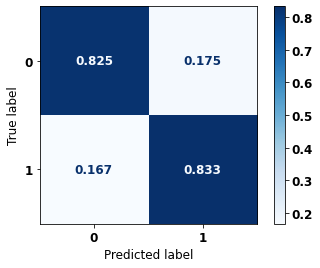


              precision    recall  f1-score   support

           0      0.895     0.825     0.858     17549
           1      0.734     0.833     0.780     10194

    accuracy                          0.828     27743
   macro avg      0.814     0.829     0.819     27743
weighted avg      0.836     0.828     0.830     27743



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

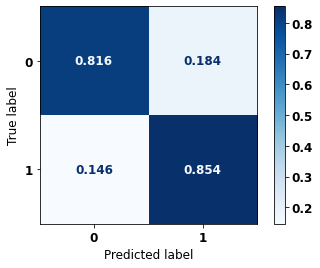


              precision    recall  f1-score   support

           0      0.930     0.816     0.869     24340
           1      0.663     0.854     0.746     10290

    accuracy                          0.827     34630
   macro avg      0.796     0.835     0.808     34630
weighted avg      0.850     0.827     0.833     34630



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

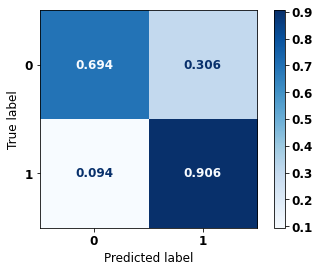


              precision    recall  f1-score   support

           0      0.963     0.694     0.807     20801
           1      0.453     0.906     0.604      5825

    accuracy                          0.740     26626
   macro avg      0.708     0.800     0.705     26626
weighted avg      0.852     0.740     0.762     26626



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

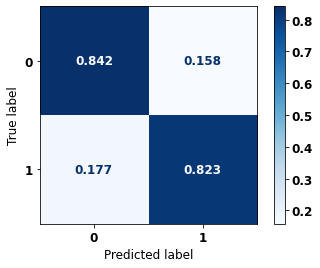


              precision    recall  f1-score   support

           0      0.891     0.842     0.866     17549
           1      0.752     0.823     0.786     10194

    accuracy                          0.835     27743
   macro avg      0.821     0.833     0.826     27743
weighted avg      0.840     0.835     0.836     27743



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

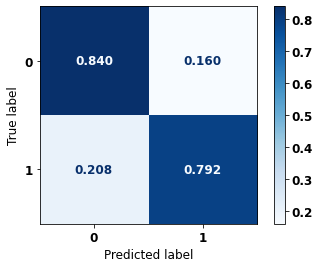


              precision    recall  f1-score   support

           0      0.905     0.840     0.871     24340
           1      0.677     0.792     0.730     10290

    accuracy                          0.826     34630
   macro avg      0.791     0.816     0.801     34630
weighted avg      0.837     0.826     0.829     34630



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

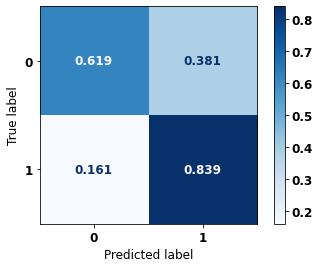


              precision    recall  f1-score   support

           0      0.932     0.619     0.744     20801
           1      0.381     0.839     0.524      5825

    accuracy                          0.667     26626
   macro avg      0.657     0.729     0.634     26626
weighted avg      0.812     0.667     0.696     26626



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

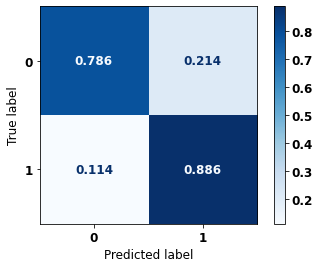


              precision    recall  f1-score   support

           0      0.942     0.786     0.857     24340
           1      0.636     0.886     0.741     10290

    accuracy                          0.816     34630
   macro avg      0.789     0.836     0.799     34630
weighted avg      0.851     0.816     0.822     34630



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

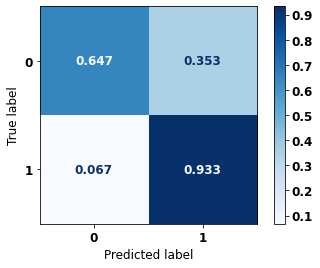


              precision    recall  f1-score   support

           0      0.972     0.647     0.777     20801
           1      0.425     0.933     0.584      5825

    accuracy                          0.709     26626
   macro avg      0.698     0.790     0.680     26626
weighted avg      0.852     0.709     0.734     26626



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

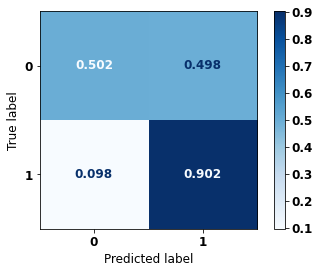


              precision    recall  f1-score   support

           0      0.924     0.502     0.651     24340
           1      0.434     0.902     0.586     10290

    accuracy                          0.621     34630
   macro avg      0.679     0.702     0.618     34630
weighted avg      0.778     0.621     0.631     34630



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

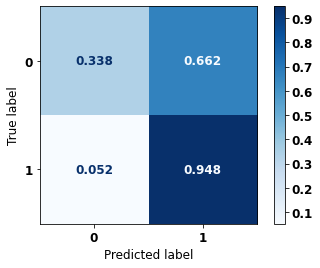


              precision    recall  f1-score   support

           0      0.959     0.338     0.500     20801
           1      0.286     0.948     0.440      5825

    accuracy                          0.472     26626
   macro avg      0.622     0.643     0.470     26626
weighted avg      0.812     0.472     0.487     26626



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

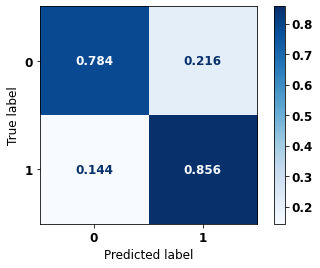


              precision    recall  f1-score   support

           0      0.951     0.784     0.860     20801
           1      0.527     0.856     0.652      5825

    accuracy                          0.800     26626
   macro avg      0.739     0.820     0.756     26626
weighted avg      0.858     0.800     0.814     26626



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

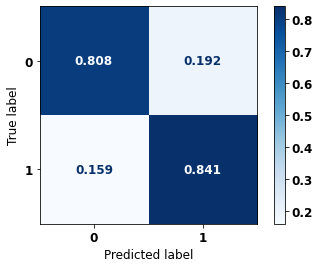


              precision    recall  f1-score   support

           0      0.948     0.808     0.872     20801
           1      0.551     0.841     0.666      5825

    accuracy                          0.815     26626
   macro avg      0.749     0.824     0.769     26626
weighted avg      0.861     0.815     0.827     26626



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

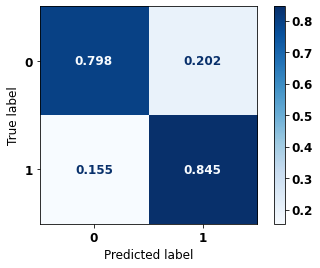


              precision    recall  f1-score   support

           0      0.890     0.798     0.841       805
           1      0.726     0.845     0.781       510

    accuracy                          0.816      1315
   macro avg      0.808     0.821     0.811      1315
weighted avg      0.826     0.816     0.818      1315



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

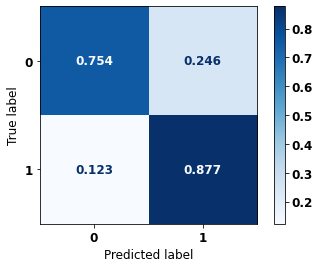


              precision    recall  f1-score   support

           0      0.922     0.754     0.830      1062
           1      0.650     0.877     0.746       552

    accuracy                          0.796      1614
   macro avg      0.786     0.816     0.788      1614
weighted avg      0.829     0.796     0.801      1614



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

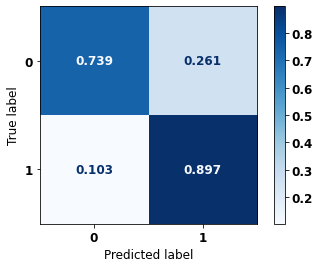


              precision    recall  f1-score   support

           0      0.950     0.739     0.831      1563
           1      0.565     0.897     0.693       590

    accuracy                          0.782      2153
   macro avg      0.757     0.818     0.762      2153
weighted avg      0.844     0.782     0.793      2153



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

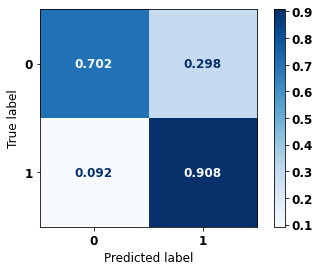


              precision    recall  f1-score   support

           0      0.963     0.702     0.812      1709
           1      0.470     0.908     0.620       499

    accuracy                          0.748      2208
   macro avg      0.717     0.805     0.716      2208
weighted avg      0.852     0.748     0.768      2208



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

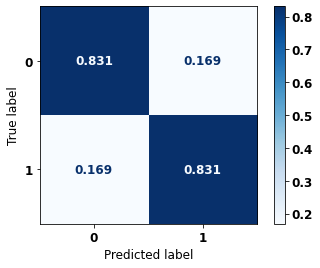


              precision    recall  f1-score   support

           0      0.886     0.831     0.858       805
           1      0.757     0.831     0.793       510

    accuracy                          0.831      1315
   macro avg      0.822     0.831     0.825      1315
weighted avg      0.836     0.831     0.832      1315



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

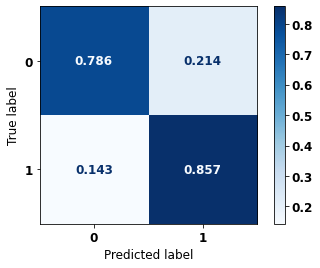


              precision    recall  f1-score   support

           0      0.914     0.786     0.845      1062
           1      0.676     0.857     0.756       552

    accuracy                          0.810      1614
   macro avg      0.795     0.822     0.800      1614
weighted avg      0.832     0.810     0.815      1614



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

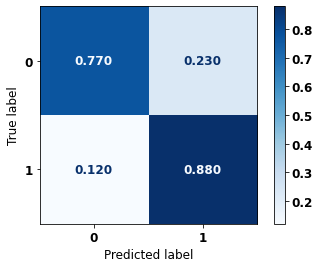


              precision    recall  f1-score   support

           0      0.944     0.770     0.848      1563
           1      0.591     0.880     0.707       590

    accuracy                          0.800      2153
   macro avg      0.768     0.825     0.778      2153
weighted avg      0.848     0.800     0.810      2153



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

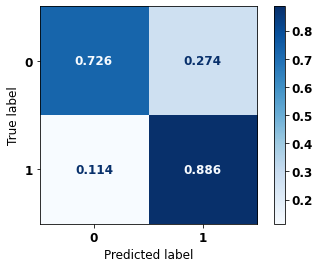


              precision    recall  f1-score   support

           0      0.956     0.726     0.825      1709
           1      0.486     0.886     0.627       499

    accuracy                          0.762      2208
   macro avg      0.721     0.806     0.726      2208
weighted avg      0.850     0.762     0.781      2208



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

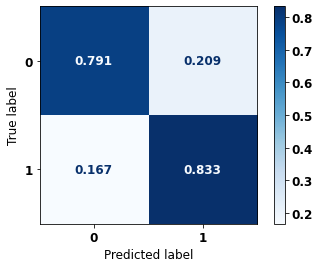


              precision    recall  f1-score   support

           0      0.901     0.791     0.843      1062
           1      0.674     0.833     0.746       552

    accuracy                          0.805      1614
   macro avg      0.788     0.812     0.794      1614
weighted avg      0.824     0.805     0.809      1614



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

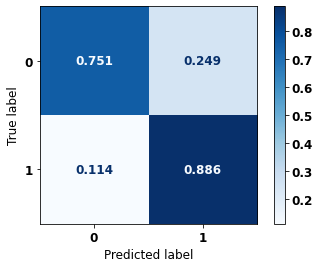


              precision    recall  f1-score   support

           0      0.946     0.751     0.837      1563
           1      0.573     0.886     0.696       590

    accuracy                          0.788      2153
   macro avg      0.760     0.819     0.767      2153
weighted avg      0.844     0.788     0.799      2153



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

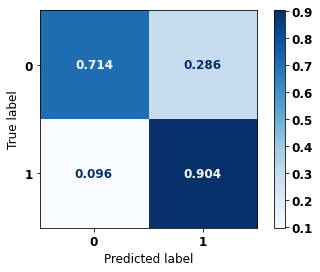


              precision    recall  f1-score   support

           0      0.962     0.714     0.820      1709
           1      0.480     0.904     0.627       499

    accuracy                          0.757      2208
   macro avg      0.721     0.809     0.723      2208
weighted avg      0.853     0.757     0.776      2208



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

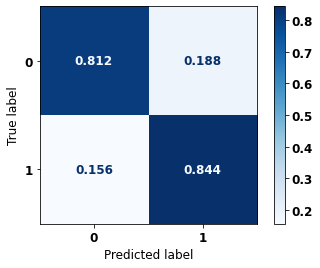


              precision    recall  f1-score   support

           0      0.909     0.812     0.858      1062
           1      0.700     0.844     0.765       552

    accuracy                          0.823      1614
   macro avg      0.804     0.828     0.811      1614
weighted avg      0.838     0.823     0.826      1614



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

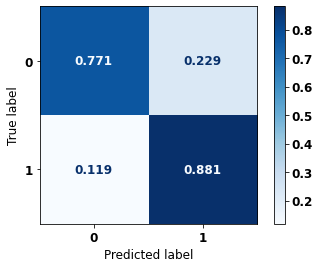


              precision    recall  f1-score   support

           0      0.945     0.771     0.849      1563
           1      0.592     0.881     0.708       590

    accuracy                          0.801      2153
   macro avg      0.769     0.826     0.779      2153
weighted avg      0.848     0.801     0.811      2153



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

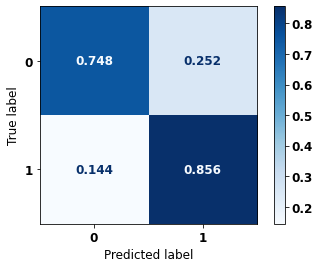


              precision    recall  f1-score   support

           0      0.947     0.748     0.836      1709
           1      0.498     0.856     0.630       499

    accuracy                          0.773      2208
   macro avg      0.722     0.802     0.733      2208
weighted avg      0.845     0.773     0.789      2208



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

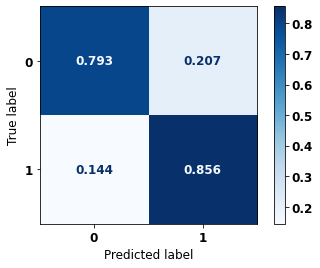


              precision    recall  f1-score   support

           0      0.936     0.793     0.858      1563
           1      0.609     0.856     0.712       590

    accuracy                          0.810      2153
   macro avg      0.772     0.824     0.785      2153
weighted avg      0.846     0.810     0.818      2153



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

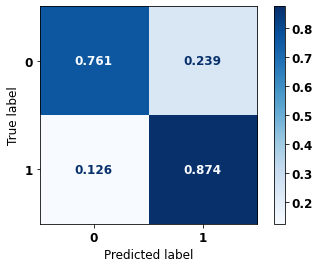


              precision    recall  f1-score   support

           0      0.954     0.761     0.846      1709
           1      0.516     0.874     0.649       499

    accuracy                          0.786      2208
   macro avg      0.735     0.817     0.748      2208
weighted avg      0.855     0.786     0.802      2208



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

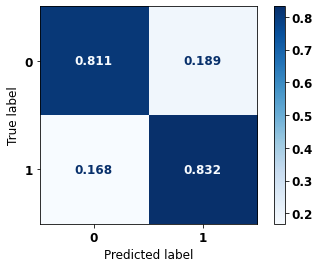


              precision    recall  f1-score   support

           0      0.928     0.811     0.866      1563
           1      0.625     0.832     0.714       590

    accuracy                          0.817      2153
   macro avg      0.776     0.822     0.790      2153
weighted avg      0.845     0.817     0.824      2153



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

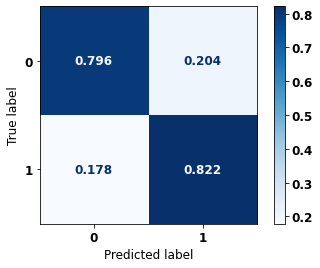


              precision    recall  f1-score   support

           0      0.939     0.796     0.861      1709
           1      0.540     0.822     0.652       499

    accuracy                          0.802      2208
   macro avg      0.739     0.809     0.757      2208
weighted avg      0.849     0.802     0.814      2208



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

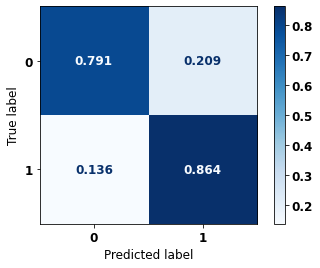


              precision    recall  f1-score   support

           0      0.952     0.791     0.864      1709
           1      0.546     0.864     0.669       499

    accuracy                          0.807      2208
   macro avg      0.749     0.827     0.767      2208
weighted avg      0.860     0.807     0.820      2208



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

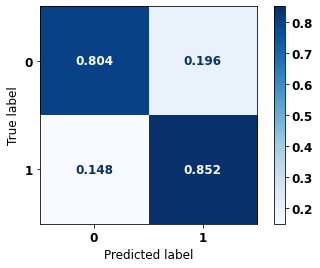


              precision    recall  f1-score   support

           0      0.949     0.804     0.870      1709
           1      0.559     0.852     0.675       499

    accuracy                          0.815      2208
   macro avg      0.754     0.828     0.773      2208
weighted avg      0.861     0.815     0.826      2208



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)

# **Fourth approach**

Approach with grouped years, using only morphologies with final digit equal to 3 and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, 
                                                                                                last_year=2003, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (46098, 65), X_test = (15367, 65)
y_train = (46098,), y_test = (15367,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (58169, 65), X_test = (19390, 65)
y_train = (58169,), y_test = (19390,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (77412, 65), X_test = (25804, 65)
y_train = (77412,), y_test = (25804,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (96124, 65), X_test = (32042, 65)
y_train = (96124,), y_test = (32042,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2021, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73682, 65), X_test = (24561, 65)
y_train = (73682,), y_test = (24561,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2000,
                                                                                                last_year=2003, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2592, 65), X_test = (865, 65)
y_train = (2592,), y_test = (865,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3694, 65), X_test = (1232, 65)
y_train = (3694,), y_test = (1232,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4536, 65), X_test = (1513, 65)
y_train = (4536,), y_test = (1513,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6069, 65), X_test = (2024, 65)
y_train = (6069,), y_test = (2024,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2020, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6185, 65), X_test = (2062, 65)
y_train = (6185,), y_test = (2062,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

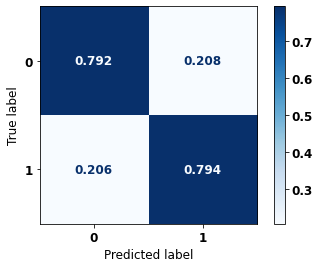


              precision    recall  f1-score   support

           0      0.805     0.792     0.799      7965
           1      0.780     0.794     0.787      7402

    accuracy                          0.793     15367
   macro avg      0.793     0.793     0.793     15367
weighted avg      0.793     0.793     0.793     15367



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


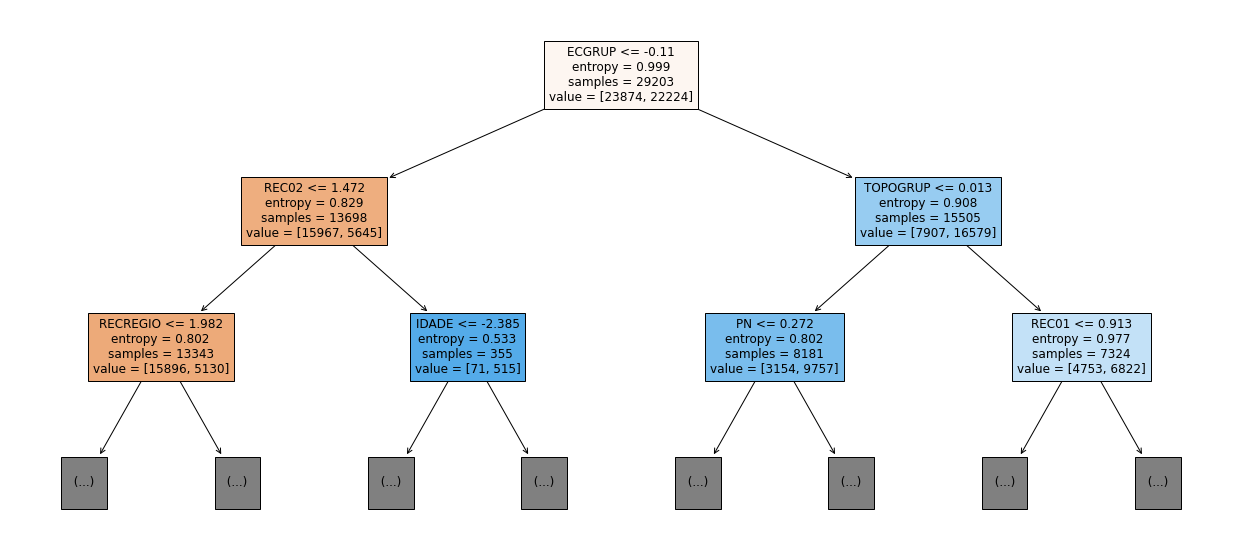

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

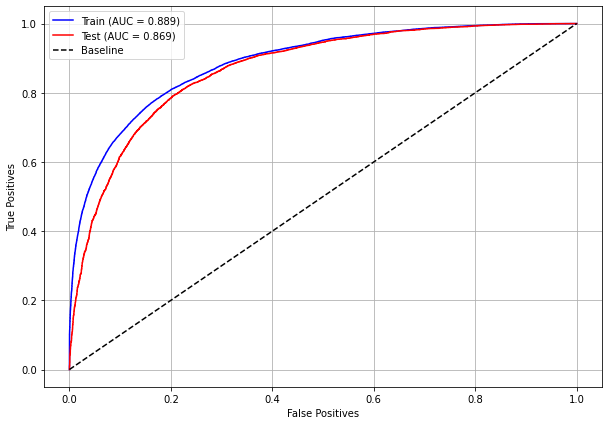

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

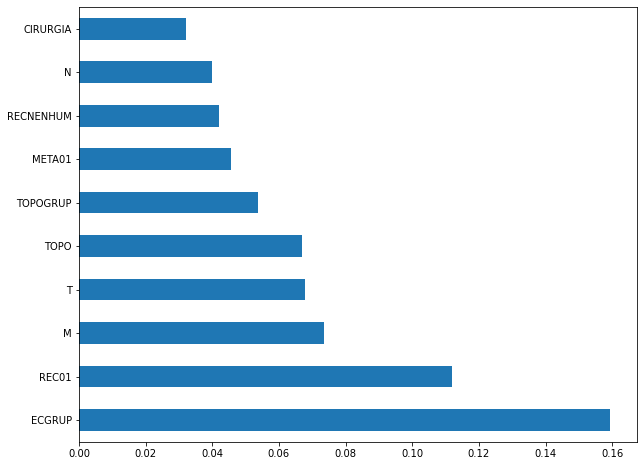

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `REC01`, `M`, and `T`.

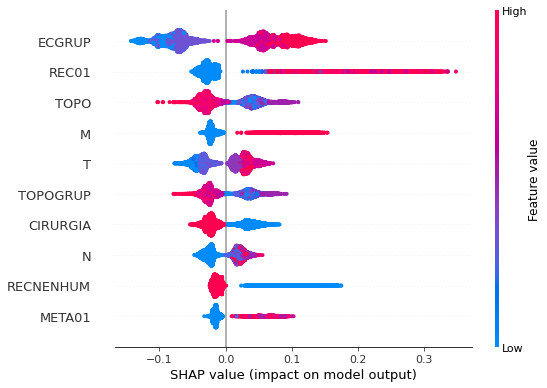

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.2},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.2}, criterion='entropy',
                       max_depth=10, random_state=10)

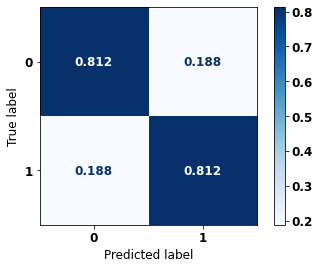


              precision    recall  f1-score   support

           0      0.848     0.812     0.829     10925
           1      0.770     0.812     0.790      8465

    accuracy                          0.812     19390
   macro avg      0.809     0.812     0.810     19390
weighted avg      0.814     0.812     0.812     19390



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.

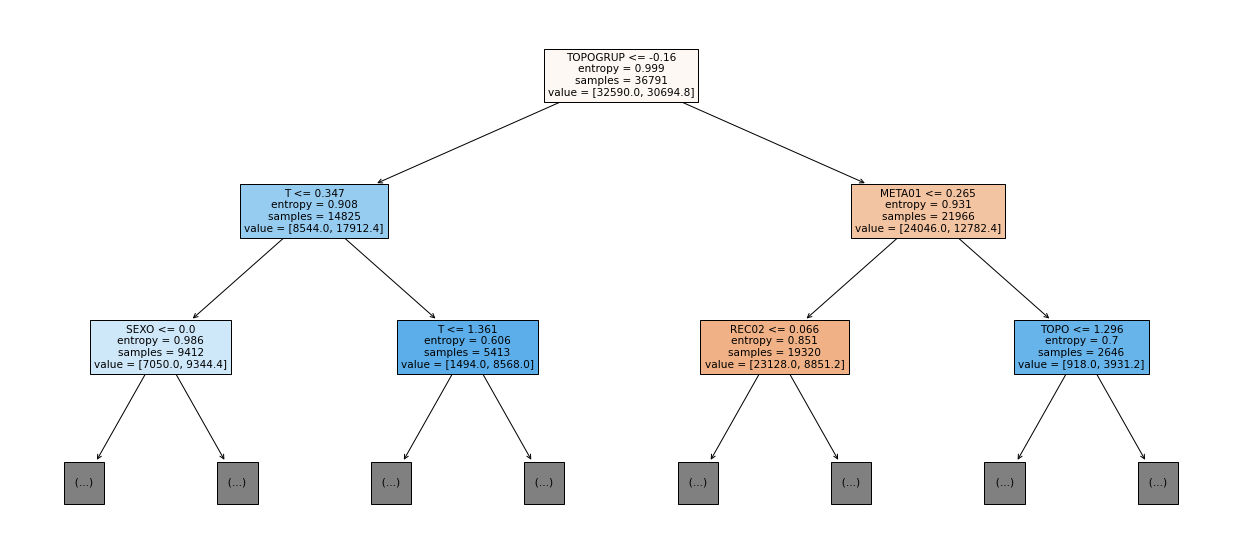

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

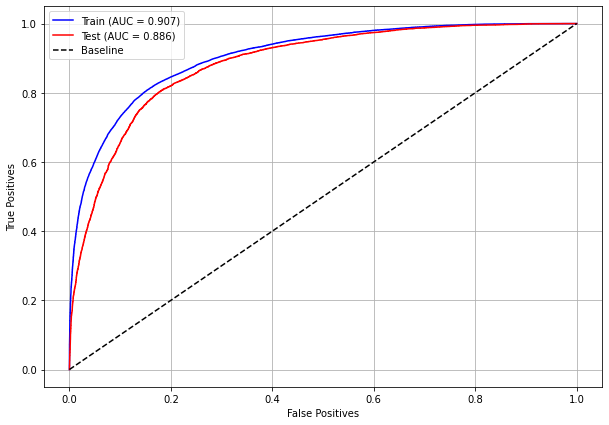

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

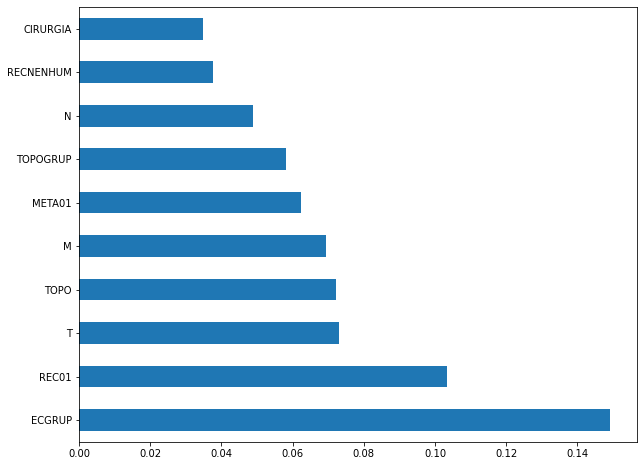

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `REC01`, `T` and `TOPO`.

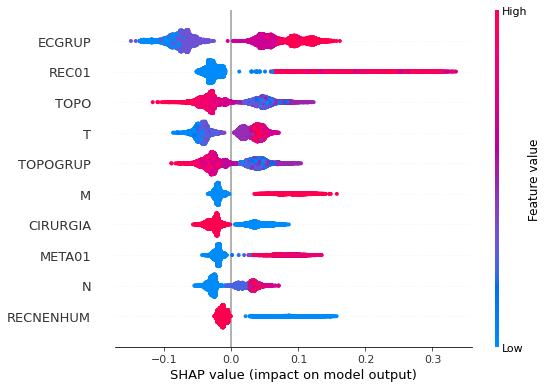

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.475},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.475}, criterion='entropy',
                       max_depth=10, random_state=10)

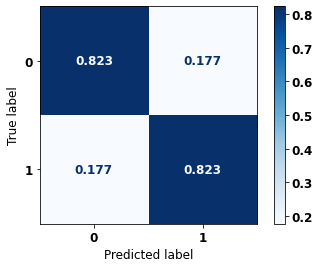


              precision    recall  f1-score   support

           0      0.879     0.823     0.850     15705
           1      0.749     0.823     0.785     10099

    accuracy                          0.823     25804
   macro avg      0.814     0.823     0.817     25804
weighted avg      0.828     0.823     0.824     25804



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuray.

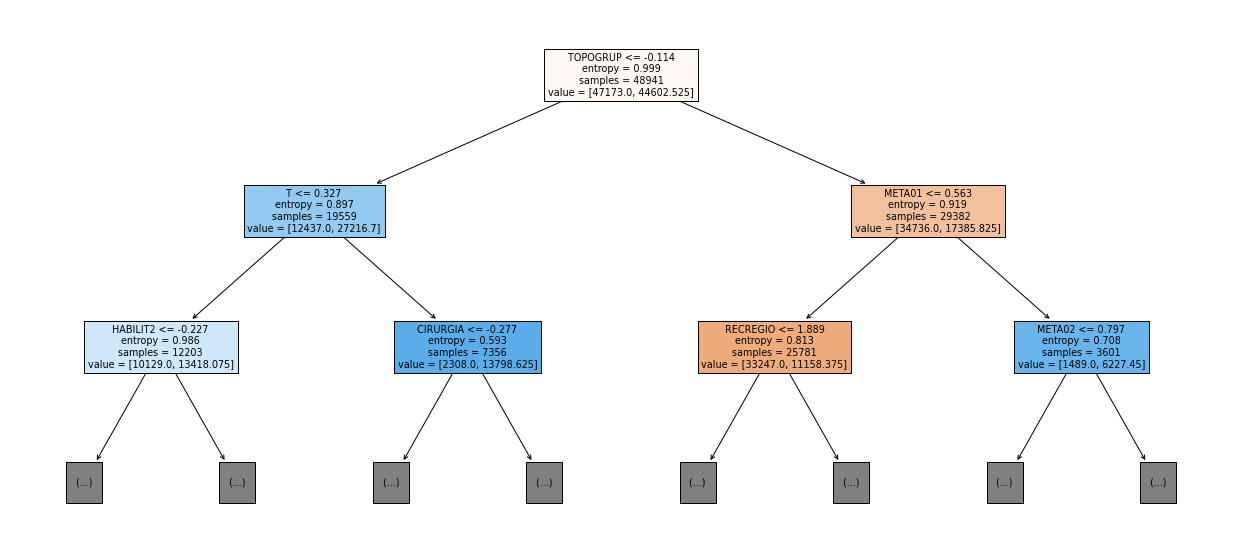

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

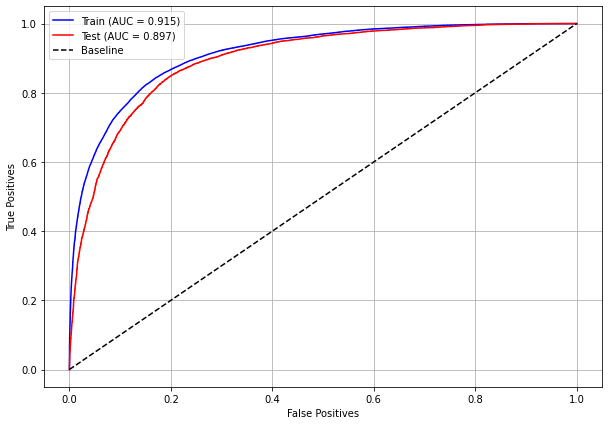

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

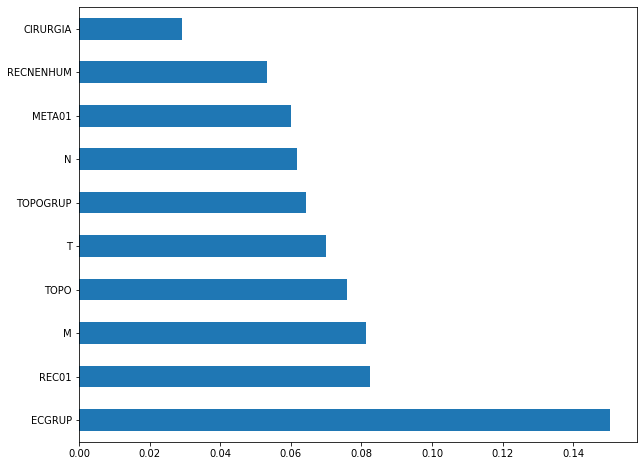

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `TOPO`.

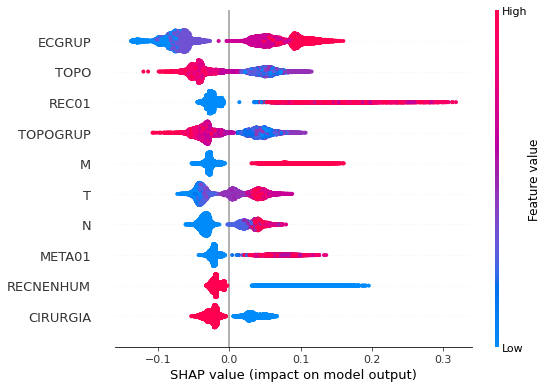

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.05},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.05}, criterion='entropy',
                       max_depth=10, random_state=10)

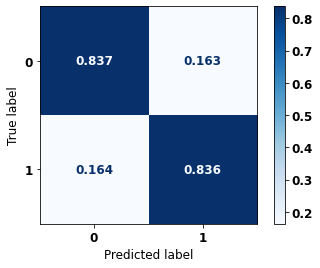


              precision    recall  f1-score   support

           0      0.916     0.837     0.874     21800
           1      0.706     0.836     0.766     10242

    accuracy                          0.837     32042
   macro avg      0.811     0.836     0.820     32042
weighted avg      0.849     0.837     0.840     32042



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 84% of accuracy.

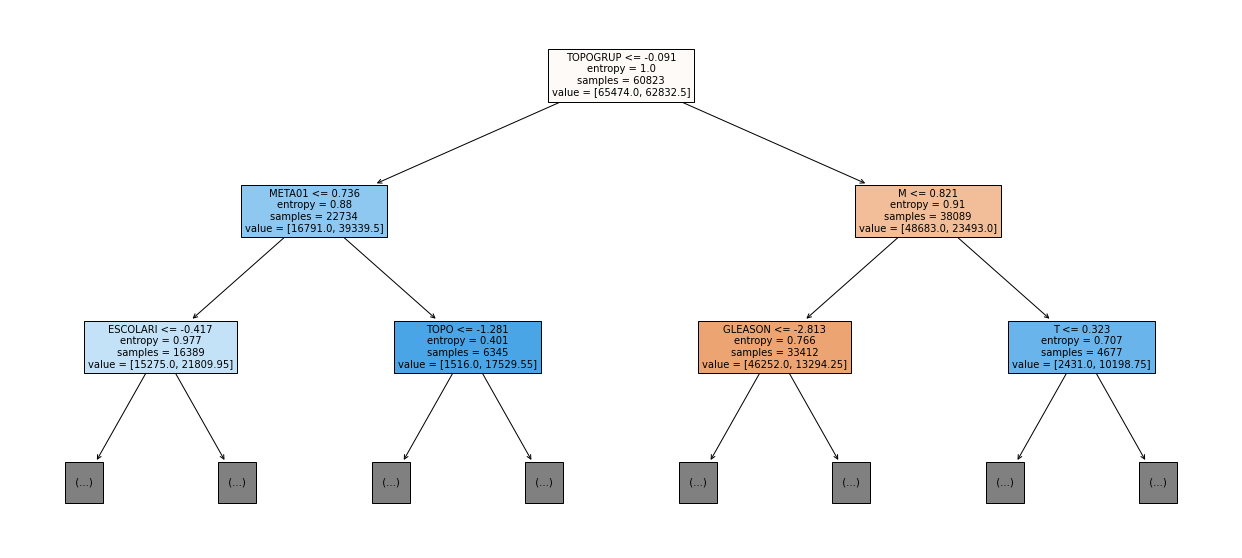

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

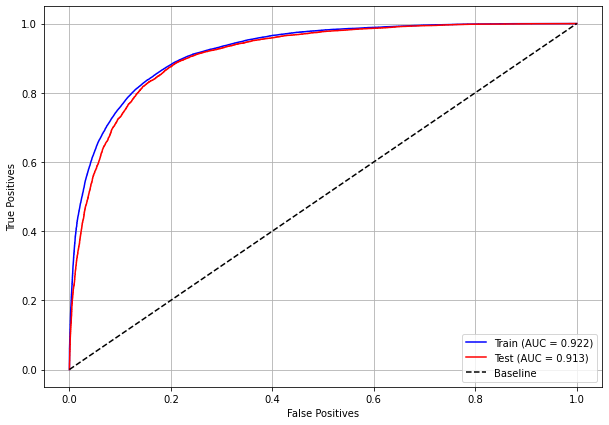

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

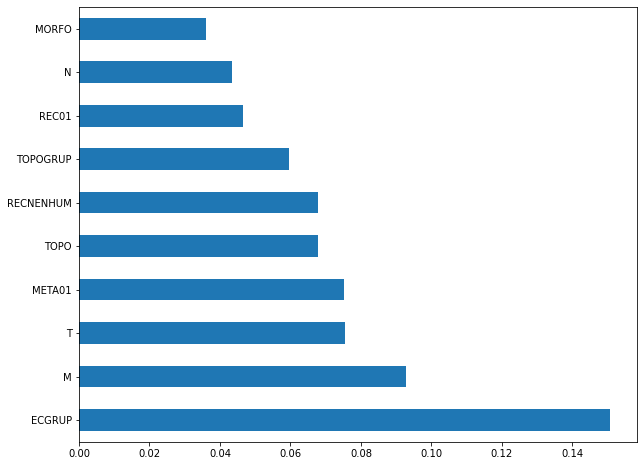

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `META01`.

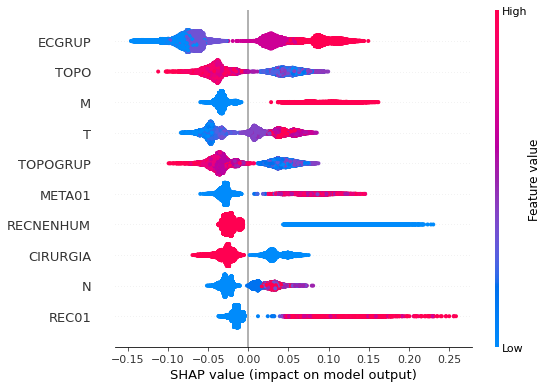

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:3.015},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 3.015}, criterion='entropy',
                       max_depth=10, random_state=10)

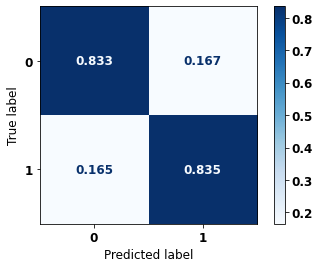


              precision    recall  f1-score   support

           0      0.942     0.833     0.884     18758
           1      0.607     0.835     0.703      5803

    accuracy                          0.834     24561
   macro avg      0.775     0.834     0.794     24561
weighted avg      0.863     0.834     0.842     24561



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 83% of accuracy.

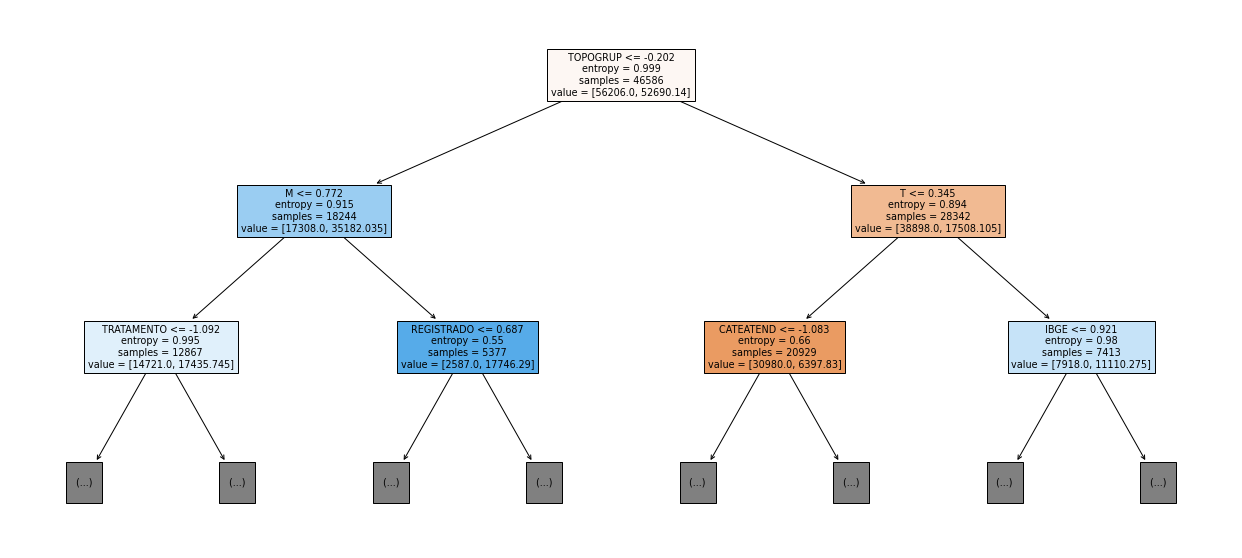

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

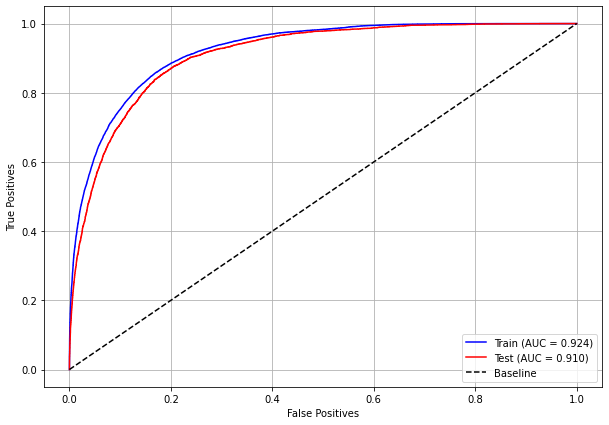

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

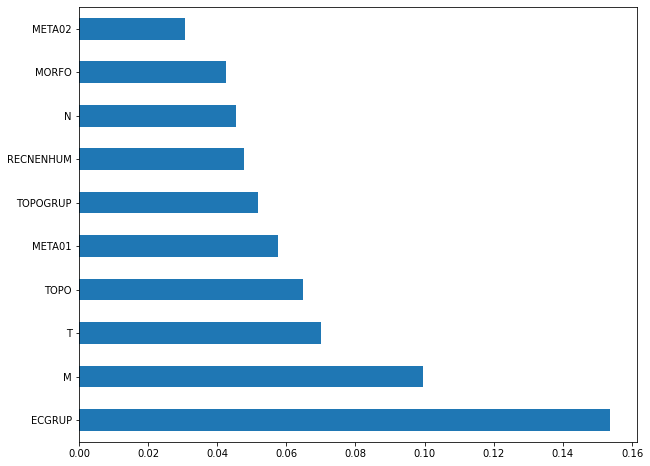

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `T`, and `TOPO`.



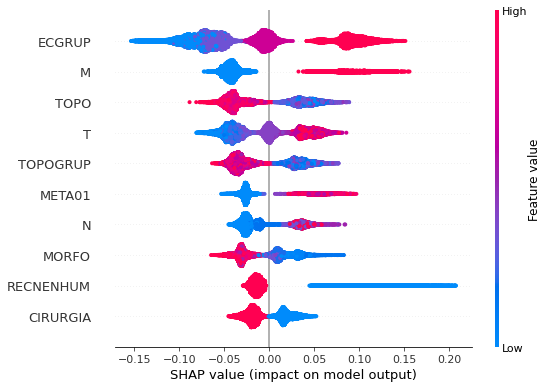

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.32},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.32}, criterion='entropy',
                       max_depth=6, random_state=10)

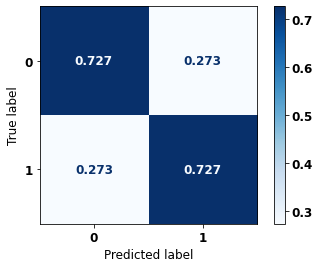


              precision    recall  f1-score   support

           0      0.781     0.727     0.753       495
           1      0.666     0.727     0.695       370

    accuracy                          0.727       865
   macro avg      0.723     0.727     0.724       865
weighted avg      0.732     0.727     0.728       865



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 73% of accuracy.

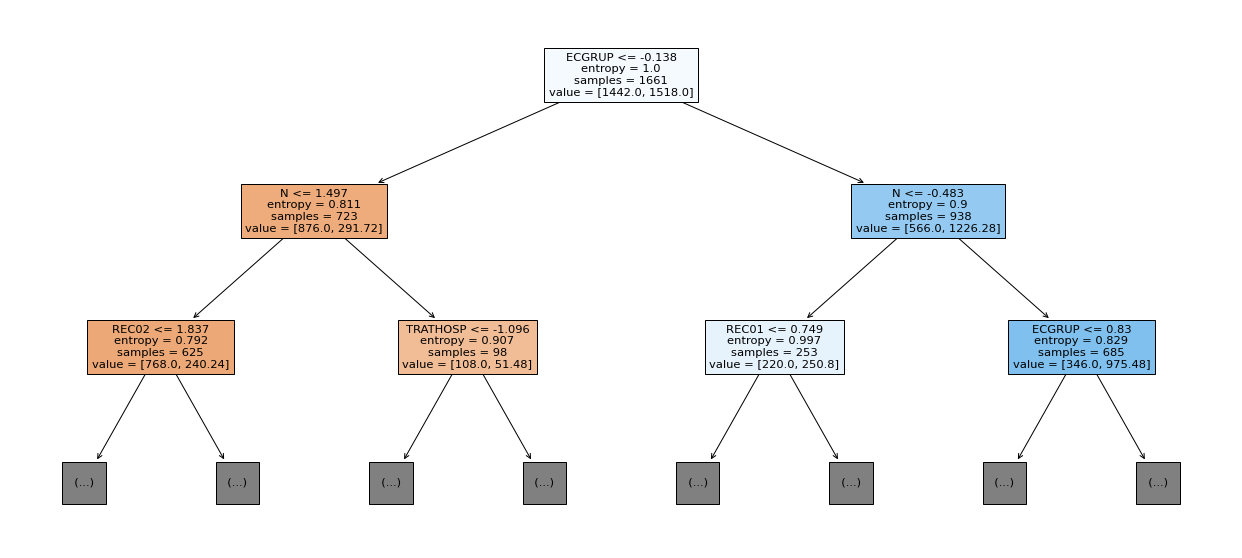

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

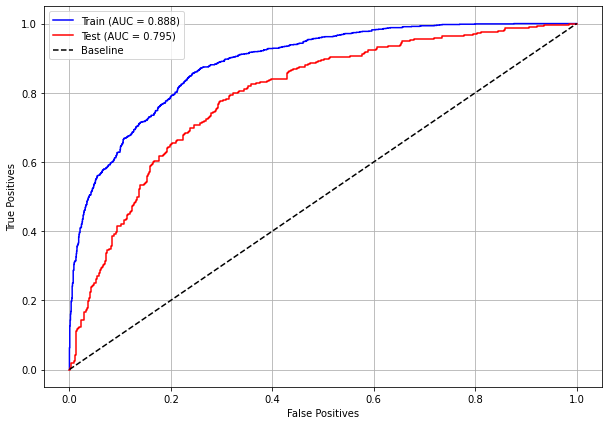

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

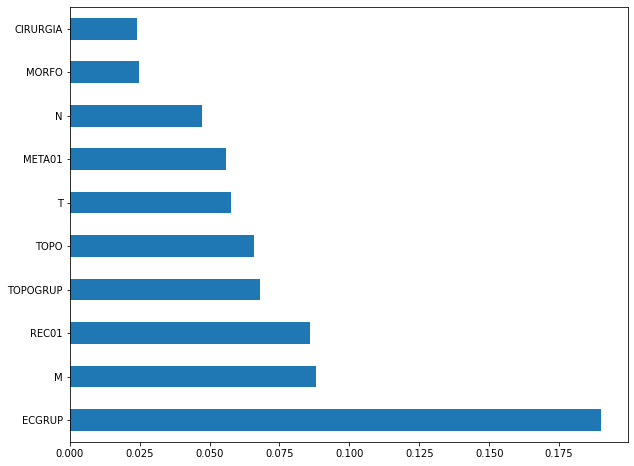

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `M`, `REC01` and `TOPOGRUP`.

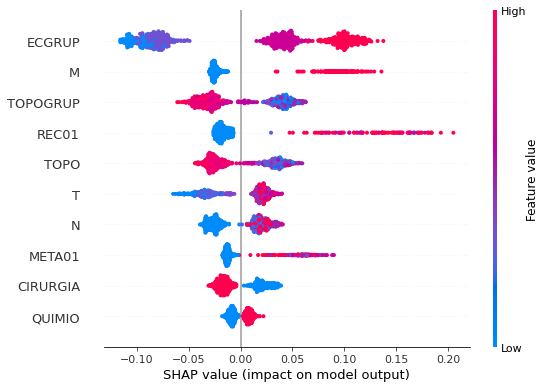

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.3},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.3}, criterion='entropy',
                       max_depth=6, random_state=10)

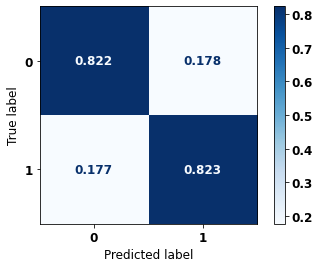


              precision    recall  f1-score   support

           0      0.869     0.822     0.845       724
           1      0.764     0.823     0.792       508

    accuracy                          0.822      1232
   macro avg      0.816     0.822     0.818      1232
weighted avg      0.826     0.822     0.823      1232



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 82% of accuracy.


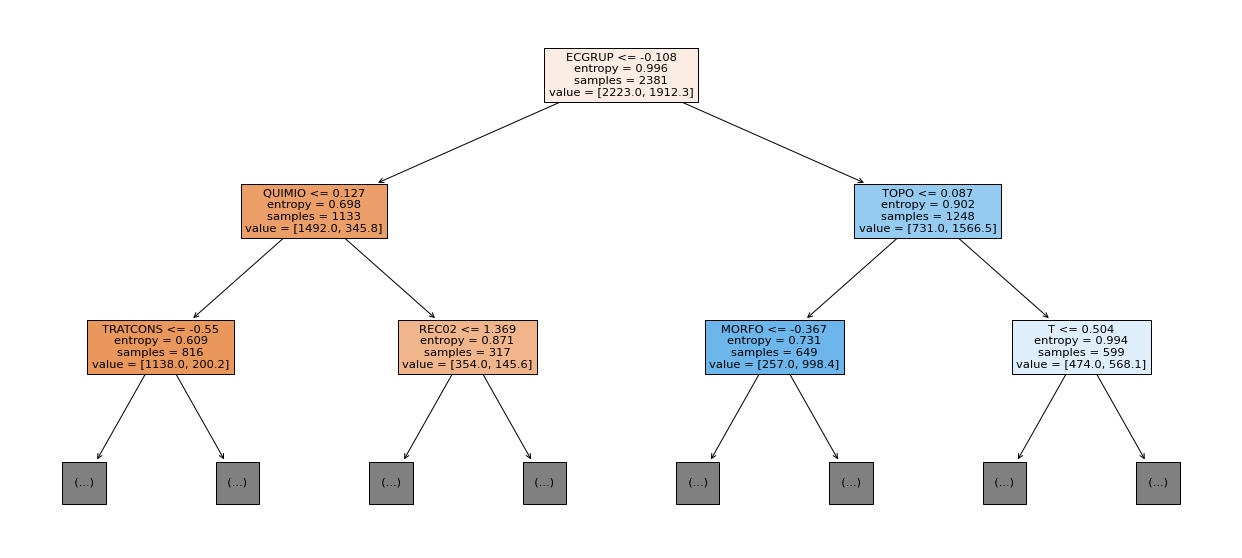

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

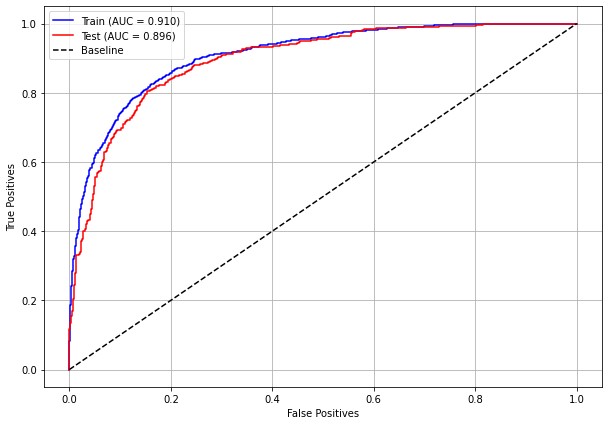

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

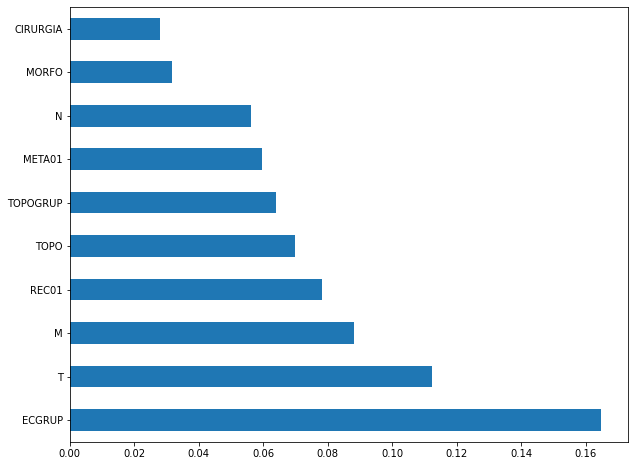

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `M` and `REC01`.

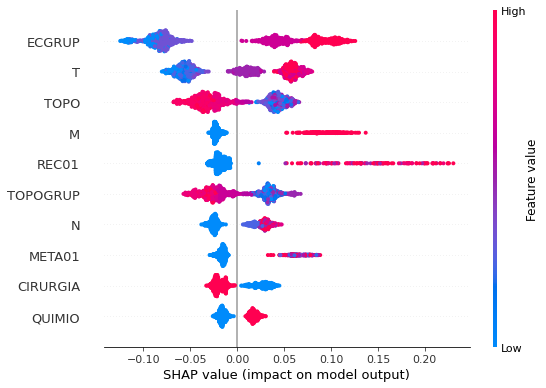

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed,
                                       class_weight={0:1, 1:1.69},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.69}, criterion='entropy',
                       max_depth=6, random_state=10)

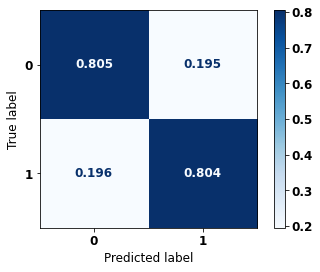


              precision    recall  f1-score   support

           0      0.878     0.805     0.839       962
           1      0.702     0.804     0.750       551

    accuracy                          0.804      1513
   macro avg      0.790     0.804     0.795      1513
weighted avg      0.814     0.804     0.807      1513



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 80% of accuracy.


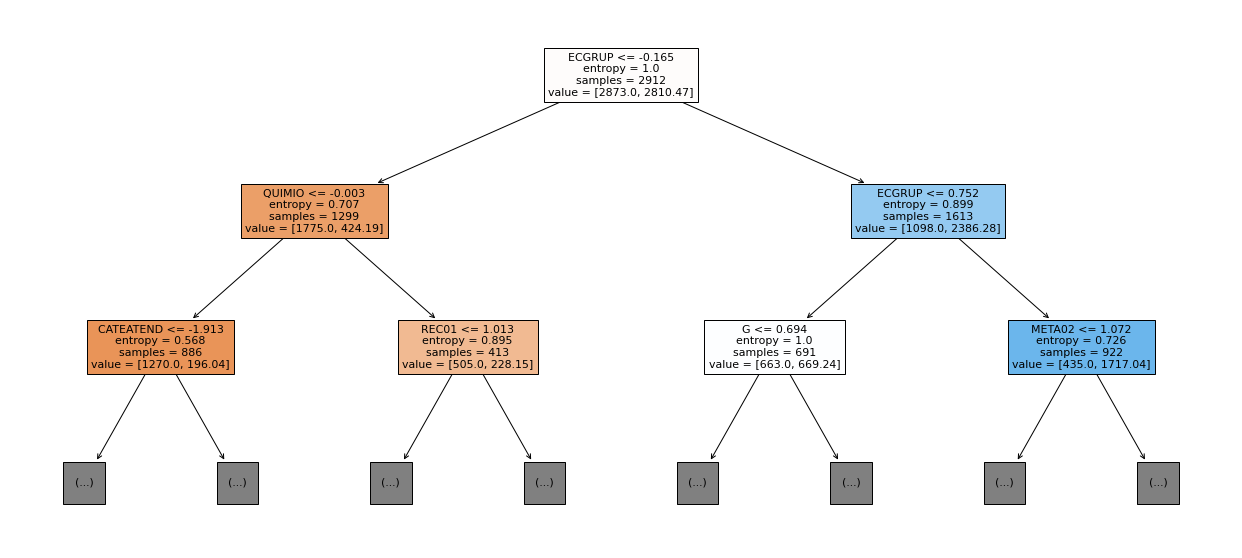

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

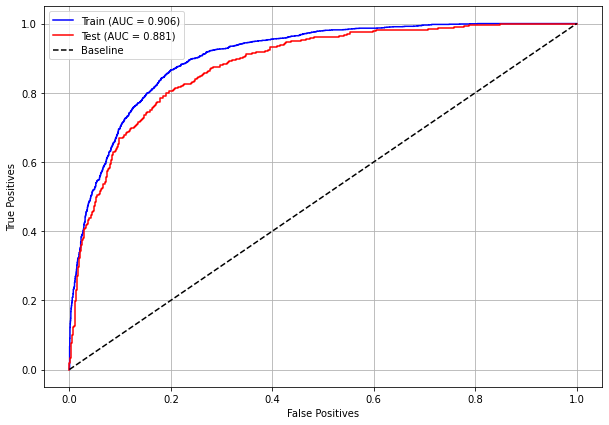

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

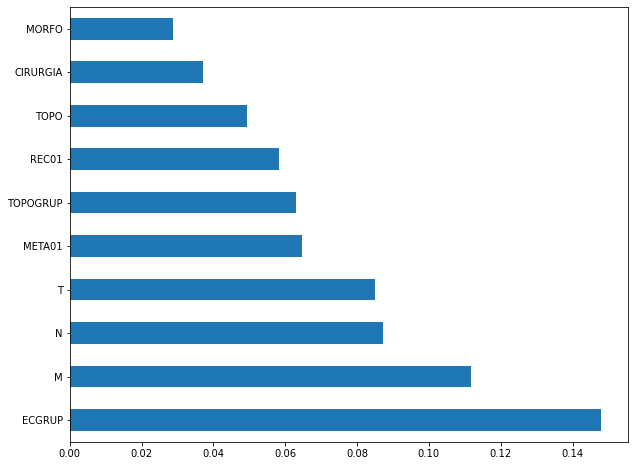

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `N` and `T`.

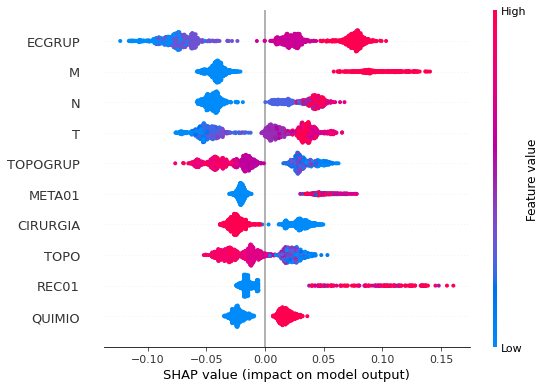

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.16},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.16}, criterion='entropy',
                       max_depth=6, random_state=10)

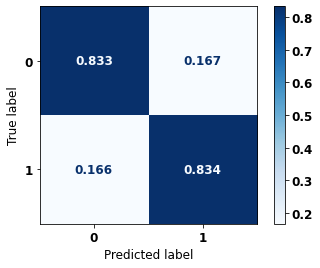


              precision    recall  f1-score   support

           0      0.924     0.833     0.876      1435
           1      0.672     0.834     0.744       589

    accuracy                          0.833      2024
   macro avg      0.798     0.833     0.810      2024
weighted avg      0.851     0.833     0.838      2024



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


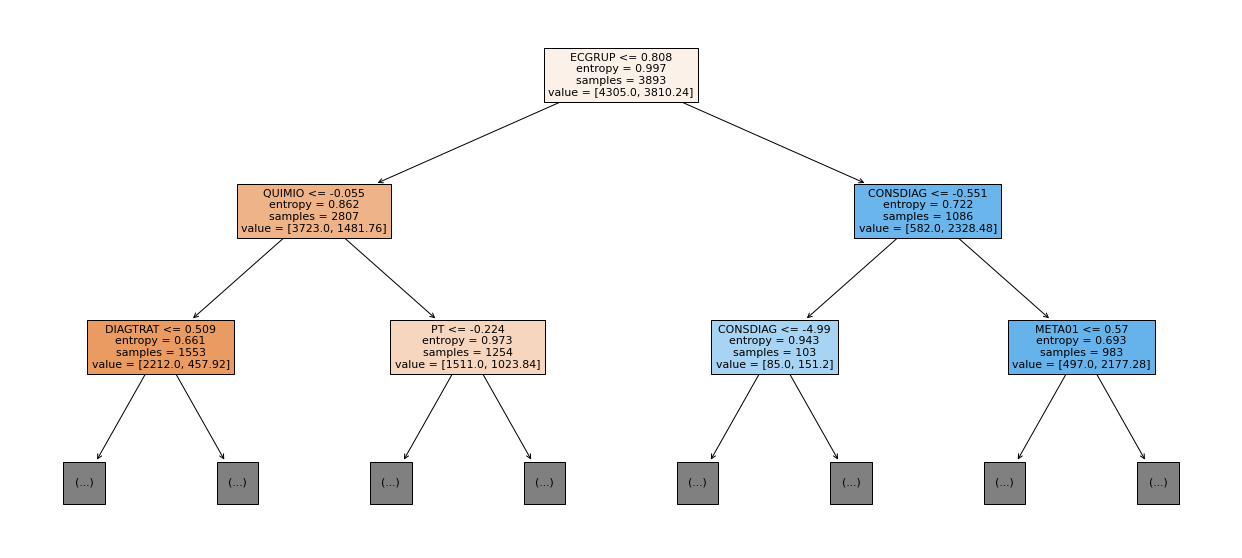

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

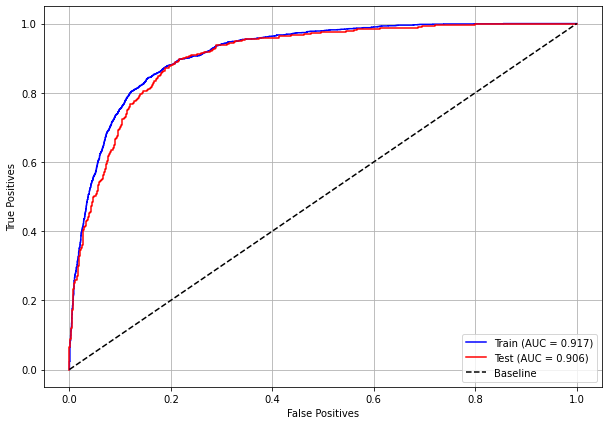

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

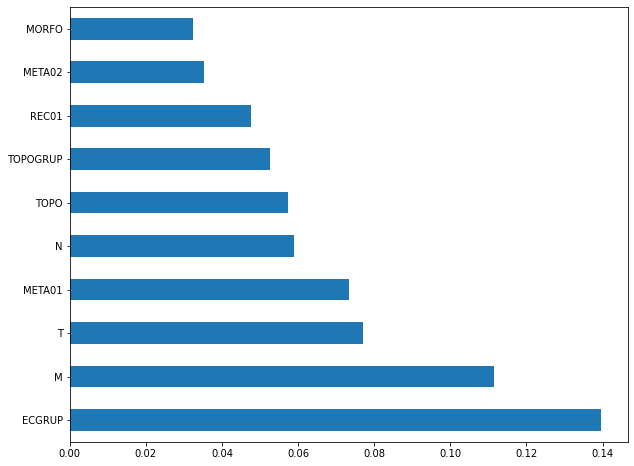

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `META01`.

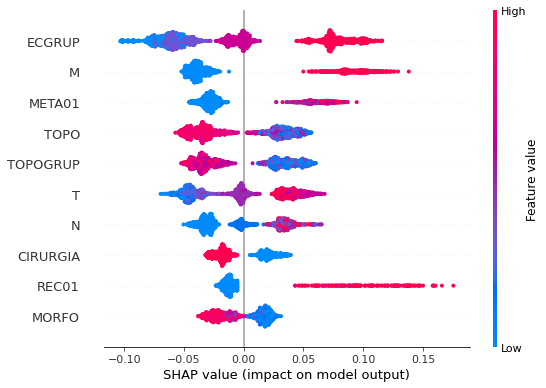

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.74},
                                       criterion='entropy',
                                       max_depth=7)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 2.74}, criterion='entropy',
                       max_depth=7, random_state=10)

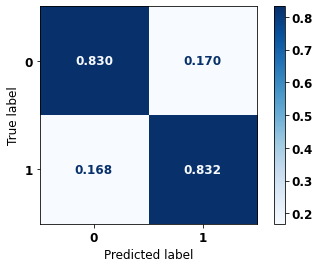


              precision    recall  f1-score   support

           0      0.939     0.830     0.881      1563
           1      0.609     0.832     0.703       499

    accuracy                          0.830      2062
   macro avg      0.774     0.831     0.792      2062
weighted avg      0.859     0.830     0.838      2062



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 83% of accuracy.


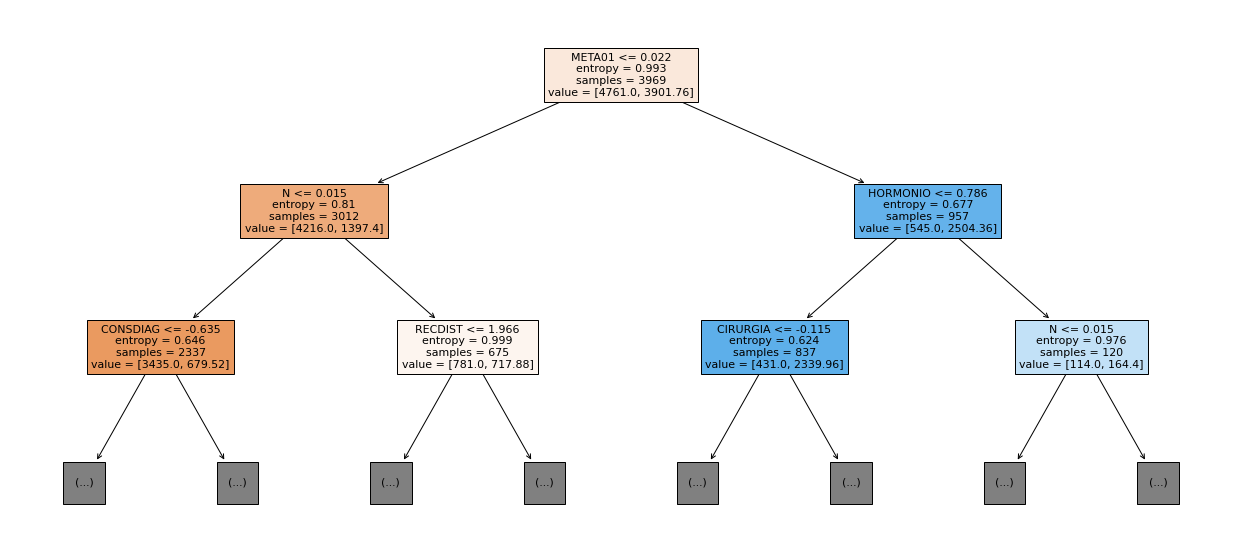

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

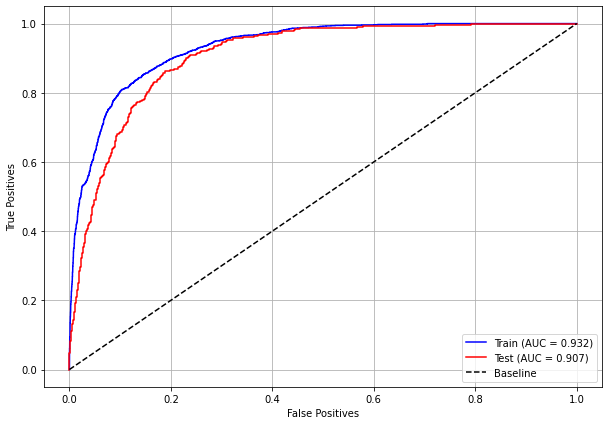

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

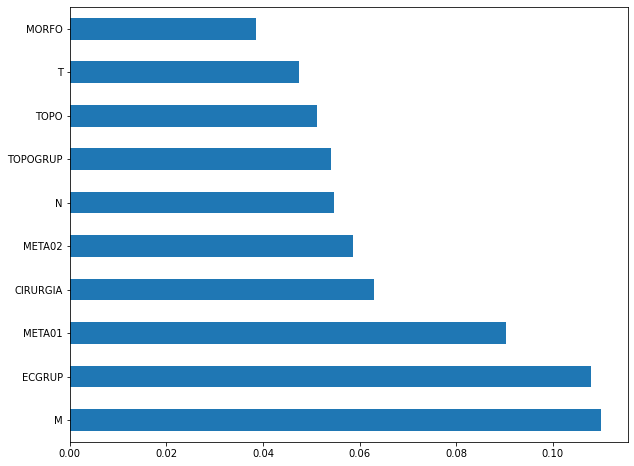

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `M`, `ECGRUP`, `META01` and `CIRURGIA`.

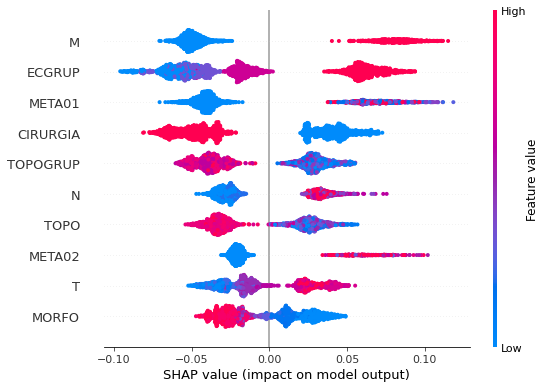

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `M` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.023)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.023)

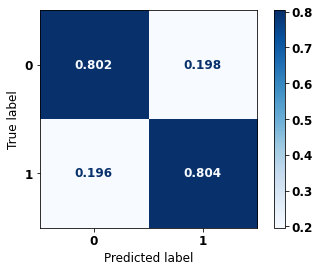


              precision    recall  f1-score   support

           0      0.815     0.802     0.808      7965
           1      0.791     0.804     0.797      7402

    accuracy                          0.803     15367
   macro avg      0.803     0.803     0.803     15367
weighted avg      0.803     0.803     0.803     15367



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 80% of accuracy.

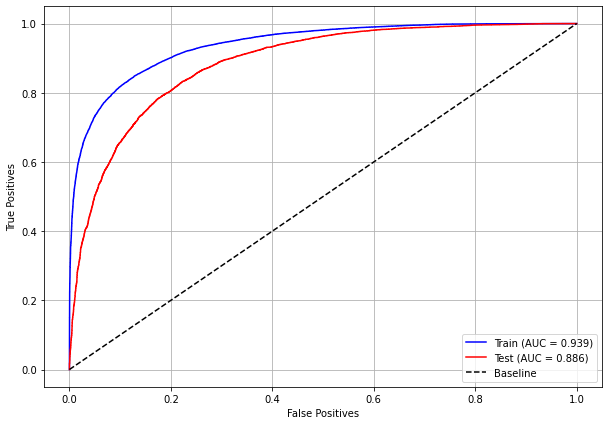

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

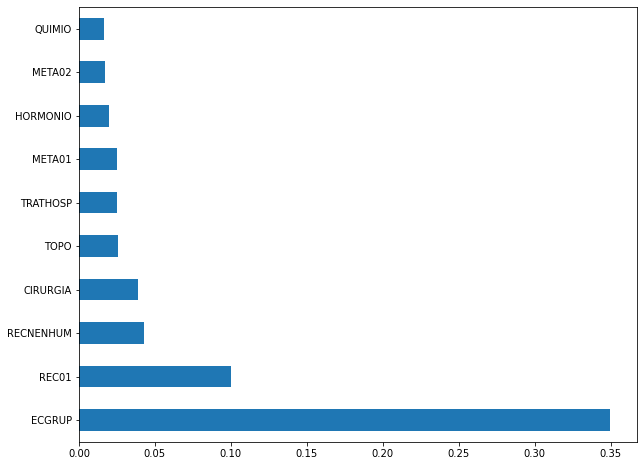

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others. Following we have `REC01`, `RECNENHUM` and `CIRURGIA`.

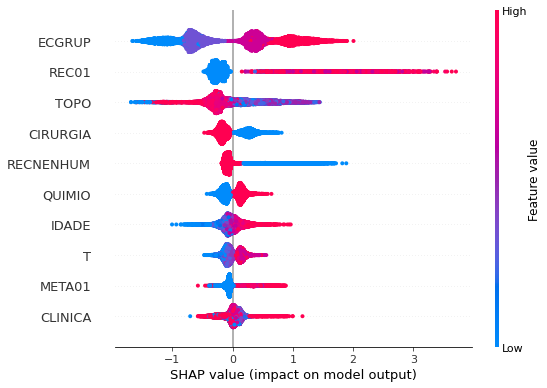

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.285)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.285)

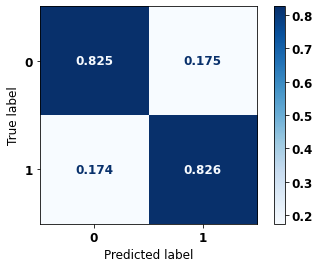


              precision    recall  f1-score   support

           0      0.859     0.825     0.842     10925
           1      0.785     0.826     0.805      8465

    accuracy                          0.825     19390
   macro avg      0.822     0.825     0.823     19390
weighted avg      0.827     0.825     0.826     19390



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 82% of accuracy.


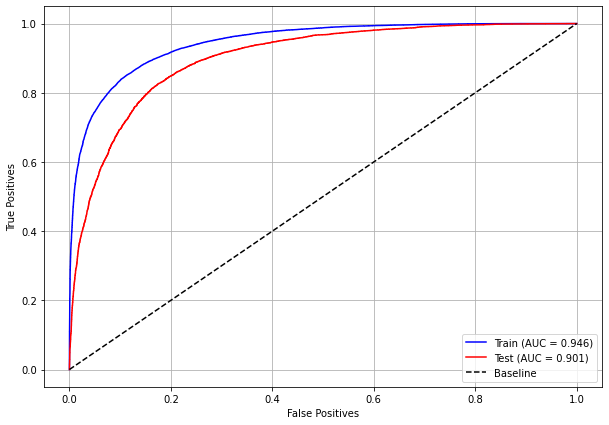

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

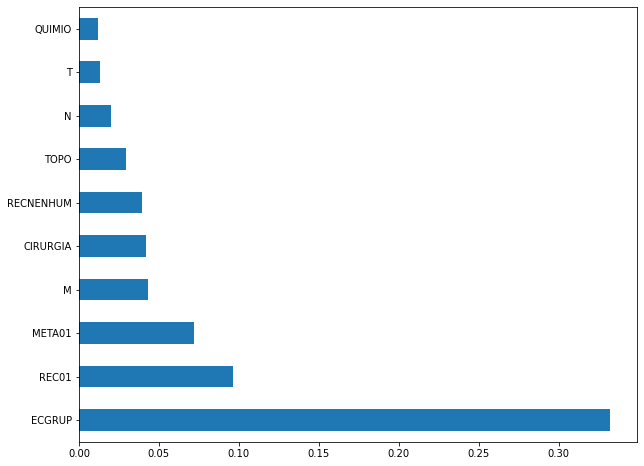

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `META01` and `M`. 

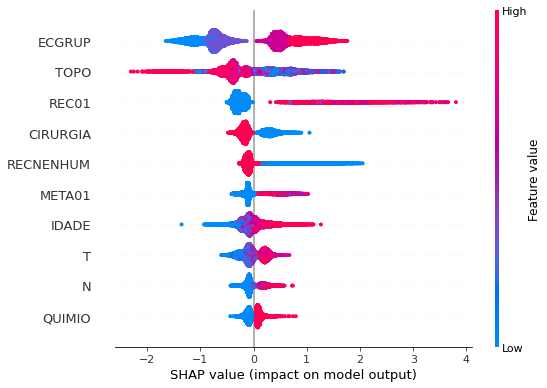

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=1.52,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.52)

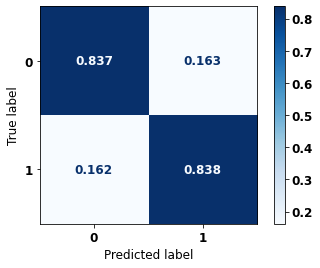


              precision    recall  f1-score   support

           0      0.889     0.837     0.862     15705
           1      0.768     0.838     0.801     10099

    accuracy                          0.837     25804
   macro avg      0.829     0.838     0.832     25804
weighted avg      0.842     0.837     0.839     25804



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 84% of accuracy.

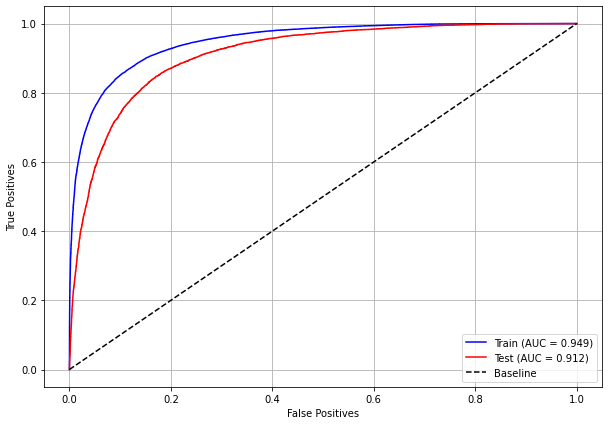

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

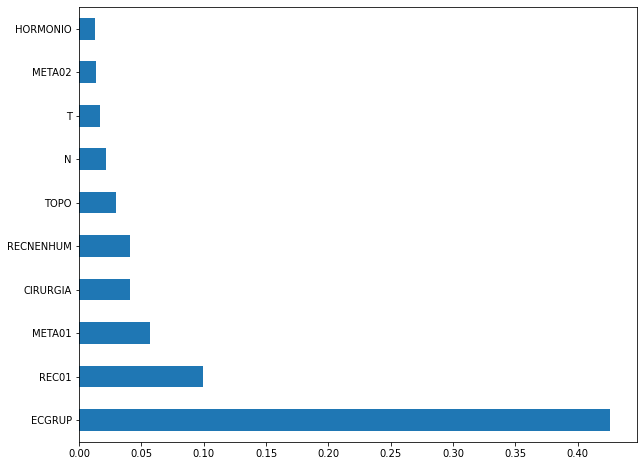

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `META01` and `CIRURGIA`. 

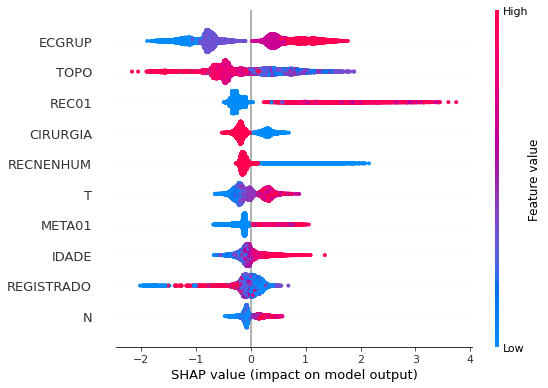

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=2.07)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=2.07)

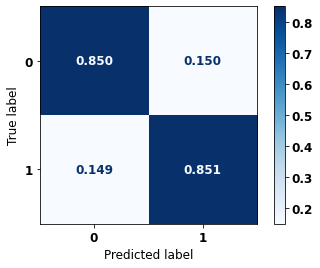


              precision    recall  f1-score   support

           0      0.924     0.850     0.885     21800
           1      0.727     0.851     0.784     10242

    accuracy                          0.850     32042
   macro avg      0.826     0.850     0.835     32042
weighted avg      0.861     0.850     0.853     32042



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 85% of accuracy.

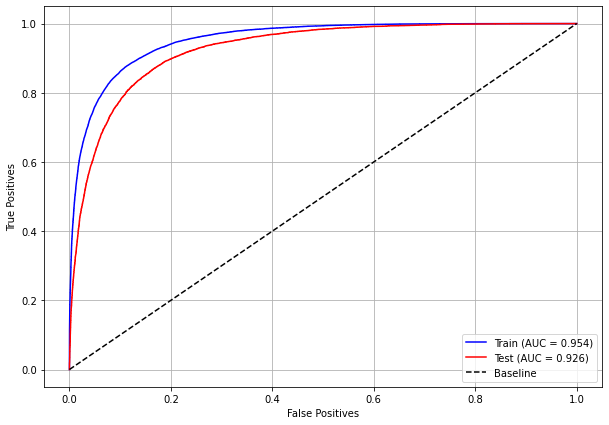

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

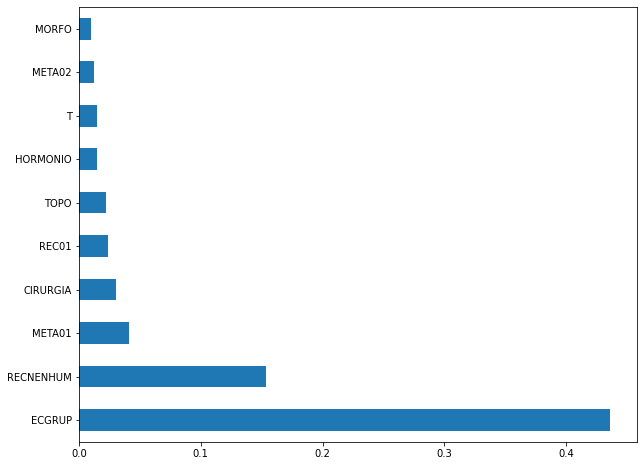

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with some advantage. Following we have `RECNENHUM`, `META01` and `CIRURGIA`. 

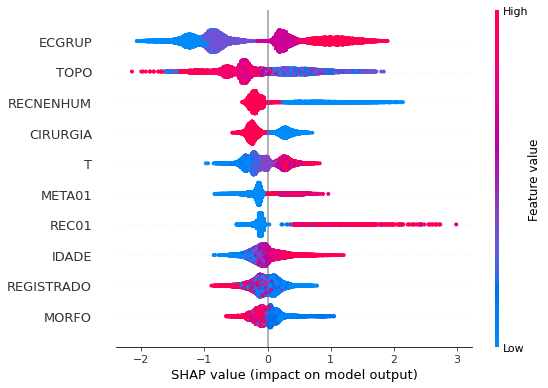

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=3.05)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=3.05)

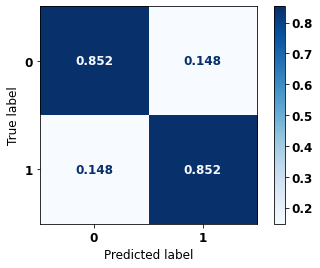


              precision    recall  f1-score   support

           0      0.949     0.852     0.898     18758
           1      0.640     0.852     0.731      5803

    accuracy                          0.852     24561
   macro avg      0.795     0.852     0.815     24561
weighted avg      0.876     0.852     0.859     24561



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.


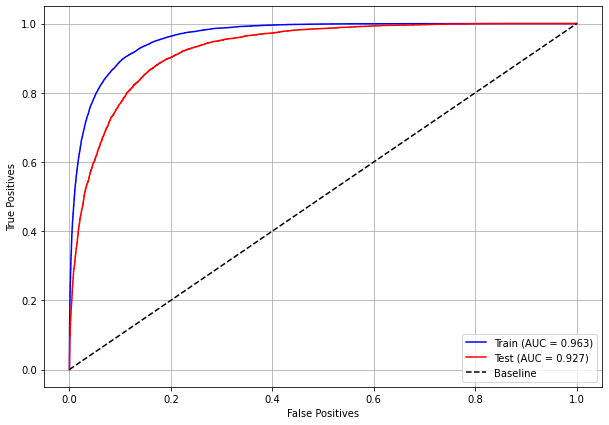

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

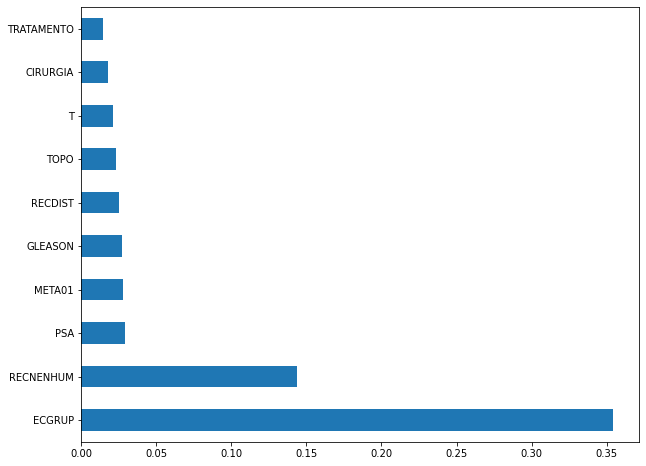

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECNENHUM`, `PSA` and `META01`.



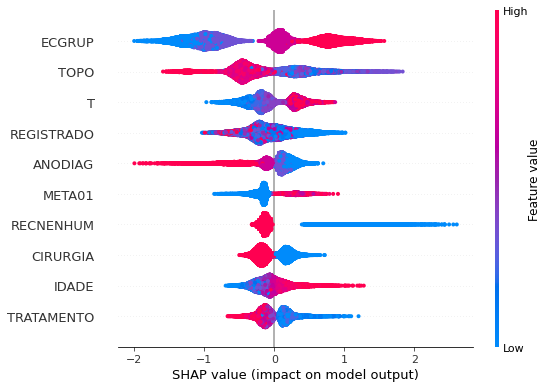

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.29,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.29)

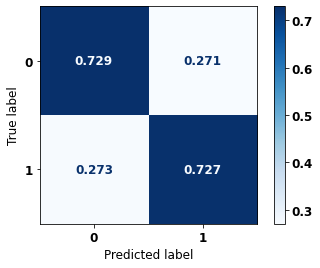


              precision    recall  f1-score   support

           0      0.781     0.729     0.754       495
           1      0.667     0.727     0.696       370

    accuracy                          0.728       865
   macro avg      0.724     0.728     0.725       865
weighted avg      0.733     0.728     0.729       865



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 73% of accuracy.

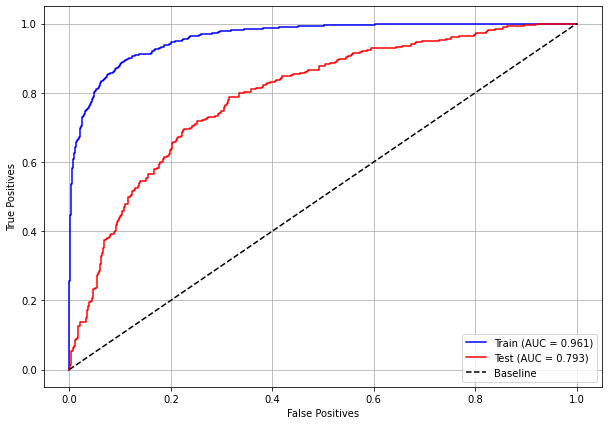

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

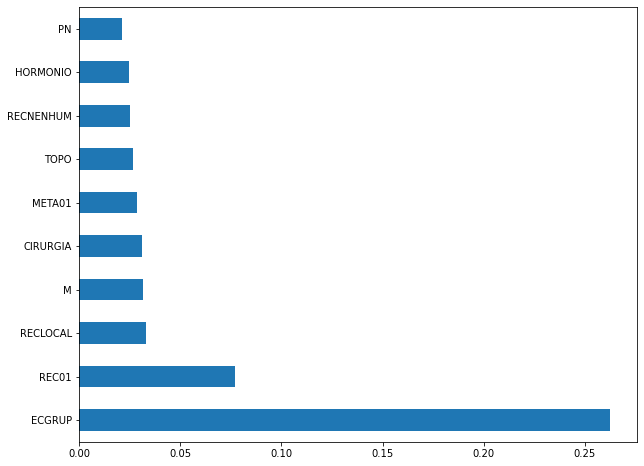

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `RECLOCAL` and `M`.

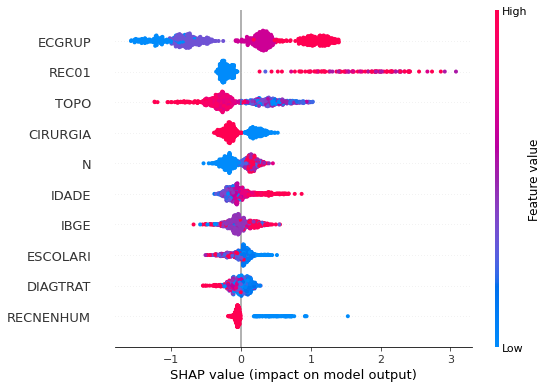

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.5,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.5)

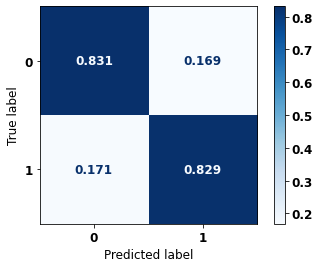


              precision    recall  f1-score   support

           0      0.874     0.831     0.852       724
           1      0.775     0.829     0.801       508

    accuracy                          0.830      1232
   macro avg      0.825     0.830     0.827      1232
weighted avg      0.833     0.830     0.831      1232



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 83% of accuracy.

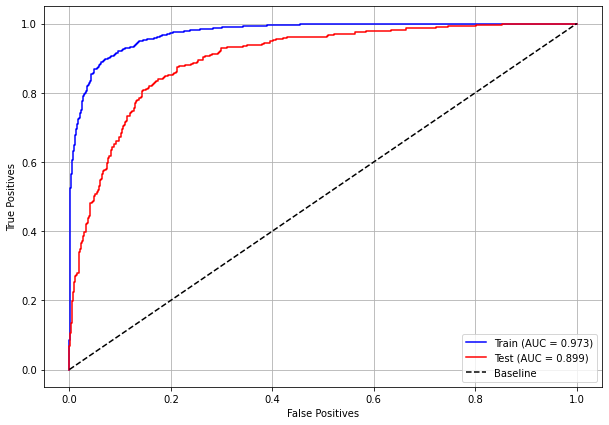

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

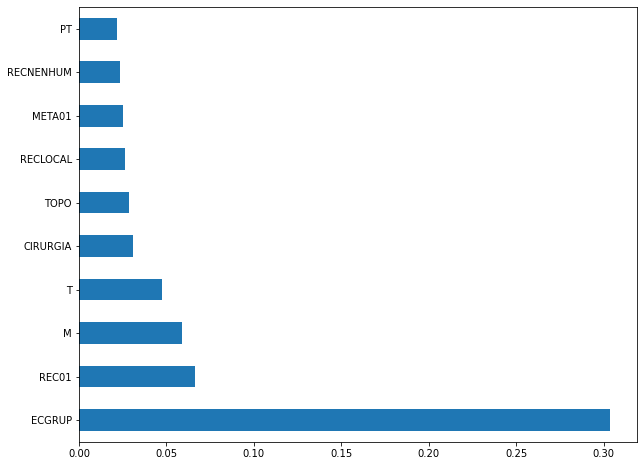

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `T`.

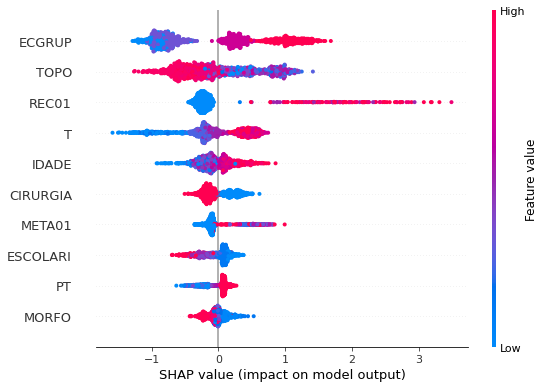

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.87,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.87)

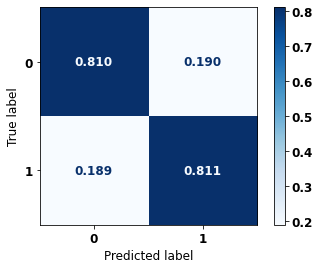


              precision    recall  f1-score   support

           0      0.882     0.810     0.844       962
           1      0.710     0.811     0.757       551

    accuracy                          0.810      1513
   macro avg      0.796     0.811     0.801      1513
weighted avg      0.819     0.810     0.813      1513



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, also shows a good performance of the model with 81% of accuracy.

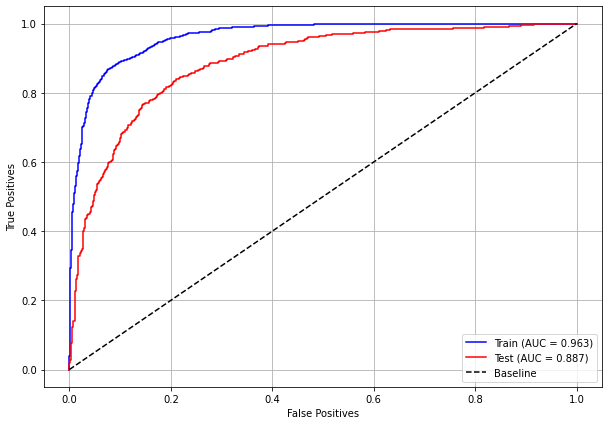

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

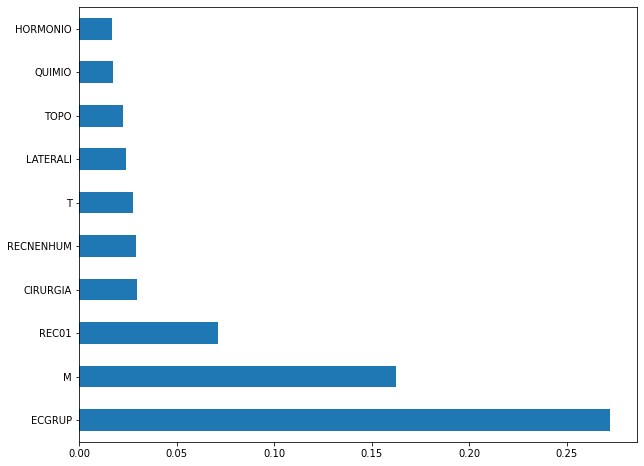

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `REC01` and `CIRURGIA`.

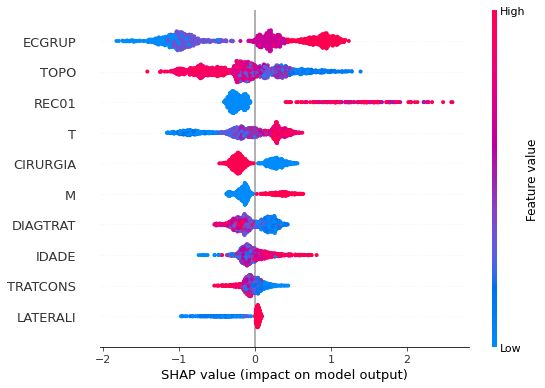

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=6, 
                               scale_pos_weight=2.57,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2.57)

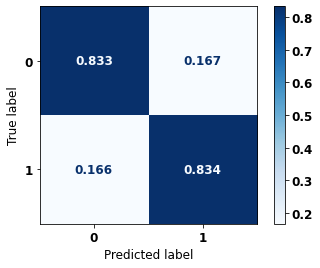


              precision    recall  f1-score   support

           0      0.924     0.833     0.877      1435
           1      0.673     0.834     0.745       589

    accuracy                          0.833      2024
   macro avg      0.798     0.834     0.811      2024
weighted avg      0.851     0.833     0.838      2024



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

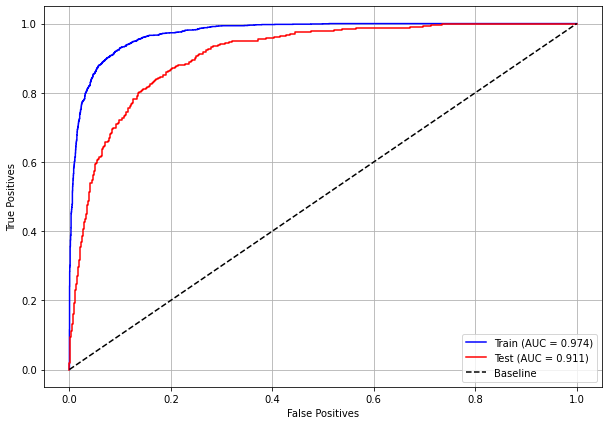

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

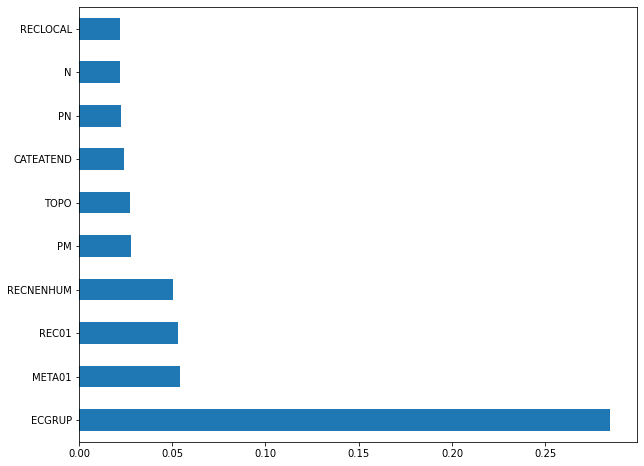

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `META01`, `REC01` and `RECNENHUM`.

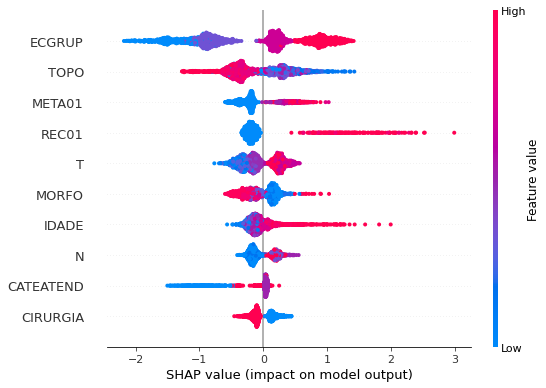

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = XGBClassifier(max_depth=6, 
                               scale_pos_weight=3.38,
                               random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=3.38)

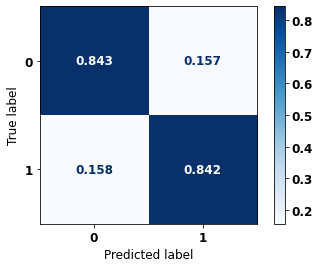


              precision    recall  f1-score   support

           0      0.943     0.843     0.891      1563
           1      0.632     0.842     0.722       499

    accuracy                          0.843      2062
   macro avg      0.788     0.842     0.806      2062
weighted avg      0.868     0.843     0.850      2062



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states from 2016 to 2020, shows the best performance comparing with the other models, with 84% of accuracy.

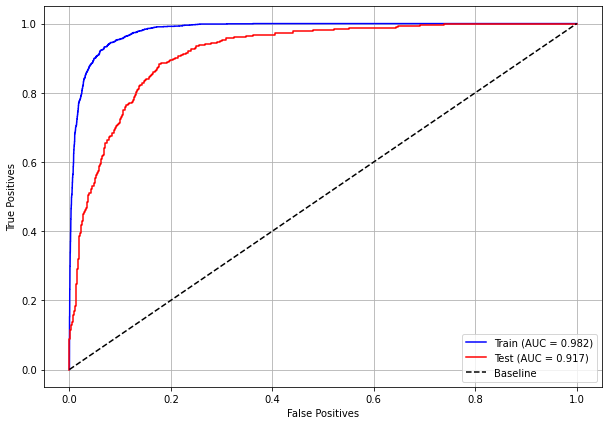

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

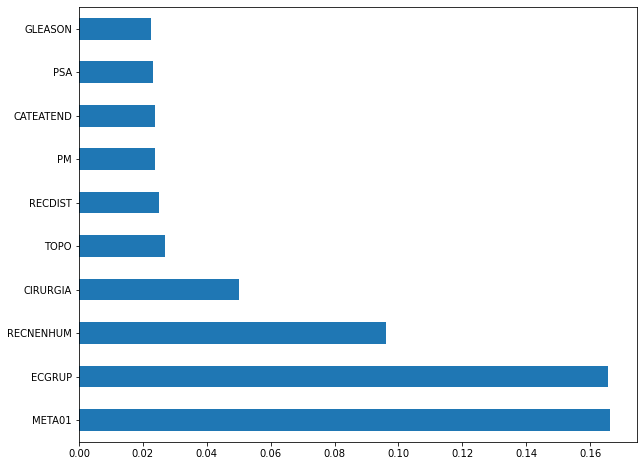

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `META01`, `ECGRUP`, `RECNENHUM` and `CIRURGIA`.

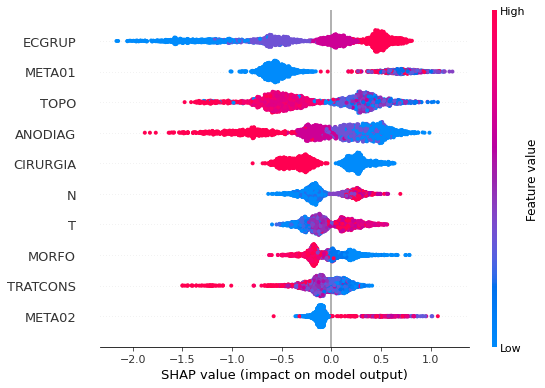

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

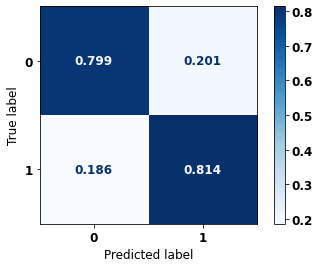


              precision    recall  f1-score   support

           0      0.847     0.799     0.822     10925
           1      0.758     0.814     0.785      8465

    accuracy                          0.806     19390
   macro avg      0.803     0.806     0.804     19390
weighted avg      0.808     0.806     0.806     19390



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

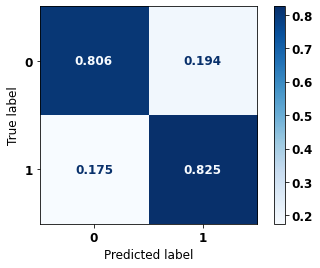


              precision    recall  f1-score   support

           0      0.877     0.806     0.840     15705
           1      0.732     0.825     0.776     10099

    accuracy                          0.813     25804
   macro avg      0.805     0.815     0.808     25804
weighted avg      0.821     0.813     0.815     25804



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

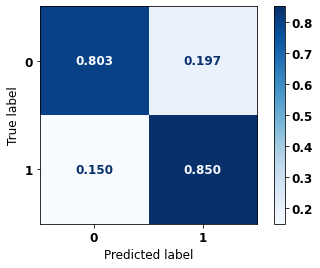


              precision    recall  f1-score   support

           0      0.919     0.803     0.857     21800
           1      0.670     0.850     0.749     10242

    accuracy                          0.818     32042
   macro avg      0.794     0.826     0.803     32042
weighted avg      0.839     0.818     0.823     32042



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

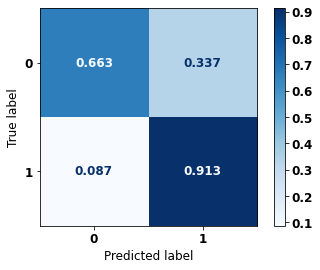


              precision    recall  f1-score   support

           0      0.961     0.663     0.785     18758
           1      0.456     0.913     0.608      5803

    accuracy                          0.722     24561
   macro avg      0.708     0.788     0.696     24561
weighted avg      0.842     0.722     0.743     24561



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

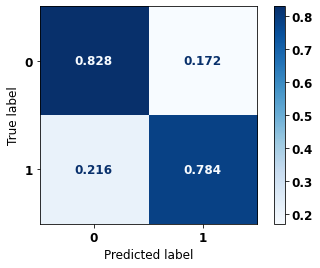


              precision    recall  f1-score   support

           0      0.832     0.828     0.830     10925
           1      0.780     0.784     0.782      8465

    accuracy                          0.809     19390
   macro avg      0.806     0.806     0.806     19390
weighted avg      0.809     0.809     0.809     19390



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

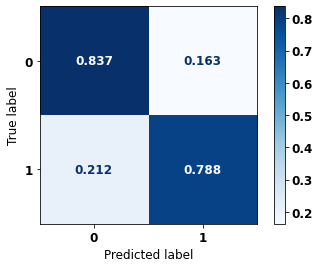


              precision    recall  f1-score   support

           0      0.860     0.837     0.848     15705
           1      0.757     0.788     0.772     10099

    accuracy                          0.818     25804
   macro avg      0.808     0.812     0.810     25804
weighted avg      0.819     0.818     0.818     25804



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

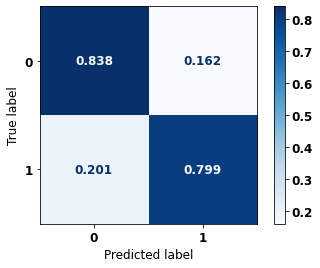


              precision    recall  f1-score   support

           0      0.899     0.838     0.868     21800
           1      0.699     0.799     0.746     10242

    accuracy                          0.826     32042
   macro avg      0.799     0.819     0.807     32042
weighted avg      0.835     0.826     0.829     32042



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

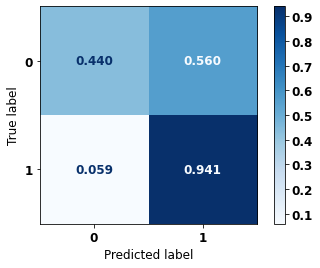


              precision    recall  f1-score   support

           0      0.960     0.440     0.603     18758
           1      0.342     0.941     0.502      5803

    accuracy                          0.558     24561
   macro avg      0.651     0.690     0.553     24561
weighted avg      0.814     0.558     0.579     24561



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

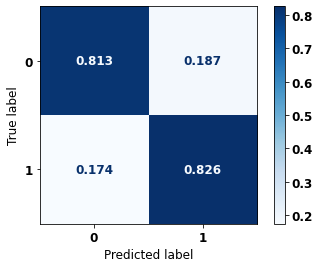


              precision    recall  f1-score   support

           0      0.879     0.813     0.845     15705
           1      0.740     0.826     0.781     10099

    accuracy                          0.818     25804
   macro avg      0.809     0.820     0.813     25804
weighted avg      0.825     0.818     0.820     25804



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

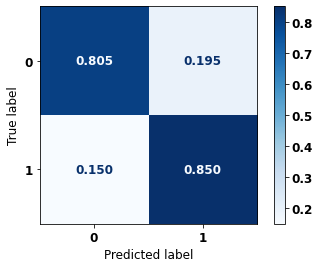


              precision    recall  f1-score   support

           0      0.919     0.805     0.858     21800
           1      0.671     0.850     0.750     10242

    accuracy                          0.819     32042
   macro avg      0.795     0.827     0.804     32042
weighted avg      0.840     0.819     0.824     32042



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

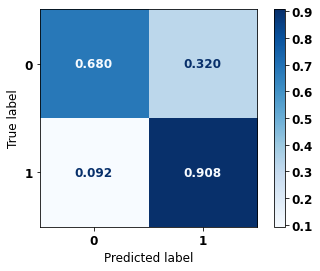


              precision    recall  f1-score   support

           0      0.960     0.680     0.796     18758
           1      0.468     0.908     0.617      5803

    accuracy                          0.734     24561
   macro avg      0.714     0.794     0.707     24561
weighted avg      0.843     0.734     0.754     24561



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

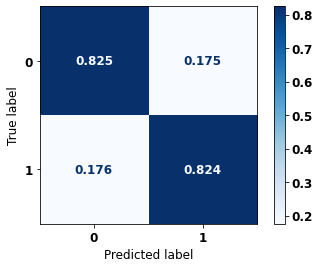


              precision    recall  f1-score   support

           0      0.880     0.825     0.851     15705
           1      0.751     0.824     0.786     10099

    accuracy                          0.825     25804
   macro avg      0.815     0.825     0.819     25804
weighted avg      0.829     0.825     0.826     25804



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

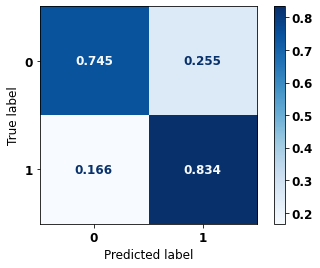


              precision    recall  f1-score   support

           0      0.905     0.745     0.817     21800
           1      0.605     0.834     0.702     10242

    accuracy                          0.773     32042
   macro avg      0.755     0.789     0.759     32042
weighted avg      0.809     0.773     0.780     32042



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

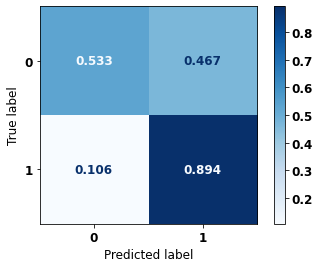


              precision    recall  f1-score   support

           0      0.942     0.533     0.681     18758
           1      0.372     0.894     0.525      5803

    accuracy                          0.618     24561
   macro avg      0.657     0.713     0.603     24561
weighted avg      0.807     0.618     0.644     24561



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

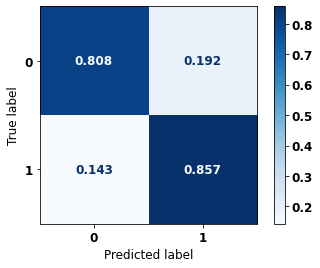


              precision    recall  f1-score   support

           0      0.923     0.808     0.862     21800
           1      0.677     0.857     0.757     10242

    accuracy                          0.824     32042
   macro avg      0.800     0.833     0.809     32042
weighted avg      0.845     0.824     0.828     32042



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

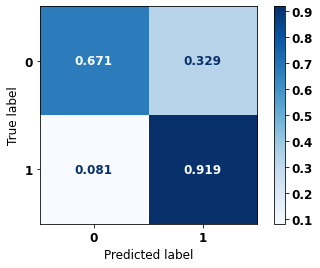


              precision    recall  f1-score   support

           0      0.964     0.671     0.791     18758
           1      0.464     0.919     0.617      5803

    accuracy                          0.730     24561
   macro avg      0.714     0.795     0.704     24561
weighted avg      0.846     0.730     0.750     24561



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

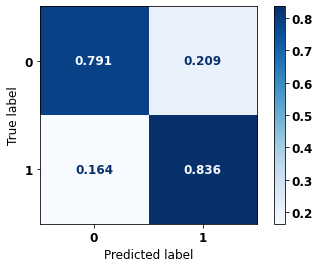


              precision    recall  f1-score   support

           0      0.911     0.791     0.847     21800
           1      0.652     0.836     0.733     10242

    accuracy                          0.805     32042
   macro avg      0.782     0.813     0.790     32042
weighted avg      0.828     0.805     0.810     32042



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

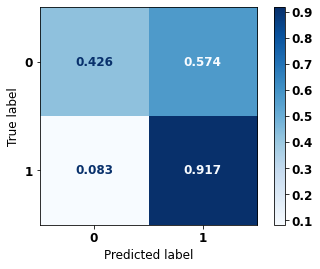


              precision    recall  f1-score   support

           0      0.943     0.426     0.587     18758
           1      0.331     0.917     0.486      5803

    accuracy                          0.542     24561
   macro avg      0.637     0.671     0.536     24561
weighted avg      0.799     0.542     0.563     24561



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

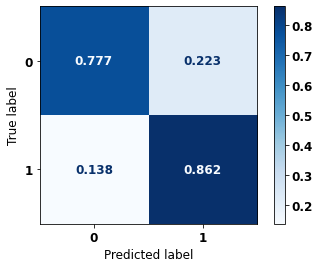


              precision    recall  f1-score   support

           0      0.948     0.777     0.854     18758
           1      0.544     0.862     0.667      5803

    accuracy                          0.797     24561
   macro avg      0.746     0.819     0.760     24561
weighted avg      0.852     0.797     0.810     24561



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

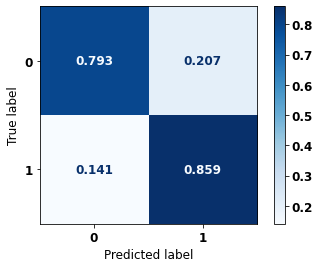


              precision    recall  f1-score   support

           0      0.948     0.793     0.864     18758
           1      0.563     0.859     0.680      5803

    accuracy                          0.809     24561
   macro avg      0.755     0.826     0.772     24561
weighted avg      0.857     0.809     0.820     24561



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

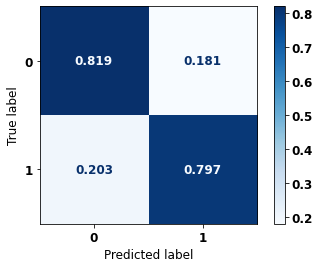


              precision    recall  f1-score   support

           0      0.852     0.819     0.835       724
           1      0.756     0.797     0.776       508

    accuracy                          0.810      1232
   macro avg      0.804     0.808     0.806      1232
weighted avg      0.812     0.810     0.811      1232



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

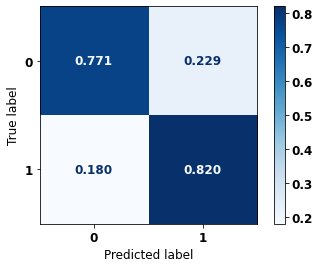


              precision    recall  f1-score   support

           0      0.882     0.771     0.823       962
           1      0.673     0.820     0.739       551

    accuracy                          0.789      1513
   macro avg      0.777     0.796     0.781      1513
weighted avg      0.806     0.789     0.793      1513



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

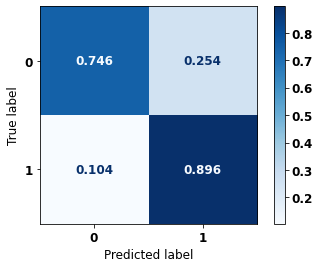


              precision    recall  f1-score   support

           0      0.946     0.746     0.834      1435
           1      0.591     0.896     0.713       589

    accuracy                          0.790      2024
   macro avg      0.769     0.821     0.773      2024
weighted avg      0.843     0.790     0.799      2024



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

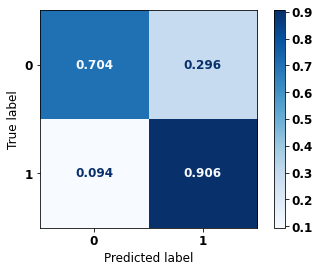


              precision    recall  f1-score   support

           0      0.959     0.704     0.812      1563
           1      0.495     0.906     0.640       499

    accuracy                          0.753      2062
   macro avg      0.727     0.805     0.726      2062
weighted avg      0.847     0.753     0.771      2062



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

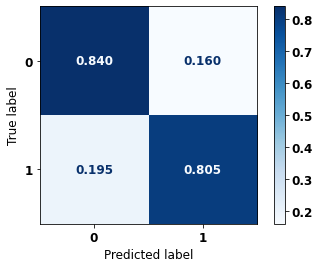


              precision    recall  f1-score   support

           0      0.860     0.840     0.850       724
           1      0.779     0.805     0.792       508

    accuracy                          0.825      1232
   macro avg      0.820     0.822     0.821      1232
weighted avg      0.827     0.825     0.826      1232



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

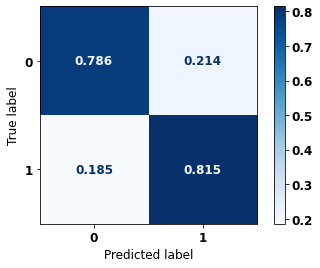


              precision    recall  f1-score   support

           0      0.881     0.786     0.831       962
           1      0.685     0.815     0.745       551

    accuracy                          0.796      1513
   macro avg      0.783     0.800     0.788      1513
weighted avg      0.810     0.796     0.799      1513



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

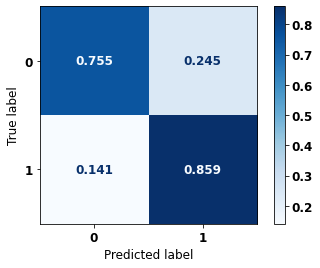


              precision    recall  f1-score   support

           0      0.929     0.755     0.833      1435
           1      0.590     0.859     0.700       589

    accuracy                          0.786      2024
   macro avg      0.760     0.807     0.767      2024
weighted avg      0.830     0.786     0.794      2024



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

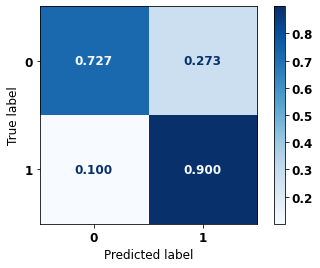


              precision    recall  f1-score   support

           0      0.958     0.727     0.826      1563
           1      0.513     0.900     0.653       499

    accuracy                          0.769      2062
   macro avg      0.735     0.813     0.740      2062
weighted avg      0.850     0.769     0.785      2062



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

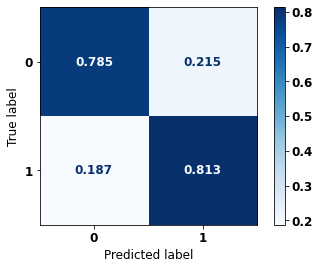


              precision    recall  f1-score   support

           0      0.880     0.785     0.830       962
           1      0.684     0.813     0.743       551

    accuracy                          0.795      1513
   macro avg      0.782     0.799     0.786      1513
weighted avg      0.809     0.795     0.798      1513



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

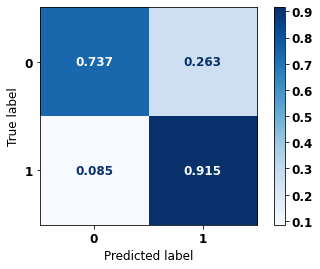


              precision    recall  f1-score   support

           0      0.955     0.737     0.832      1435
           1      0.588     0.915     0.716       589

    accuracy                          0.789      2024
   macro avg      0.772     0.826     0.774      2024
weighted avg      0.848     0.789     0.798      2024



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

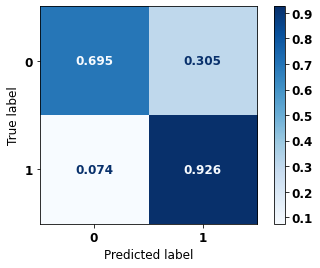


              precision    recall  f1-score   support

           0      0.967     0.695     0.809      1563
           1      0.492     0.926     0.643       499

    accuracy                          0.751      2062
   macro avg      0.730     0.810     0.726      2062
weighted avg      0.852     0.751     0.768      2062



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

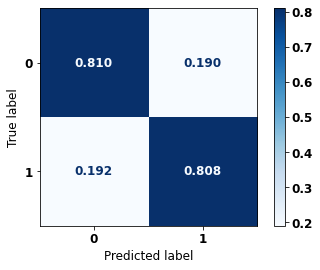


              precision    recall  f1-score   support

           0      0.880     0.810     0.844       962
           1      0.709     0.808     0.755       551

    accuracy                          0.809      1513
   macro avg      0.794     0.809     0.799      1513
weighted avg      0.818     0.809     0.811      1513



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

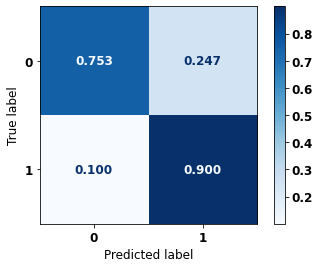


              precision    recall  f1-score   support

           0      0.948     0.753     0.839      1435
           1      0.599     0.900     0.719       589

    accuracy                          0.795      2024
   macro avg      0.774     0.826     0.779      2024
weighted avg      0.847     0.795     0.804      2024



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

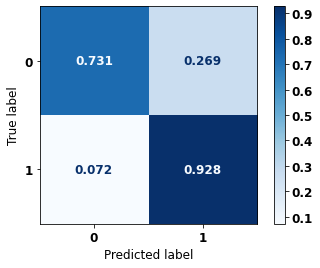


              precision    recall  f1-score   support

           0      0.969     0.731     0.833      1563
           1      0.524     0.928     0.670       499

    accuracy                          0.778      2062
   macro avg      0.747     0.829     0.751      2062
weighted avg      0.862     0.778     0.794      2062



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

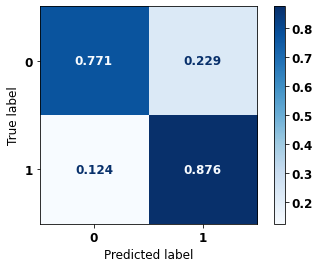


              precision    recall  f1-score   support

           0      0.938     0.771     0.847      1435
           1      0.611     0.876     0.720       589

    accuracy                          0.802      2024
   macro avg      0.775     0.824     0.783      2024
weighted avg      0.843     0.802     0.810      2024



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

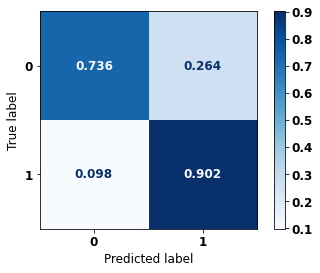


              precision    recall  f1-score   support

           0      0.959     0.736     0.833      1563
           1      0.522     0.902     0.661       499

    accuracy                          0.776      2062
   macro avg      0.741     0.819     0.747      2062
weighted avg      0.853     0.776     0.792      2062



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

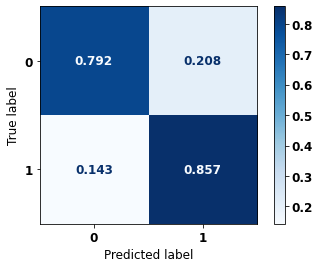


              precision    recall  f1-score   support

           0      0.931     0.792     0.856      1435
           1      0.628     0.857     0.725       589

    accuracy                          0.811      2024
   macro avg      0.780     0.825     0.790      2024
weighted avg      0.843     0.811     0.818      2024



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

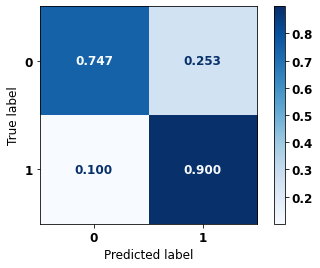


              precision    recall  f1-score   support

           0      0.959     0.747     0.840      1563
           1      0.531     0.900     0.668       499

    accuracy                          0.784      2062
   macro avg      0.745     0.823     0.754      2062
weighted avg      0.855     0.784     0.798      2062



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

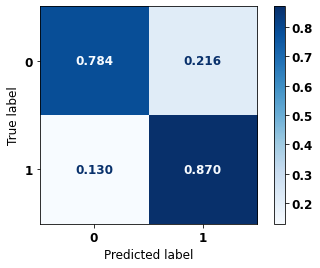


              precision    recall  f1-score   support

           0      0.950     0.784     0.859      1563
           1      0.563     0.870     0.683       499

    accuracy                          0.805      2062
   macro avg      0.756     0.827     0.771      2062
weighted avg      0.856     0.805     0.817      2062



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

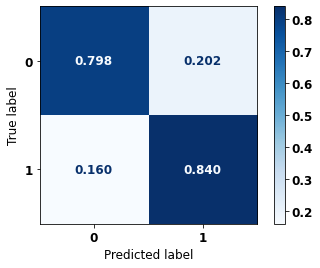


              precision    recall  f1-score   support

           0      0.940     0.798     0.863      1563
           1      0.570     0.840     0.679       499

    accuracy                          0.808      2062
   macro avg      0.755     0.819     0.771      2062
weighted avg      0.850     0.808     0.818      2062



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)